# Median correction of the NSAF data table

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

from scipy import stats

import sys
sys.path.append("../")

import utils_ML as uml

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [42]:
def calc_median(row):
    values = row[row!=0]
    return np.median(values)

def get_fc_plot(sample1, sample2, index):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    count = 0
    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(sample1[i] / sample2[i])
            count += 1
    
    print(f"{index}:\tcommon prots: {count}\tmedianFC: {np.median(log_fc)}\tstdFC: {np.std(log_fc)}")
    return log_fc

def plot_fc(subset, ref = None, plot_med_fc = False, color_scheme = None, xlims = (-2,2)):
    """ref = index of the reference sample, default is first sample"""
    full_df = pd.DataFrame(data = {"fold_change":{}, "index":{}})
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    list_med_fc = []
    indices = []
    for index, row in subset.iterrows():
        if index == ref_i:
            continue
        
        fc_list = get_fc_plot(ref, row, index)
        list_med_fc.append(np.median(fc_list))
        indices.append(index)
        df = pd.DataFrame({"fold_change": fc_list})
       
        df["index"] = index
        full_df = pd.concat([full_df, df], ignore_index = True)

    if plot_med_fc:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (25,8))
        
        ax1.set_xlim(right= xlims[1], left = xlims[0])    
        ax1.set_title("Fold changes")
        ax2.set_title("median fold changes")
        if color_scheme != None:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = color_scheme, common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = color_scheme,  alpha = .8)
        
        else:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = "tab10",  alpha = .8)
        return
        
    plt.xlim(right= 2, left = -2)    
    sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .5, legend = False)

def calculate_correlations(dataset, assay_ids):
    
    correlation_assays = {pxd :[] for pxd in meta.loc[assay_ids].PXD_accession.unique()}
    across_project_corr = {}
    dataset = dataset
    
    comparisons = combinations(assay_ids, 2)

    for comparison in comparisons:
        id1 = comparison[0]
        id2 = comparison[1]

        comp_df = dataset.loc[[id1,id2], :].T.dropna()

        r = stats.pearsonr(x=comp_df.loc[:,id1], y=comp_df.loc[:,id2])[0]

        pxd1 = meta.loc[id1].PXD_accession
        pxd2 = meta.loc[id2].PXD_accession
        if pxd1 == pxd2:
            correlation_assays[meta.loc[id1].PXD_accession].append(r)
        
        elif str(pxd1)+"-"+str(pxd2) in across_project_corr.keys():
            across_project_corr[str(pxd1)+"-"+str(pxd2)].append(r)

        elif str(pxd2)+"-"+str(pxd1) in across_project_corr.keys():
            across_project_corr[str(pxd2)+"-"+str(pxd1)].append(r)
        else:
            across_project_corr[str(pxd1)+"-"+str(pxd2)] = [r]

    return correlation_assays, across_project_corr

In [3]:
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")
meta = meta[meta.index.isin(nsaf.index)]

nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [4]:
hela_assays = meta[meta.cell_line == "HeLa"].index
hela_nsaf = nsaf.loc[hela_assays,:]
hela_meta = meta[meta.index.isin(hela_assays)]

lut = {}
for x in hela_meta.PXD_accession.unique():
    lut[x] = sns.color_palette("deep")[len(lut)]

drop 32662, 34740?

In [71]:
hela_nsaf_ = hela_nsaf.loc[~hela_nsaf.index.isin([32662,34740]),:]
hela_meta_ = hela_meta.loc[~hela_meta.index.isin([32662,34740]),:]

---

In [69]:
# See at the end of document (filtered raw files identifying < 1100 proteins)
nsaf_filtered
meta = meta[meta.index.isin(nsaf_filtered.index)]

nsaf_filtered.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [70]:
hela_assays = meta[meta.cell_line == "HeLa"].index
hela_nsaf = nsaf_filtered.loc[hela_assays,:]
hela_meta = meta[meta.index.isin(hela_assays)]

There is a large variability in protein identifications

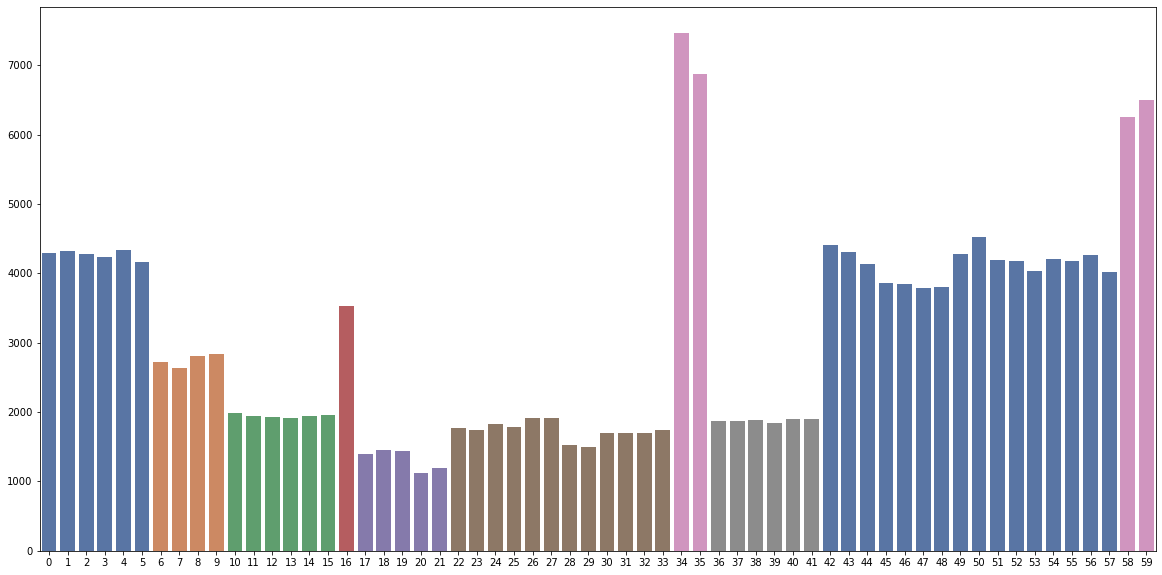

In [14]:
plt.figure(figsize=(20,10))

cols = hela_meta.PXD_accession.apply(lambda x: lut[x])

sns.barplot(x=list(range(len(hela_nsaf))), y=hela_nsaf.notna().sum(axis=1), palette=cols)

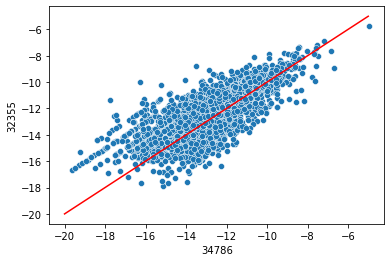

In [15]:
# Plot of 2 samples showing correlation of proteins
sns.scatterplot(data=np.log2(hela_nsaf.loc[[34786,32355],:].T.dropna()), x=34786,y=32355)
plt.plot([-20,-5], [-20,-5], color='r')

NameError: name 'lowest_std' is not defined

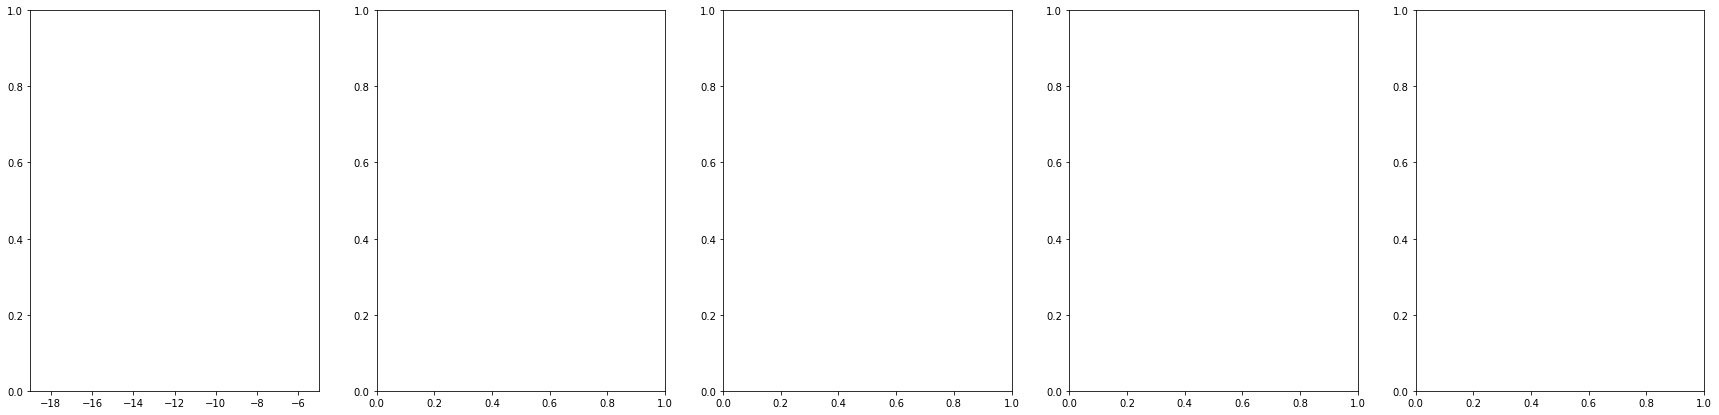

In [17]:
fig, ax = plt.subplots(1,5, figsize=(30,7))
for i, axi in enumerate(ax):
    axi.set_xlim((-19,-5))
    sns.scatterplot(x=np.log2(nsaf_filtered.loc[:, lowest_std.loc[i].uniprot_id]), y = nsaf_filtered.notna().sum(axis=1), ax=axi, hue=meta.cell_line, legend=False)

fig, ax = plt.subplots(1,5, figsize=(30,7))
for i, axi in enumerate(ax):
    axi.set_xlim((-19,-5))
    sns.scatterplot(x=np.log2(nsaf_filtered.loc[:, lowest_std.loc[len(lowest_std)-1-i].uniprot_id]), y = nsaf_filtered.notna().sum(axis=1), ax=axi, hue=meta.cell_line, legend=False)

In [16]:
# Plot of 2 samples showing correlation of proteins
sns.scatterplot(data=scaled_nsaf.loc[[34786,32355],:].T.dropna(), x=34786,y=32355)
plt.plot([-7,0, 3], [-7,0, 3], color='r')

NameError: name 'scaled_nsaf' is not defined

In [144]:
hela_nsaf.T.melt().dropna()

assay_id     value
7          32003  0.000053
13         32003  0.000089
26         32003  0.000007
59         32003  0.000006
60         32003  0.000206
...          ...       ...
870411     34786  0.000046
870412     34786  0.000116
870413     34786  0.000132
870415     34786  0.000261
870418     34786  0.000011

[183678 rows x 2 columns]

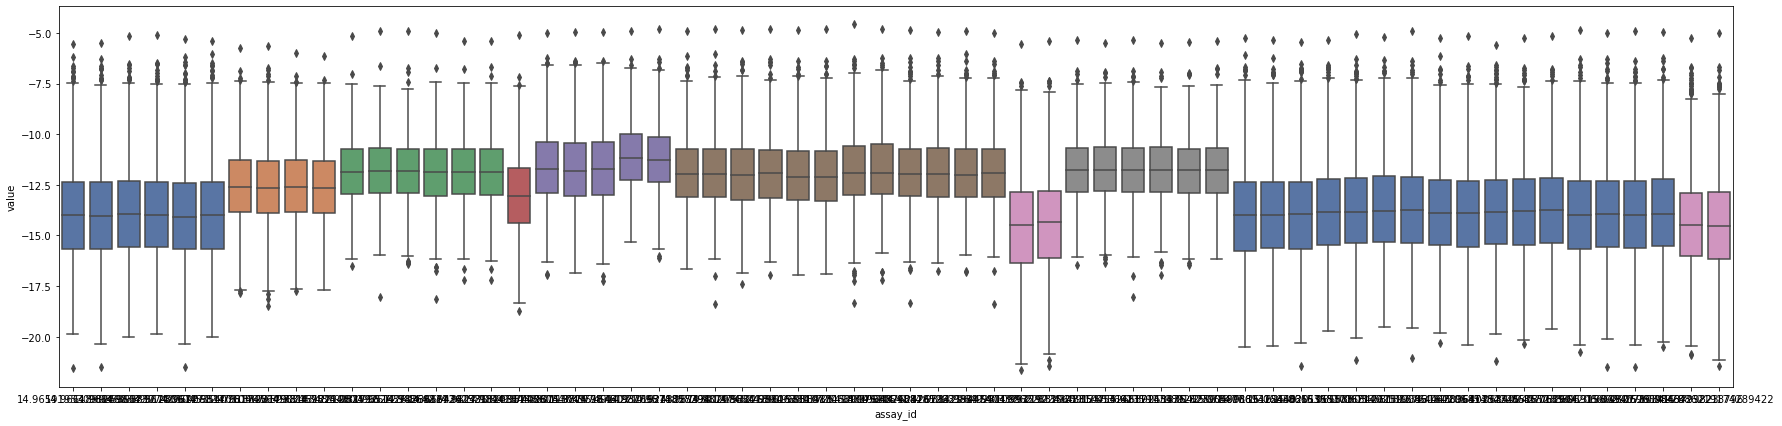

In [154]:
plt.figure(figsize=(30,7))
sns.boxplot(data=np.log2(hela_nsaf.T.melt().dropna()), y='value', x="assay_id", palette=cols)

In [231]:
top_500_abundance = {}
for i, row in np.log2(hela_nsaf).iterrows():
    top_500_abundance[i] = np.sort(np.array(row.dropna()))[-500::]

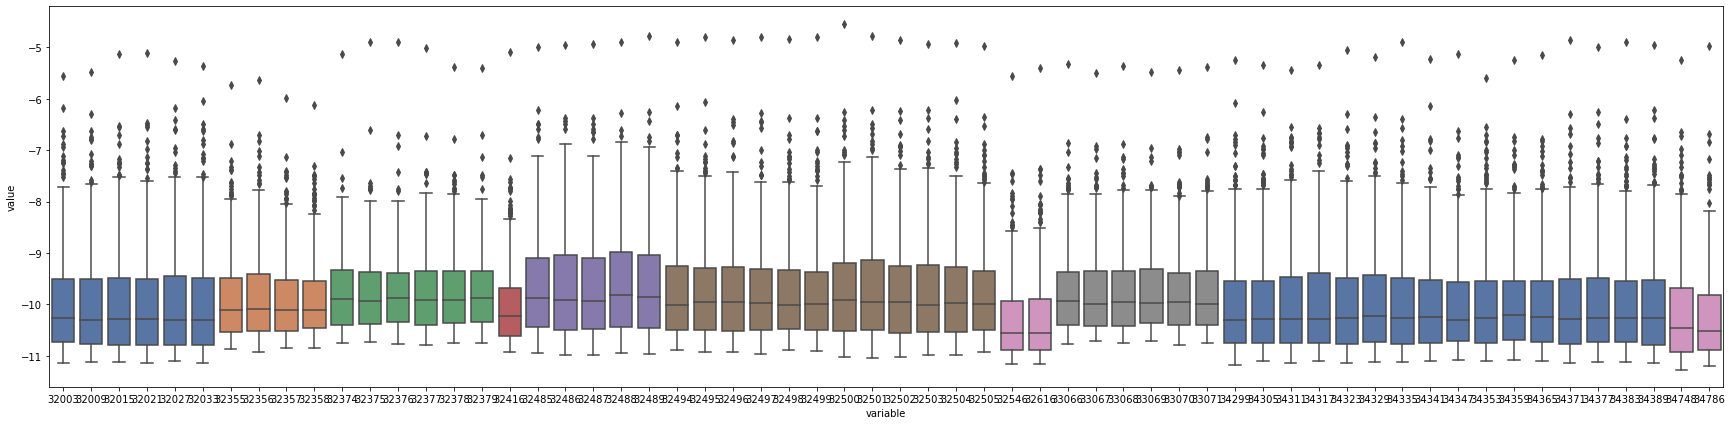

In [232]:
plt.figure(figsize=(30,7))
sns.boxplot(data=pd.DataFrame(top_500_abundance).melt(), y='value', x="variable", palette=cols)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


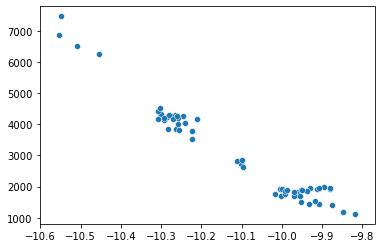

In [233]:
sns.scatterplot(pd.DataFrame(top_500_abundance).median(axis=0), hela_nsaf.notna().sum(axis=1))

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


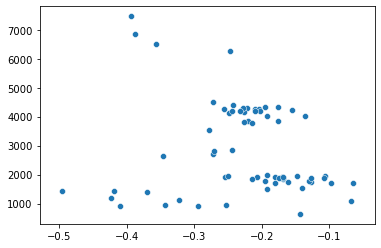

In [13]:
top_500_abundance = {}
for i, row in scaled_nsaf.iterrows():
    top_500_abundance[i] = np.sort(np.array(row.dropna()))[-500::]
sns.scatterplot(pd.DataFrame(top_500_abundance).median(axis=0), hela_nsaf.notna().sum(axis=1))

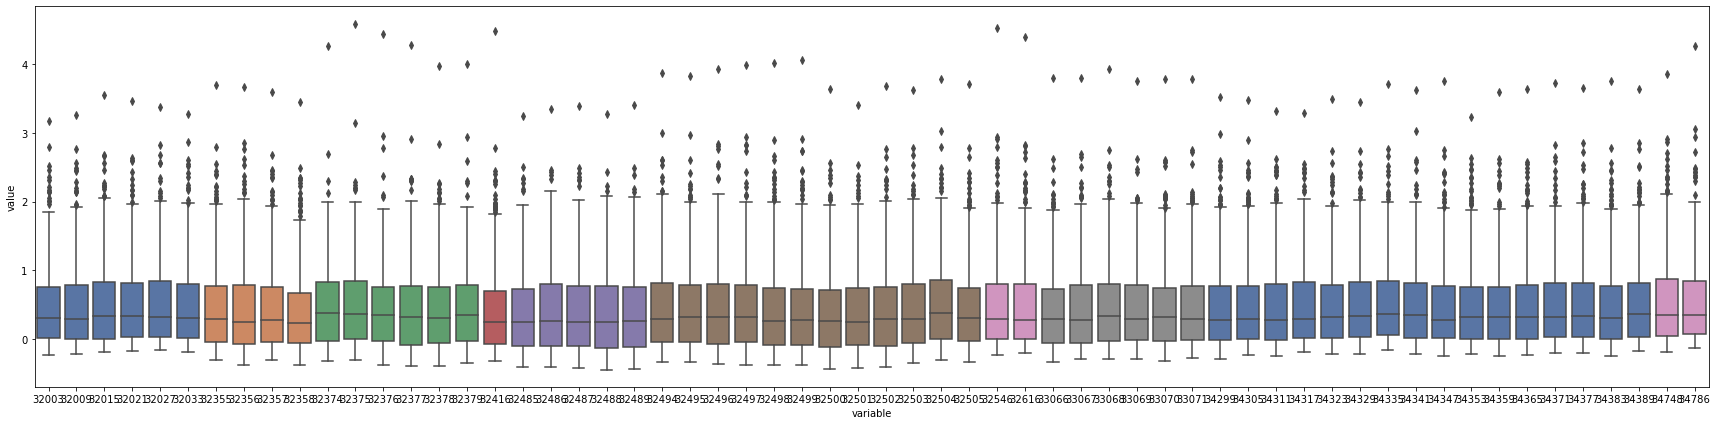

In [201]:
top_500_abundance = {}
for i, row in scaled_nsaf.iterrows():
    top_500_abundance[i] = np.sort(np.array(row.dropna()))[-500::]
plt.figure(figsize=(30,7))
sns.boxplot(data=pd.DataFrame(top_500_abundance).melt(), y='value', x="variable", palette=cols)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


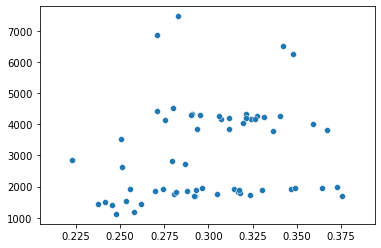

In [202]:
sns.scatterplot(pd.DataFrame(top_500_abundance).median(axis=0), hela_nsaf.notna().sum(axis=1))

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


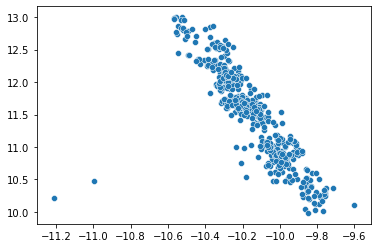

In [240]:
top_500_abundance = {}
for i, row in np.log2(nsaf_filtered).iterrows():
    top_500_abundance[i] = np.sort(np.array(row.dropna()))[-500::]

sns.scatterplot(pd.DataFrame(top_500_abundance).median(axis=0), np.log2(nsaf_filtered.notna().sum(axis=1)))

In [244]:
nsaf_filtered.index[pd.DataFrame(top_500_abundance).median(axis=0)<-10.8]

Int64Index([31162, 31163], dtype='int64', name='assay_id')

In [245]:
meta.loc[[31162, 31163],:]

project_id                               filename  cell_id  \
assay_id                                                               
31162           1820  161021_deSDS_Digested_cells_1SDS_01_A      556   
31163           1820  161021_deSDS_Digested_cells_1SDS_01_B      556   

         cell_line  disease treatment   tissue_type sub_cell  organ_id  \
assay_id                                                                 
31162       HEK293  healthy         /  fetal kidney  HEK293F       NaN   
31163       HEK293  healthy         /  fetal kidney  HEK293F       NaN   

         PXD_accession  all_PSM  sign_PSM  peptides  proteins  \
assay_id                                                        
31162        PXD006035    40216      7051      1918       314   
31163        PXD006035    33347      5174      1385       282   

            experiment_type          instrument      pmid  pool_id  \
assay_id                                                             
31162     in-solution, FASP  LTQ Orbitrap Velos  29888605        1   
31163     in-solution, FASP  LTQ Orbitrap Velos  29888605        2   

         ionbot_version  
assay_id                 
31162     IONBOT_v0.6.2  
31163     IONBOT_v0.6.2

In [9]:
reocurring_nsaf = uml.FilterByOccurence(1).fit_transform(hela_nsaf)

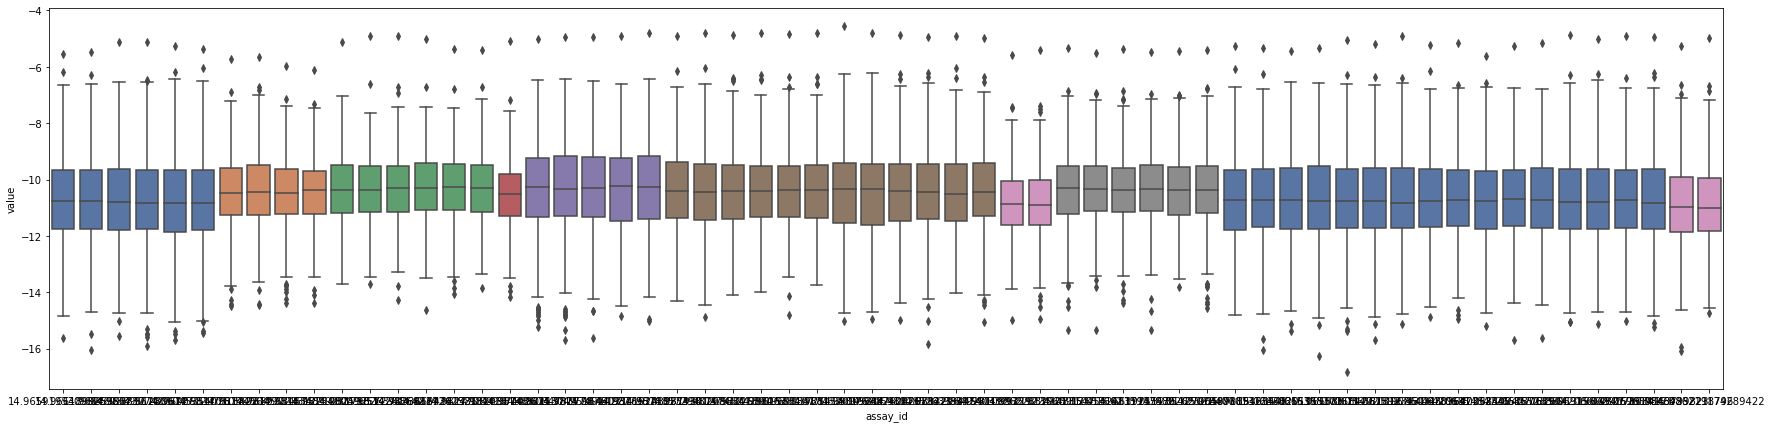

In [46]:
plt.figure(figsize=(30,7))
sns.boxplot(data=np.log2(reocurring_nsaf.T.melt().dropna()), y='value', x="assay_id", palette=cols)

In [10]:
med_std = pd.DataFrame(index=reocurring_nsaf.index)
med_std["med"] = np.log2(reocurring_nsaf).median(axis=1)
med_std["std_"] = np.log2(reocurring_nsaf).std(axis=1)

In [11]:
scaled_nsaf = {}
for i, row in np.log2(hela_nsaf).iterrows():
    
    scaled_nsaf[i] = (np.array(row) - med_std.loc[i,"med"]) / med_std.loc[i,"std_"]

In [12]:
scaled_nsaf = pd.DataFrame(scaled_nsaf, index=hela_nsaf.columns).T

In [184]:
scaled_reocur_nsaf = scaled_nsaf.loc[:, reocurring_nsaf.columns]

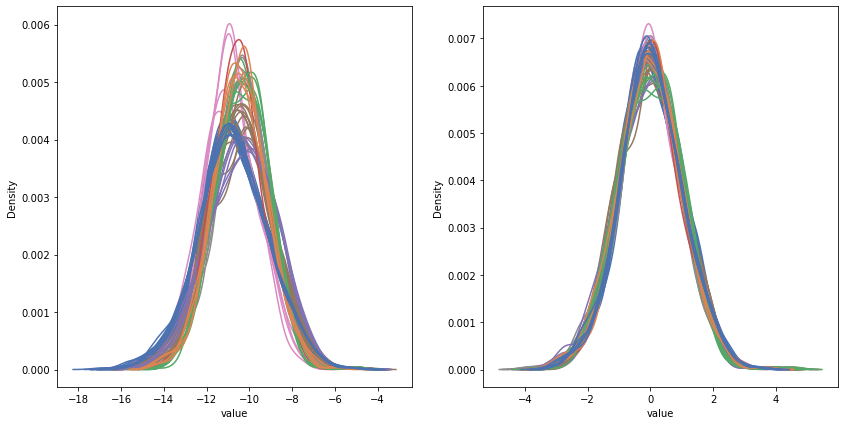

In [185]:
fig,ax=plt.subplots(1,2, figsize=(14,7))

sns.kdeplot(np.log2(reocurring_nsaf.T.melt()["value"]), hue=scaled_reocur_nsaf.T.melt()["variable"], legend=False, palette=list(cols), ax=ax[0])
sns.kdeplot(scaled_reocur_nsaf.T.melt()["value"], hue=scaled_reocur_nsaf.T.melt()["variable"], legend=False, palette=list(cols), ax=ax[1])

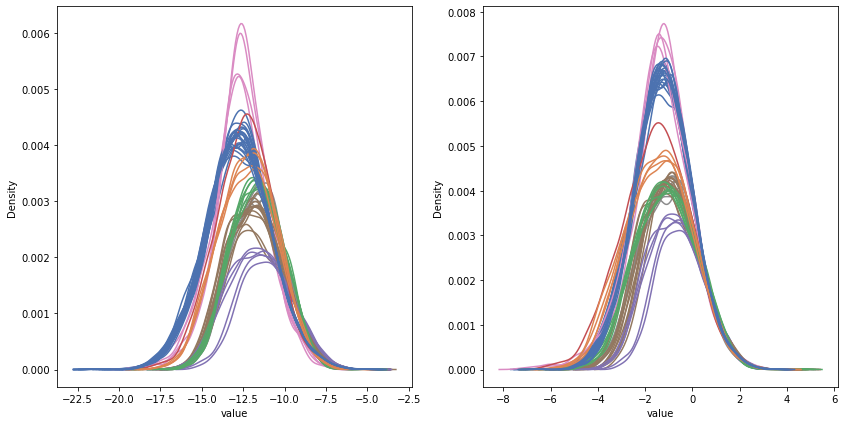

In [198]:
hela_nsaf_ = uml.FilterByOccurence(.5).fit_transform(hela_nsaf)
fig, ax = plt.subplots(1,2, figsize=(14,7))
sns.kdeplot(np.log2(hela_nsaf_.T.melt()["value"]), hue=hela_nsaf_.T.melt()["assay_id"], legend=False, palette=list(cols), ax=ax[0])
sns.kdeplot(scaled_nsaf.loc[:,hela_nsaf_.columns].T.melt()["value"], hue=scaled_nsaf.loc[:,hela_nsaf_.columns].T.melt()["variable"], legend=False, palette=list(cols), ax=ax[1])

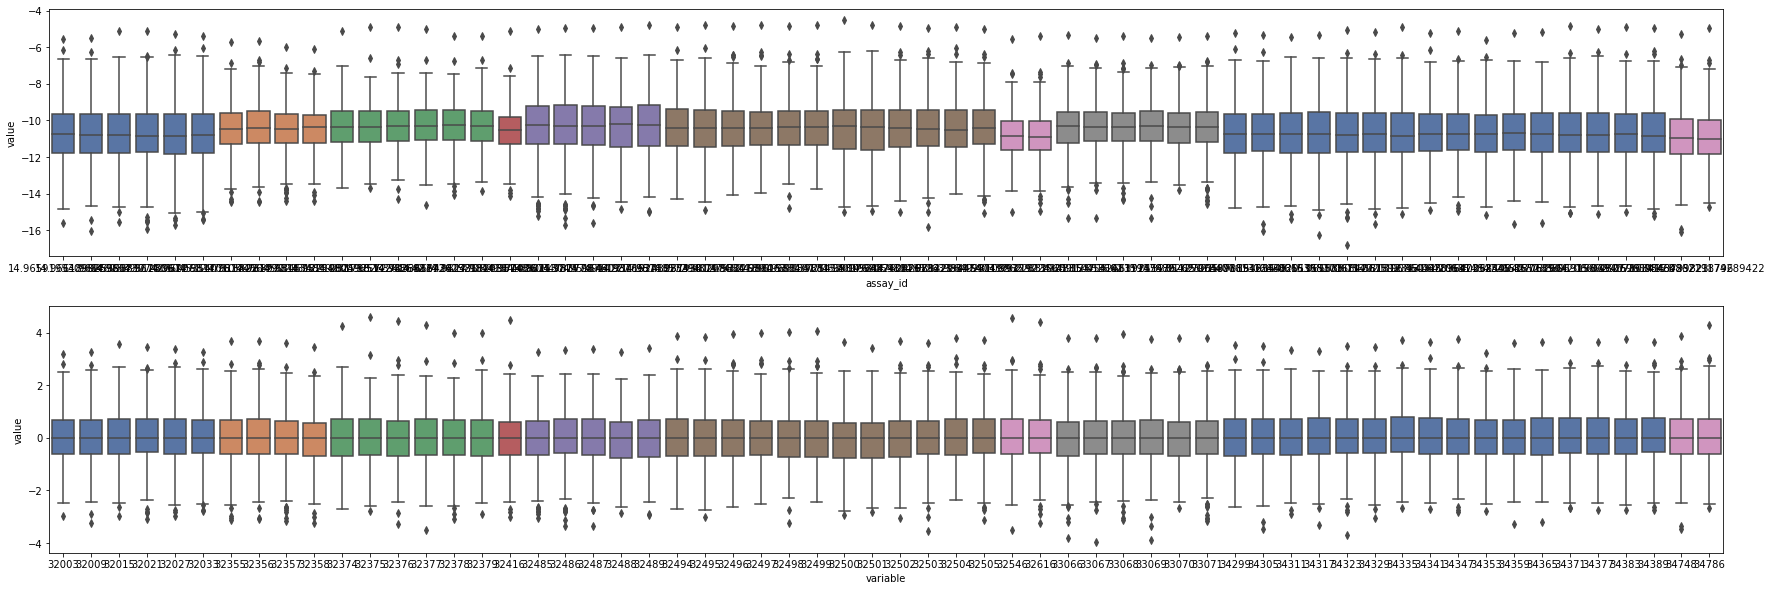

In [192]:
fig, ax=plt.subplots(2,1,figsize=(30,10))
sns.boxplot(data=np.log2(reocurring_nsaf.T.melt().dropna()), y='value', x="assay_id", palette=cols, ax=ax[0])
sns.boxplot(data=scaled_reocur_nsaf.T.melt().dropna(), y='value', x="variable", palette=cols, ax=ax[1])

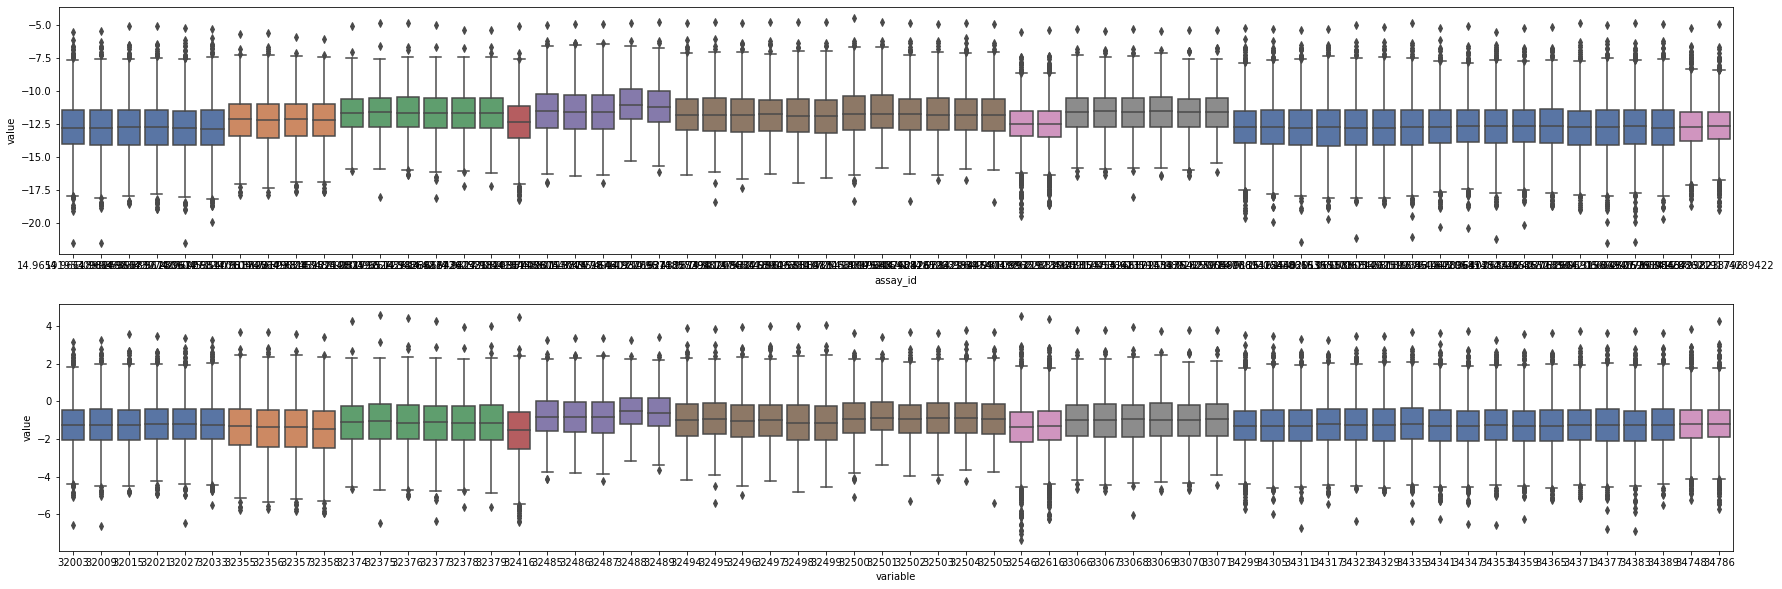

In [196]:
fig, ax=plt.subplots(2,1,figsize=(30,10))
sns.boxplot(data=np.log2(hela_nsaf_.T.melt().dropna()), y='value', x="assay_id", palette=cols, ax=ax[0])
sns.boxplot(data=scaled_nsaf.loc[:,hela_nsaf_.columns].T.melt().dropna(), y='value', x="variable", palette=cols, ax=ax[1])

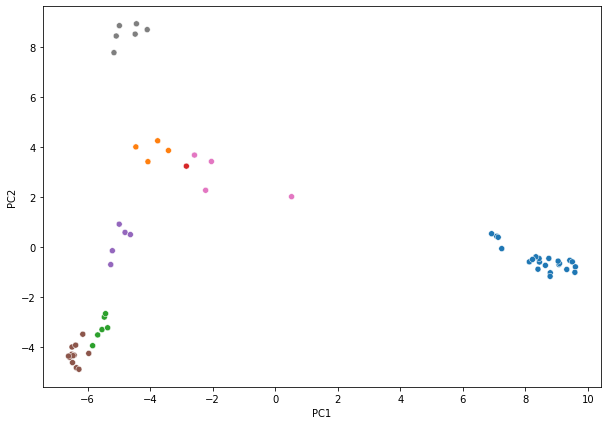

In [194]:
plt.figure(figsize=(10,7))
embedding = PCA(n_components=2).fit_transform(scaled_reocur_nsaf)
sns.scatterplot(data=pd.DataFrame(embedding, index= reocurring_nsaf.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=cols, legend=False)

32009:	common prots: 3850	medianFC: 1.0020442869257993	stdFC: 0.04313742733113608
32015:	common prots: 3773	medianFC: 1.0095918957861507	stdFC: 0.04935237724566373
32021:	common prots: 3756	medianFC: 1.0077976307176353	stdFC: 0.04915346896716689
32027:	common prots: 3808	medianFC: 1.0019142136981145	stdFC: 0.051369473841860046
32033:	common prots: 3657	medianFC: 1.0010526499594457	stdFC: 0.05861120016460283
32355:	common prots: 2266	medianFC: 1.0249835824314353	stdFC: 0.13234165720024993
32356:	common prots: 2192	medianFC: 1.0260810155478806	stdFC: 0.13174876605394392
32357:	common prots: 2339	medianFC: 1.0262331486855347	stdFC: 0.12958397582176334
32358:	common prots: 2353	medianFC: 1.0302930608335237	stdFC: 0.12782895385571677
32374:	common prots: 1746	medianFC: 1.052450670620929	stdFC: 0.13954699720444774
32375:	common prots: 1723	medianFC: 1.0520291096039553	stdFC: 0.13850859899699483
32376:	common prots: 1694	medianFC: 1.0497215041954604	stdFC: 0.14017207397721587
32377:	common pr

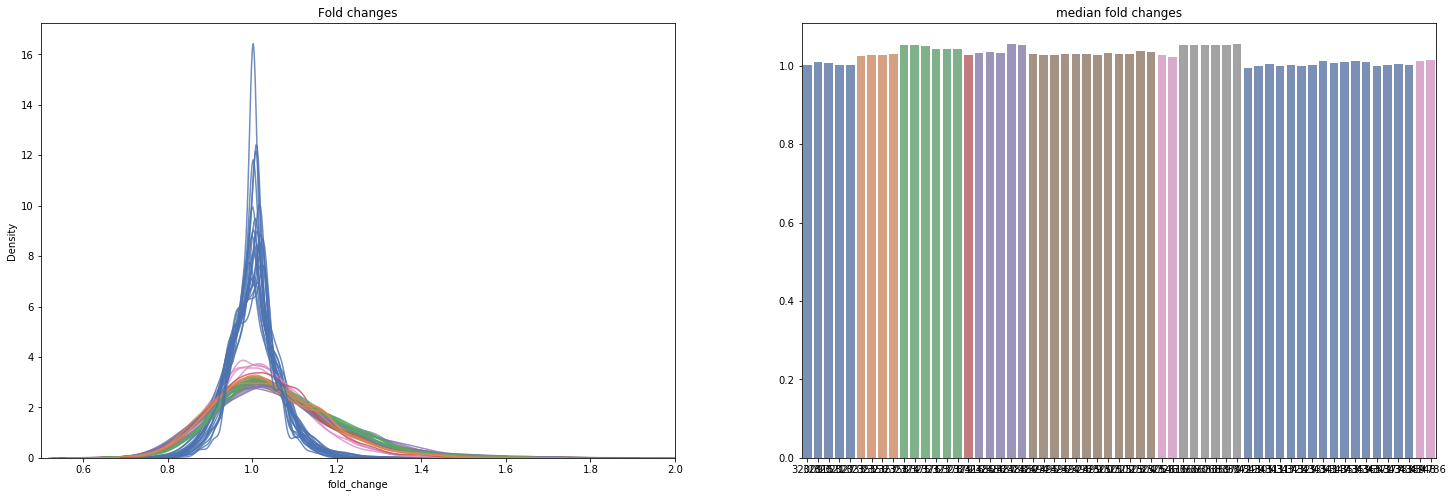

In [129]:
plot_fc(np.log2(hela_nsaf).fillna(0), plot_med_fc = True, color_scheme=list(cols)[1:],xlims=(0.5,2))

32009:	common prots: 3850	medianFC: 1.00035548522442	stdFC: 0.02929333143527774
32015:	common prots: 3773	medianFC: 1.0029549542686056	stdFC: 0.033377610787812886
32021:	common prots: 3756	medianFC: 1.0096357324205472	stdFC: 0.03321898803934039
32027:	common prots: 3808	medianFC: 1.0058486206349926	stdFC: 0.03466722302020665
32033:	common prots: 3657	medianFC: 1.006115364242984	stdFC: 0.039197849445832024
32355:	common prots: 2266	medianFC: 0.9812648676313855	stdFC: 0.0882243061880123
32356:	common prots: 2192	medianFC: 0.9796556353309525	stdFC: 0.08755288533769896
32357:	common prots: 2339	medianFC: 0.9787547992408652	stdFC: 0.08761864502854677
32358:	common prots: 2353	medianFC: 0.9747762127330667	stdFC: 0.08577223144159868
32374:	common prots: 1746	medianFC: 0.9924131661028532	stdFC: 0.09013424803217379
32375:	common prots: 1723	medianFC: 0.9912988126916078	stdFC: 0.09096626805174152
32376:	common prots: 1694	medianFC: 0.9886905163216702	stdFC: 0.0903234203103553
32377:	common prots

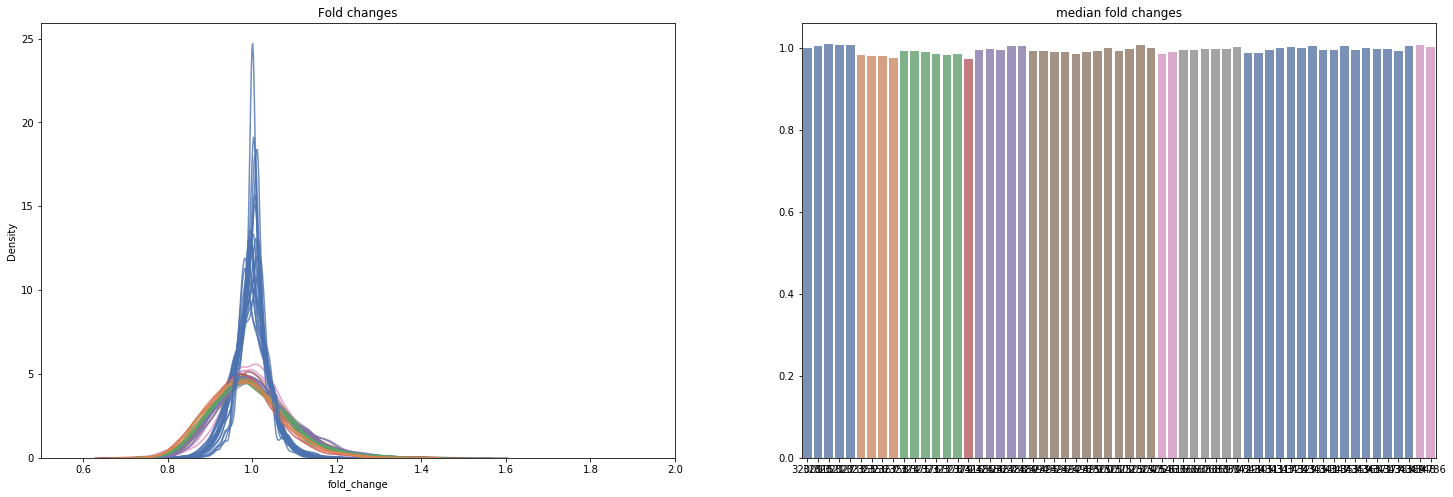

In [130]:
plot_fc(scaled_nsaf.fillna(0), plot_med_fc = True, color_scheme=list(cols)[1:],xlims=(0.5,2))

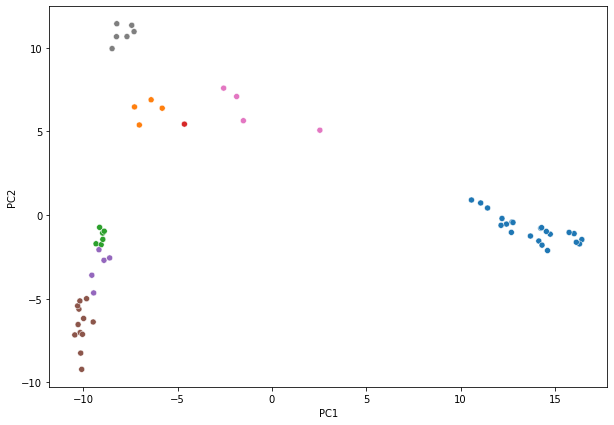

In [48]:
plt.figure(figsize=(10,7))
embedding = PCA(n_components=2).fit_transform(np.log2(reocurring_nsaf))
sns.scatterplot(data=pd.DataFrame(embedding, index= reocurring_nsaf.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=cols, legend=False)

32009:	common prots: 465	medianFC: 1.0008227274438577	stdFC: 0.02362938208487509
32015:	common prots: 465	medianFC: 1.0010869870225096	stdFC: 0.03215140744194925
32021:	common prots: 465	medianFC: 1.0005149540427694	stdFC: 0.029989983943165245
32027:	common prots: 465	medianFC: 0.9989021149288889	stdFC: 0.03413232324958835
32033:	common prots: 465	medianFC: 1.0001324372748344	stdFC: 0.03958639683855545
32355:	common prots: 465	medianFC: 1.025626703400825	stdFC: 0.12336748321929963
32356:	common prots: 465	medianFC: 1.0332609032044113	stdFC: 0.12485119423901149
32357:	common prots: 465	medianFC: 1.0247047245314844	stdFC: 0.12512168180498118
32358:	common prots: 465	medianFC: 1.0244814255674934	stdFC: 0.12024156133309638
32374:	common prots: 465	medianFC: 1.0316458407703475	stdFC: 0.1310554490627714
32375:	common prots: 465	medianFC: 1.0274322414515924	stdFC: 0.12966769643439835
32376:	common prots: 465	medianFC: 1.02489479694233	stdFC: 0.13035144692341297
32377:	common prots: 465	median

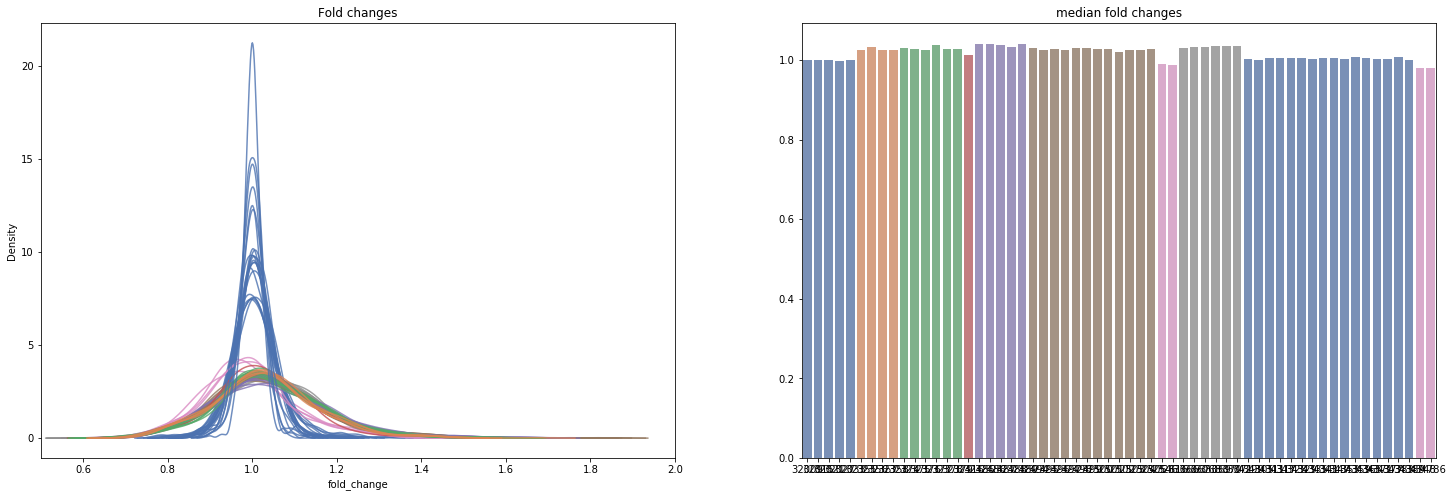

In [54]:
plot_fc(np.log2(reocurring_nsaf), plot_med_fc = True, color_scheme=list(cols)[1:],xlims=(0.5,2))

In [59]:
normed_nsaf = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col="assay_id")

In [62]:
reocur_normed_nsaf = normed_nsaf.loc[reocurring_nsaf.index,reocurring_nsaf.columns]

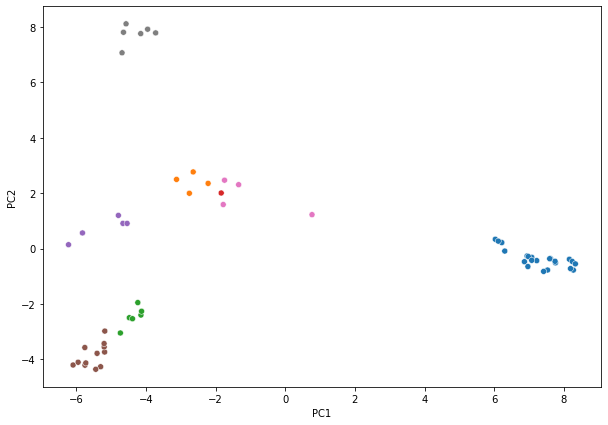

In [63]:
plt.figure(figsize=(10,7))
embedding = PCA(n_components=2).fit_transform(reocur_normed_nsaf)
sns.scatterplot(data=pd.DataFrame(embedding, index= reocurring_nsaf.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=cols, legend=False)

32009:	common prots: 3850	medianFC: 1.0094902521099356	stdFC: 0.2489911651045727
32015:	common prots: 3773	medianFC: 0.9963852423782139	stdFC: 0.2900758627120501
32021:	common prots: 3756	medianFC: 0.9734127858824941	stdFC: 0.2813883518045078
32027:	common prots: 3808	medianFC: 0.9770219141272467	stdFC: 0.29193745952756656
32033:	common prots: 3657	medianFC: 0.9786288816755615	stdFC: 0.3457438925194872
32355:	common prots: 2266	medianFC: 1.0664788592091905	stdFC: 0.7997452619424651
32356:	common prots: 2192	medianFC: 1.0366482650430076	stdFC: 0.7721527819872296
32357:	common prots: 2339	medianFC: 1.0631668870369506	stdFC: 0.7935282367214282
32358:	common prots: 2353	medianFC: 1.0510899904564255	stdFC: 0.8000333499830556
32374:	common prots: 1746	medianFC: 1.0610944845564254	stdFC: 0.7908998815912434
32375:	common prots: 1723	medianFC: 1.0648983972408994	stdFC: 0.7932574957358104
32376:	common prots: 1694	medianFC: 1.0634470572077808	stdFC: 0.7654892122457472
32377:	common prots: 1694	m

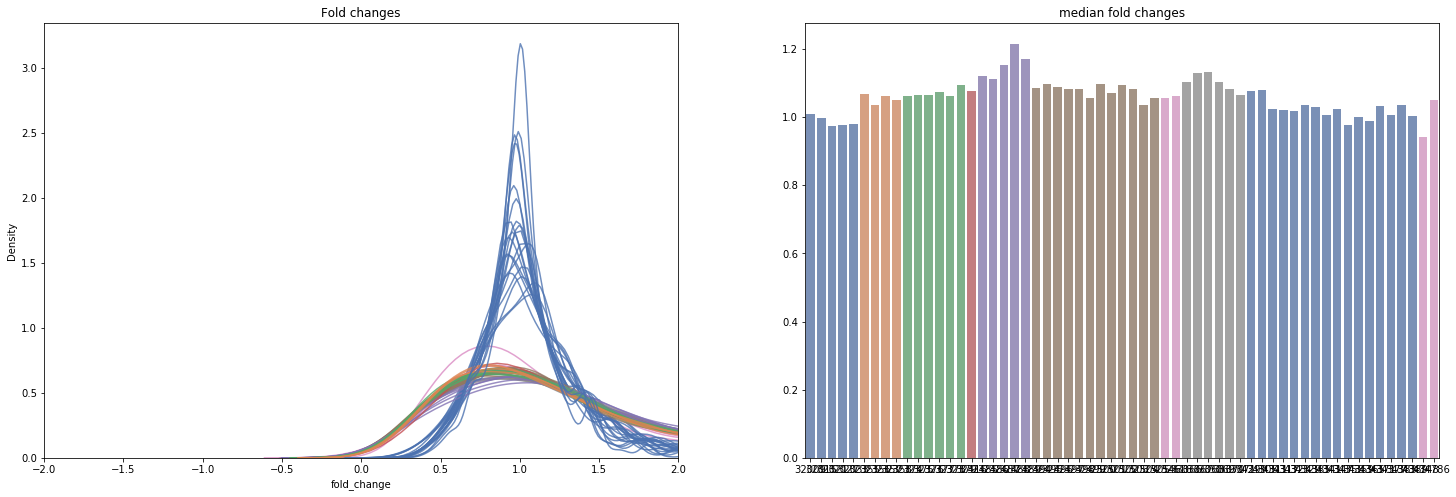

In [71]:
plot_fc(np.exp2(normed_nsaf.loc[reocurring_nsaf.index]).fillna(0), plot_med_fc = True, color_scheme=list(cols)[1:])

In [183]:
most_abundant_prot = []
for i, x in hela_nsaf.iterrows():
    most_abundant_prot.append(x.idxmax())

In [185]:
set(most_abundant_prot)

{'P62805'}

In [17]:
hela_protein_ids = hela_nsaf.notna().sum(axis=1)

In [43]:
all_ided = nsaf_filtered.dropna(axis=1).columns

In [57]:
(nsaf_filtered.notna().sum()>500).index

Index(['A0A024RBG1', 'A0A075B6X5', 'A0A075B767', 'A0A087WV62', 'A0A087X0K7',
       'A0A096LP01', 'A0A096LP49', 'A0A096LP55', 'A0A0A6YYK6', 'A0A0A6YYK7',
       ...
       'Q9Y6X5', 'Q9Y6X8', 'Q9Y6X9', 'Q9Y6Y0', 'Q9Y6Y1', 'Q9Y6Y8', 'Q9Y6Y9',
       'Q9Y6Z5', 'Q9Y6Z7', 'W5XKT8'],
      dtype='object', name='uniprot_id', length=14507)

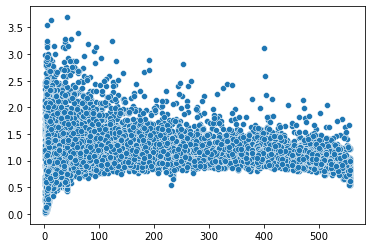

In [52]:
sns.scatterplot(x=nsaf_filtered.notna().sum(), y=np.log2(nsaf_filtered).std())

In [63]:
nsaf_filtered.columns[(nsaf_filtered.notna().sum()>500)]

Index(['A0AVT1', 'A5YKK6', 'A6NDG6', 'O00148', 'O00151', 'O00154', 'O00170',
       'O00186', 'O00203', 'O00231',
       ...
       'Q9Y5K6', 'Q9Y5L4', 'Q9Y5S9', 'Q9Y617', 'Q9Y678', 'Q9Y696', 'Q9Y6C9',
       'Q9Y6I3', 'Q9Y6W5', 'Q9Y6Y8'],
      dtype='object', name='uniprot_id', length=660)

In [125]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

import json
with open("../ML/GO_F_uniprot_map.json", 'r') as f:
    uniprot_go_function = json.load(f)

GO_description = pd.read_csv("../annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

connection succesfull


In [112]:
lowest_std = np.log2(nsaf_filtered.loc[:,nsaf_filtered.columns[(nsaf_filtered.notna().sum()>500)]]).std().sort_values().reset_index()
lowest_std[:20]

uniprot_id         0
0      P50990  0.537979
1      Q99832  0.542542
2      P42704  0.547460
3      P13010  0.551291
4      Q7KZF4  0.555907
5      P49411  0.579728
6      P50991  0.583734
7      P53618  0.588867
8      O00231  0.594729
9      P53396  0.605474
10     Q9Y3I0  0.611755
11     Q8WUM4  0.611864
12     Q9UQ80  0.625546
13     P54136  0.629497
14     O76094  0.651231
15     Q14152  0.653417
16     Q13200  0.658548
17     P34932  0.659077
18     P22314  0.665607
19     P26196  0.667193

In [111]:
uniprot_description.loc[lowest_std[:20].loc[:,"uniprot_id"]]

description
uniprot_id                                                   
P50990                     T-complex protein 1 subunit theta 
Q99832                       T-complex protein 1 subunit eta 
P42704      Leucine-rich PPR motif-containing protein, mit...
P13010            X-ray repair cross-complementing protein 5 
Q7KZF4      Staphylococcal nuclease domain-containing prot...
P49411                   Elongation factor Tu, mitochondrial 
P50991                     T-complex protein 1 subunit delta 
P53618                                 Coatomer subunit beta 
O00231       26S proteasome non-ATPase regulatory subunit 11 
P53396                                  ATP-citrate synthase 
Q9Y3I0                      RNA-splicing ligase RtcB homolog 
Q8WUM4           Programmed cell death 6-interacting protein 
Q9UQ80                  Proliferation-associated protein 2G4 
P54136                    Arginine--tRNA ligase, cytoplasmic 
O76094             Signal recognition particle subunit SRP72 
Q14152      Eukaryotic translation initiation factor 3 sub...
Q13200        26S proteasome non-ATPase regulatory subunit 2 
P34932                           Heat shock 70 kDa protein 4 
P22314           Ubiquitin-like modifier-activating enzyme 1 
P26196              Probable ATP-dependent RNA helicase DDX6

In [136]:
GO_low_variable_prot = {}

for i, prot in enumerate(lowest_std.uniprot_id):
    for go in uniprot_go_function[prot]:
        if go not in GO_low_variable_prot.keys():
            GO_low_variable_prot[go] = np.array([1])
        else:
            GO_low_variable_prot[go] += 1
    if i == 9:
        break

In [137]:
mapper = {}
for go in GO_low_variable_prot.keys():
    if go in GO_description.index:
        mapper[go] = GO_description.loc[go].annotation_label

In [139]:
GO_low_variable_prot = pd.DataFrame(data=GO_low_variable_prot)
GO_low_variable_prot.T.rename(index=mapper).sort_values(by=0,ascending=False)[:10]

0
protein binding                          10
ATP binding                               5
RNA binding                               5
ATP hydrolysis activity                   4
protein folding chaperone                 3
ATP-dependent protein folding chaperone   3
unfolded protein binding                  3
structural molecule activity              2
ubiquitin protein ligase binding          2
cadherin binding                          2

Text(0, 0.5, 'Standard deviation')

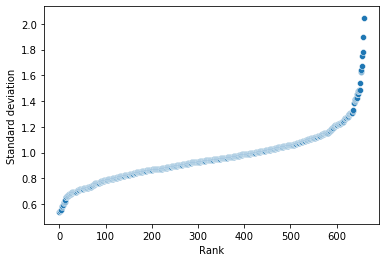

In [103]:
sns.scatterplot(data=lowest_std, x=lowest_std.index, y=0)
plt.xlabel("Rank")
plt.ylabel("Standard deviation")

In [94]:
np.log2(nsaf_filtered).min(axis=1).mean()

-18.527838313883016

In [95]:
np.log2(nsaf_filtered).max(axis=1).mean()

-5.500663019239492

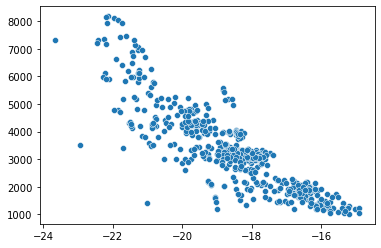

In [170]:
sns.scatterplot(x=np.log2(nsaf_filtered).min(axis=1),y=nsaf_filtered.notna().sum(axis=1))

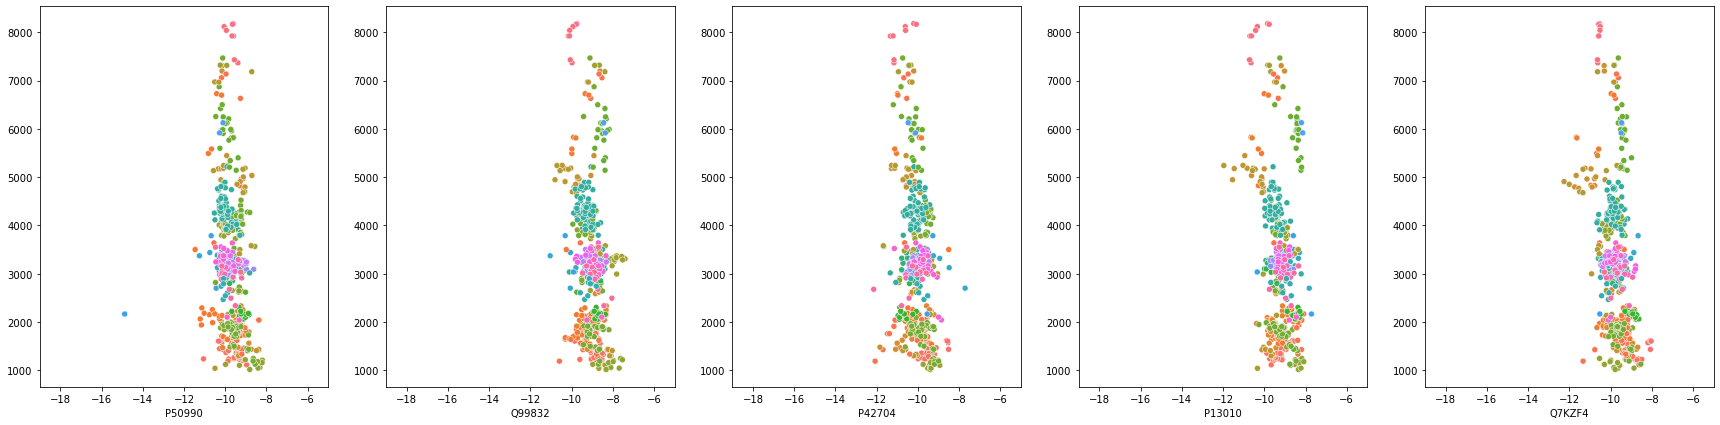

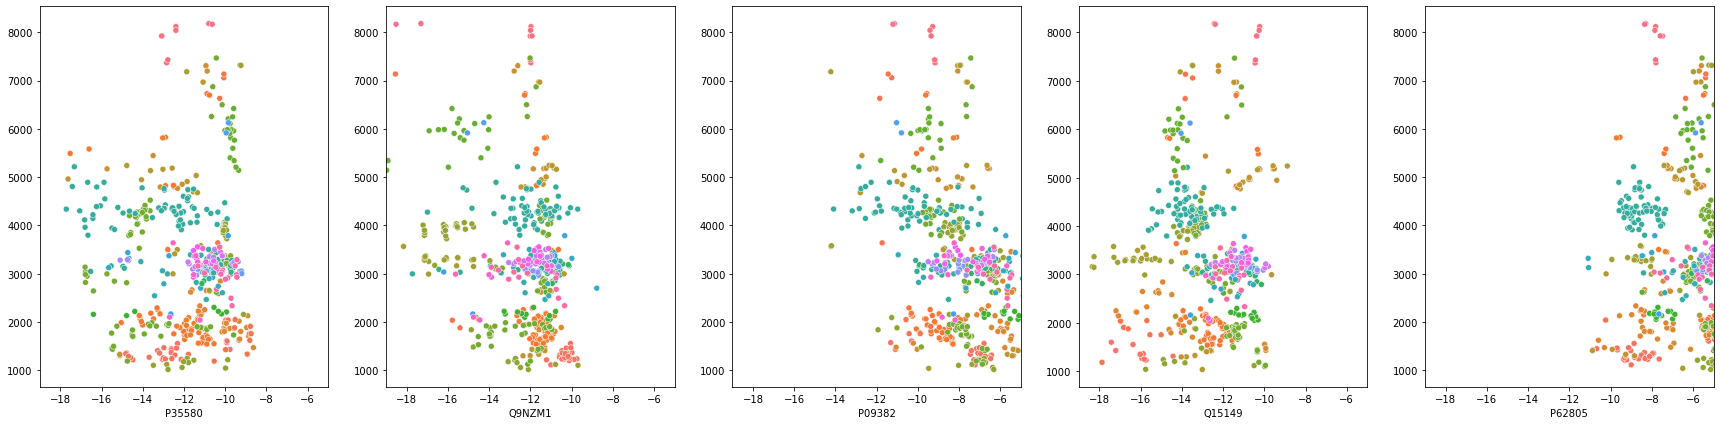

In [99]:
fig, ax = plt.subplots(1,5, figsize=(30,7))
for i, axi in enumerate(ax):
    axi.set_xlim((-19,-5))
    sns.scatterplot(x=np.log2(nsaf_filtered.loc[:, lowest_std.loc[i].uniprot_id]), y = nsaf_filtered.notna().sum(axis=1), ax=axi, hue=meta.cell_line, legend=False)

fig, ax = plt.subplots(1,5, figsize=(30,7))
for i, axi in enumerate(ax):
    axi.set_xlim((-19,-5))
    sns.scatterplot(x=np.log2(nsaf_filtered.loc[:, lowest_std.loc[len(lowest_std)-1-i].uniprot_id]), y = nsaf_filtered.notna().sum(axis=1), ax=axi, hue=meta.cell_line, legend=False)

(-15, -5)

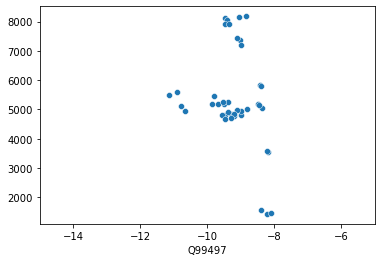

In [106]:
sns.scatterplot(x = np.log2(nsaf_filtered.loc[:,"Q99497"].dropna(axis=0)), y = nsaf_filtered.loc[nsaf_filtered.loc[:,"Q99497"].dropna(axis=0).index,:].notna().sum(axis=1))
plt.xlim((-15,-5))

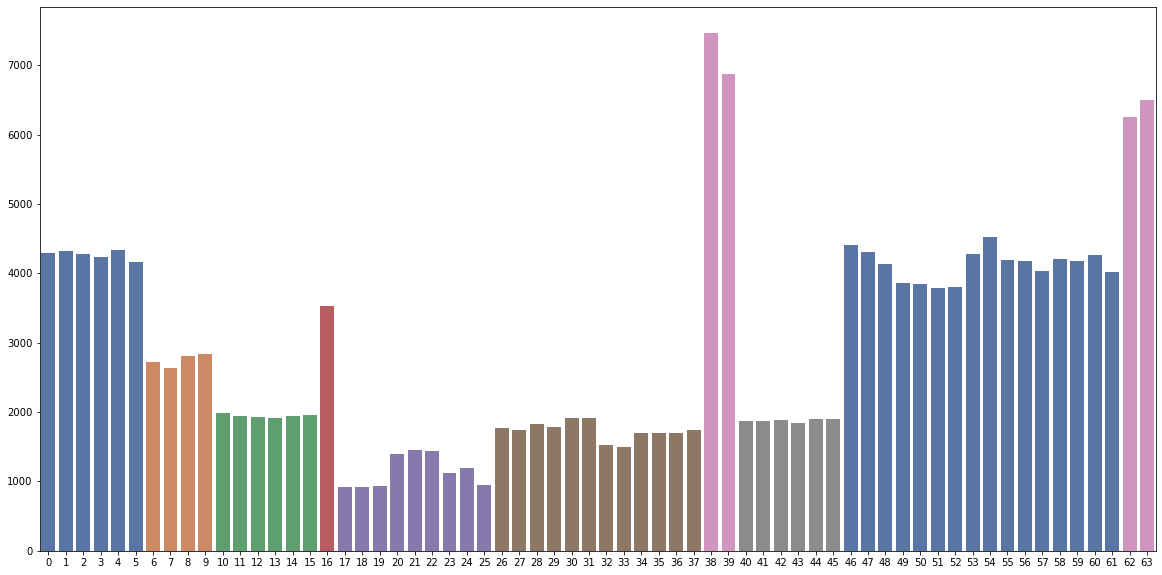

In [72]:
plt.figure(figsize=(20,10))

cols = hela_meta_.PXD_accession.apply(lambda x: lut[x])

sns.barplot(x=list(range(len(hela_nsaf_))), y=hela_nsaf_.notna().sum(axis=1), palette=cols)

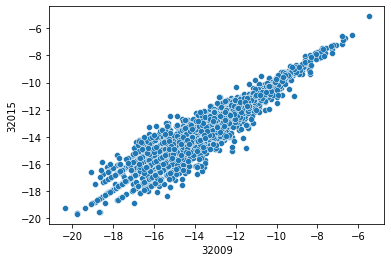

In [97]:
# Plot of 2 samples showing correlation of proteins, the one with largest abundance is P62805
sns.scatterplot(data=np.log2(hela_nsaf.iloc[[1,2],:].T.dropna()), x=32009,y=32015)

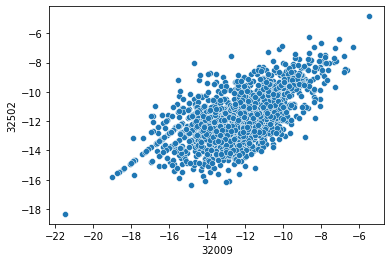

In [149]:
sns.scatterplot(data=np.log2(hela_nsaf.iloc[[1,30],:].T.dropna()), x=32009,y=32502	)

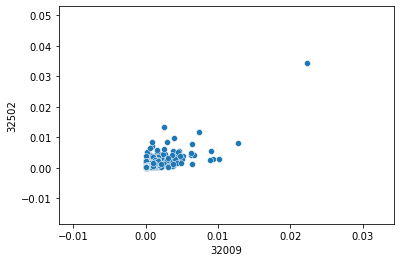

In [150]:
sns.scatterplot(data=hela_nsaf.iloc[[1,30],:].T.dropna(), x=32009,y=32502)

In [17]:
from itertools import combinations

In [119]:
ids = [32003, 32009]

In [124]:
stats.pearsonr(x=hela_nsaf.loc[ids,:].T.dropna().iloc[:,0], y=hela_nsaf.loc[ids,:].T.dropna().iloc[:,1])

(0.9935562268972714, 0.0)

In [74]:
def calculate_correlations(dataset, assay_ids):
    
    correlation_assays = {pxd :[] for pxd in meta.loc[assay_ids].PXD_accession.unique()}
    across_project_corr = {}
    dataset = dataset
    
    comparisons = combinations(assay_ids, 2)

    for comparison in comparisons:
        id1 = comparison[0]
        id2 = comparison[1]

        comp_df = dataset.loc[[id1,id2], :].T.dropna()

        r = stats.pearsonr(x=comp_df.loc[:,id1], y=comp_df.loc[:,id2])[0]

        pxd1 = meta.loc[id1].PXD_accession
        pxd2 = meta.loc[id2].PXD_accession
        if pxd1 == pxd2:
            correlation_assays[meta.loc[id1].PXD_accession].append(r)
        
        elif str(pxd1)+"-"+str(pxd2) in across_project_corr.keys():
            across_project_corr[str(pxd1)+"-"+str(pxd2)].append(r)

        elif str(pxd2)+"-"+str(pxd1) in across_project_corr.keys():
            across_project_corr[str(pxd2)+"-"+str(pxd1)].append(r)
        else:
            across_project_corr[str(pxd1)+"-"+str(pxd2)] = [r]

    return correlation_assays, across_project_corr

PXD000612 0.9166484773691737
PXD004182 0.8994014156457263
PXD004940 0.8778812822930502
PXD001441 nan
PXD003530 0.8844252355688067
PXD006112 0.8869805737654365
PXD004452 0.6836396155023713
PXD004900 0.9106111584429193
PXD000612 0.9166484773691737
PXD004182 0.8994014156457261
PXD004940 0.8778812822930501
PXD001441 nan
PXD003530 0.8844252355688067
PXD006112 0.8869805737654366
PXD004452 0.6836396155023713
PXD004900 0.9106111584429194


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


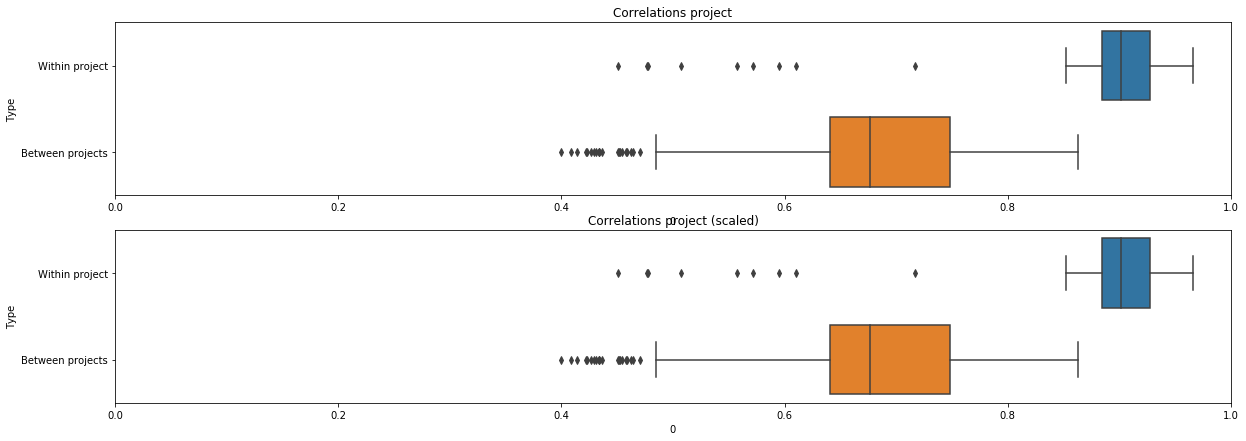

In [39]:
within_corr, between_corr = calculate_correlations(np.log2(hela_nsaf), hela_assays)
within_corr_sca, between_corr_sca = calculate_correlations(scaled_nsaf, hela_assays)

all_within_corr = []
for px, x in within_corr.items():
    all_within_corr+=x
    print(px, np.mean(x))

all_between_corr = []
for x in between_corr.values():
    all_between_corr += x

all_within_corr_sca = []
for px, x in within_corr_sca.items():
    all_within_corr_sca+=x
    print(px, np.mean(x))

all_between_corr_sca = []
for x in between_corr_sca.values():
    all_between_corr_sca += x

fig, ax = plt.subplots(2,1, figsize=(20,7))

ax[0].set_title("Correlations project")
ax[0].set_xlim((0,1))
ax[1].set_title("Correlations project (scaled)")
ax[1].set_xlim((0,1))

all_within = pd.DataFrame(data=all_within_corr)
all_within["Type"] = "Within project"
all_between = pd.DataFrame(data=all_between_corr)
all_between["Type"] = "Between projects"
corr_df = pd.concat([all_within,all_between])

all_within_sca = pd.DataFrame(data=all_within_corr_sca)
all_within_sca["Type"] = "Within project"
all_between_sca = pd.DataFrame(data=all_between_corr_sca)
all_between_sca["Type"] = "Between projects"
corr_df_sca = pd.concat([all_within_sca,all_between_sca])

sns.boxplot(data=corr_df,x=0, y="Type", ax=ax[0])
sns.boxplot(data=corr_df_sca,x=0, y="Type", ax=ax[1])

PXD008719 0.9102307222725587
PXD001352 0.7687275040223137
PXD007543 0.7402200597680572
PXD005940 nan
PXD004452 0.953368608792802


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


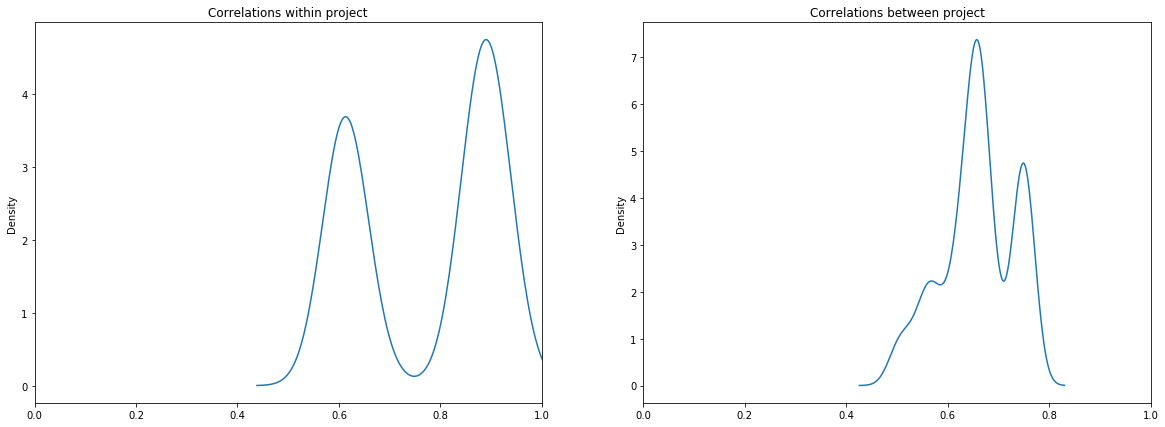

In [158]:
MCF7_assays = meta[meta.cell_line == "MCF7"].index
MCF7_nsaf = nsaf.loc[MCF7_assays,:]

within_corr, between_corr = calculate_correlations(MCF7_nsaf, MCF7_assays)

all_within_corr = []
for px, x in within_corr.items():
    all_within_corr+=x
    print(px, np.mean(x))

all_between_corr = []
for x in between_corr.values():
    all_between_corr += x

fig, ax = plt.subplots(1,2, figsize=(20,7))

ax[0].set_title("Correlations within project")
ax[1].set_title("Correlations between project")

ax[0].set_xlim((0,1))
ax[1].set_xlim((0,1))
sns.kdeplot(all_within_corr, ax=ax[0])
sns.kdeplot(all_between_corr, ax=ax[1])

In [197]:
meta[meta.PXD_accession == "PXD001352"]

project_id                    filename  cell_id cell_line  \
assay_id                                                              
31350           1827  20121023_EXQ4_JRW_SA_30L_1      563    HCT116   
31351           1827  20121023_EXQ4_JRW_SA_30L_2      563    HCT116   
31352           1827  20121023_EXQ4_JRW_SA_30T_1      563    HCT116   
31353           1827   20140127_EXQ4_JRW_D52_1_L      551      MCF7   
31354           1827   20140127_EXQ4_JRW_D52_1_T      551      MCF7   
31355           1827   20140127_EXQ4_JRW_D52_2_L      551      MCF7   
31356           1827   20140127_EXQ4_JRW_D52_2_T      551      MCF7   
31357           1827   20140127_EXQ4_JRW_D61_1_L      564      K562   
31358           1827   20140127_EXQ4_JRW_D61_1_T      564      K562   
31359           1827   20140127_EXQ4_JRW_D61_2_L      564      K562   

                   disease treatment tissue_type sub_cell  organ_id  \
assay_id                                                              
31350            carcinoma         /       colon        /       NaN   
31351            carcinoma         /       colon        /       NaN   
31352            carcinoma         /       colon        /       NaN   
31353       adenocarcinoma         /      breast        /       NaN   
31354       adenocarcinoma         /      breast        /       NaN   
31355       adenocarcinoma         /      breast        /       NaN   
31356       adenocarcinoma         /      breast        /       NaN   
31357     myeloid leukemia         /       blood        /       NaN   
31358     myeloid leukemia         /       blood        /       NaN   
31359     myeloid leukemia         /       blood        /       NaN   

         PXD_accession  all_PSM  sign_PSM  peptides  proteins experiment_type  \
assay_id                                                                        
31350        PXD001352    54155     50158     45310      4869            FASP   
31351        PXD001352    53578     49813     45029      4837            FASP   
31352        PXD001352    46575     41562     37168      5256            FASP   
31353        PXD001352    57119     53559     47775      4903            FASP   
31354        PXD001352    55718     49619     43721      5586            FASP   
31355        PXD001352    57190     53611     47886      4891            FASP   
31356        PXD001352    58739     51984     46037      5669            FASP   
31357        PXD001352    55965     50805     46112      5125            FASP   
31358        PXD001352    56585     49740     44123      5559            FASP   
31359        PXD001352    60189     56236     50271      4866            FASP   

          instrument      pmid  pool_id ionbot_version  
assay_id                                                
31350     Q-exactive  25475432        0  IONBOT_v0.8.0  
31351     Q-exactive  25475432        0  IONBOT_v0.8.0  
31352     Q-exactive  25475432        0  IONBOT_v0.8.0  
31353     Q-exactive  25475432        0  IONBOT_v0.8.0  
31354     Q-exactive  25475432        0  IONBOT_v0.8.0  
31355     Q-exactive  25475432        0  IONBOT_v0.8.0  
31356     Q-exactive  25475432        0  IONBOT_v0.8.0  
31357     Q-exactive  25475432        0  IONBOT_v0.8.0  
31358     Q-exactive  25475432        0  IONBOT_v0.8.0  
31359     Q-exactive  25475432        0  IONBOT_v0.8.0

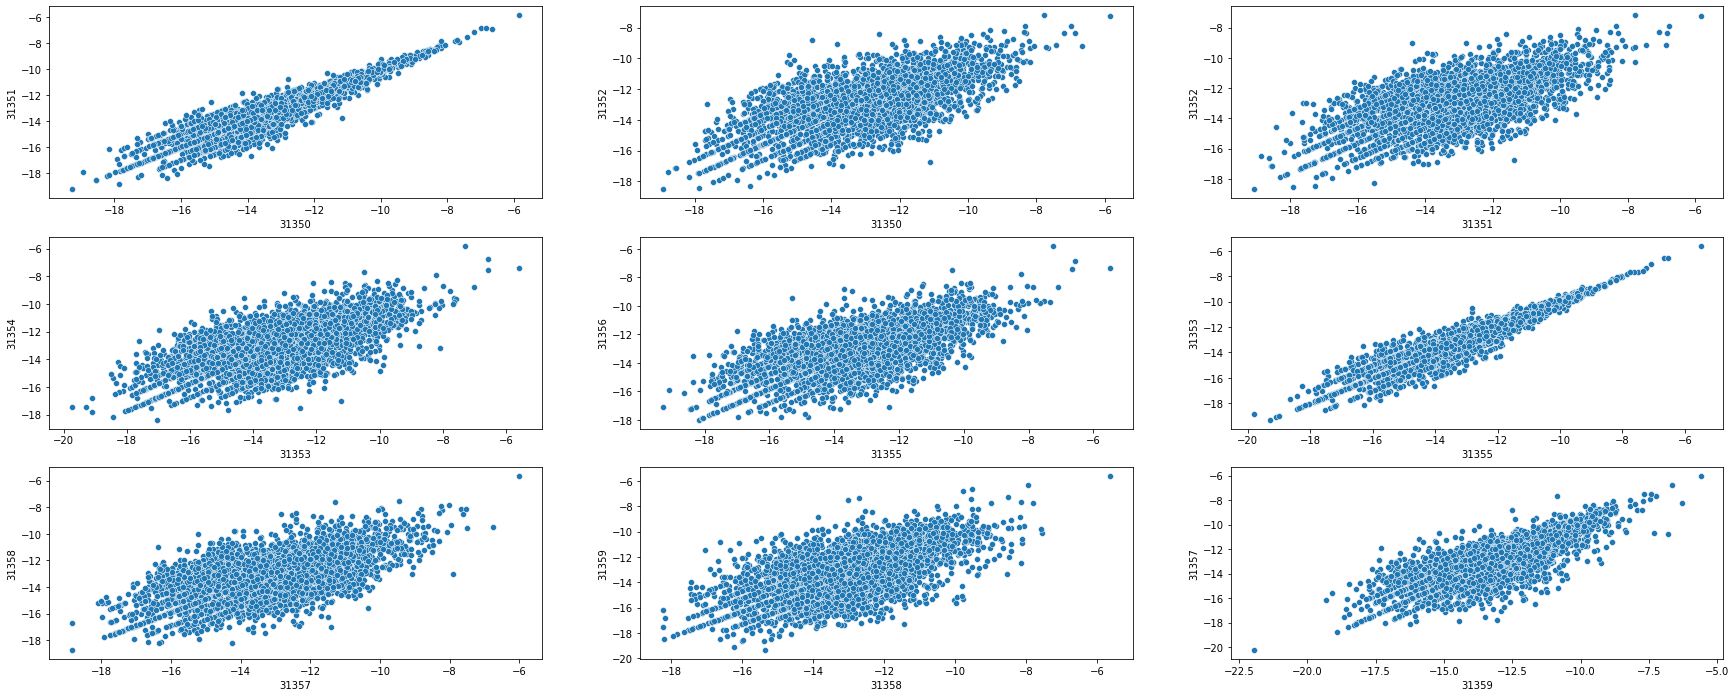

In [208]:
fig, ax = plt.subplots(3,3, figsize=(30,12))

sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31350,31351],:].T.dropna()), x=31350,y=31351, ax=ax[0][0])
sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31350,31352],:].T.dropna()), x=31350,y=31352, ax=ax[0][1])
sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31351,31352],:].T.dropna()), x=31351,y=31352, ax=ax[0][2])

sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31353,31354],:].T.dropna()), x=31353,y=31354, ax=ax[1][0])
sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31355,31356],:].T.dropna()), x=31355,y=31356, ax=ax[1][1])
sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31355,31353],:].T.dropna()), x=31355,y=31353, ax=ax[1][2])

sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31357,31358],:].T.dropna()), x=31357,y=31358, ax=ax[2][0])
sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31358,31359],:].T.dropna()), x=31358,y=31359, ax=ax[2][1])
sns.scatterplot(data=np.log2(nsaf_filtered.loc[[31359,31357],:].T.dropna()), x=31359,y=31357, ax=ax[2][2])

In [16]:
logged_hela_nsaf = np.log2(hela_nsaf)

In [9]:
reoccurring, deleted = uml._identify_global_reoccured_proteins(hela_nsaf.fillna(0), .7)

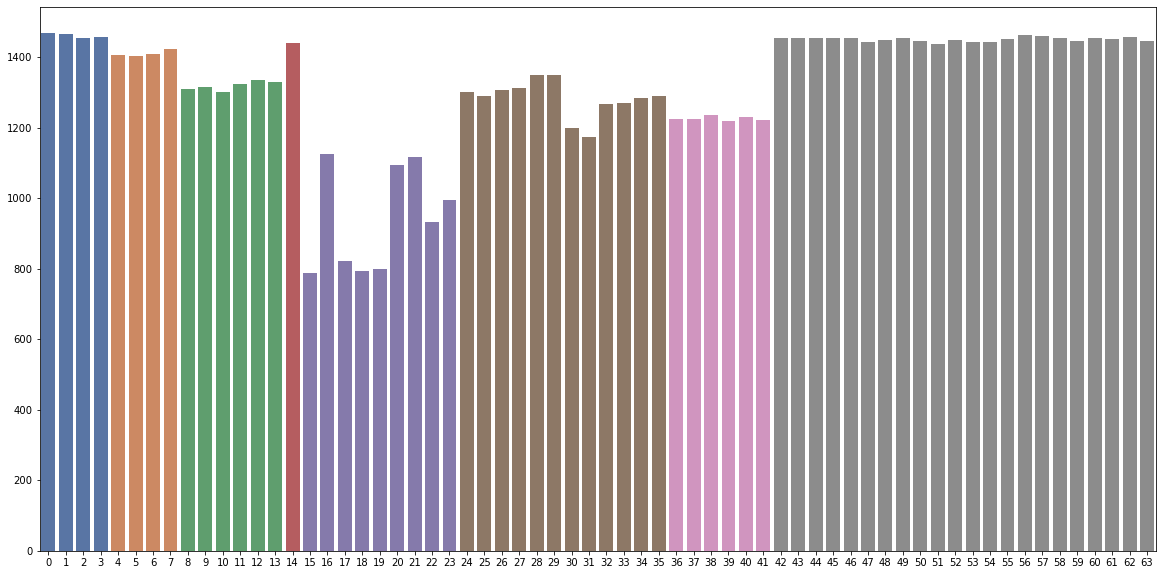

In [17]:
filtered_hela_nsaf = hela_nsaf.loc[:,reoccurring]
filtered_log_hela_nsaf = logged_hela_nsaf.loc[:,reoccurring]

plt.figure(figsize=(20,10))

sns.barplot(x=list(range(len(hela_nsaf))), y=filtered_hela_nsaf.notna().sum(axis=1), palette=cols)

In [11]:
hela_meta.PXD_accession.unique()

array(['PXD004452', 'PXD004182', 'PXD004940', 'PXD001441', 'PXD003530',
       'PXD006112', 'PXD004900', 'PXD000612'], dtype=object)

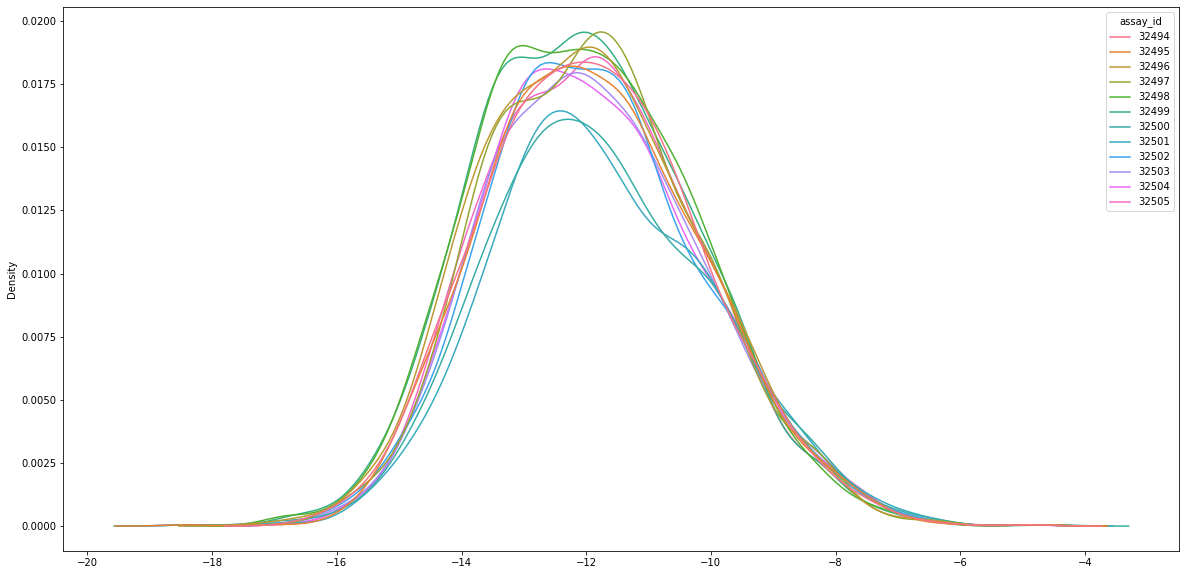

In [56]:
# Plotting the abundance values
plt.figure(figsize=(20,10))
sns.kdeplot(data=np.log2(hela_nsaf.loc[hela_meta[hela_meta.PXD_accession == "PXD006112"].index,:]).transpose())

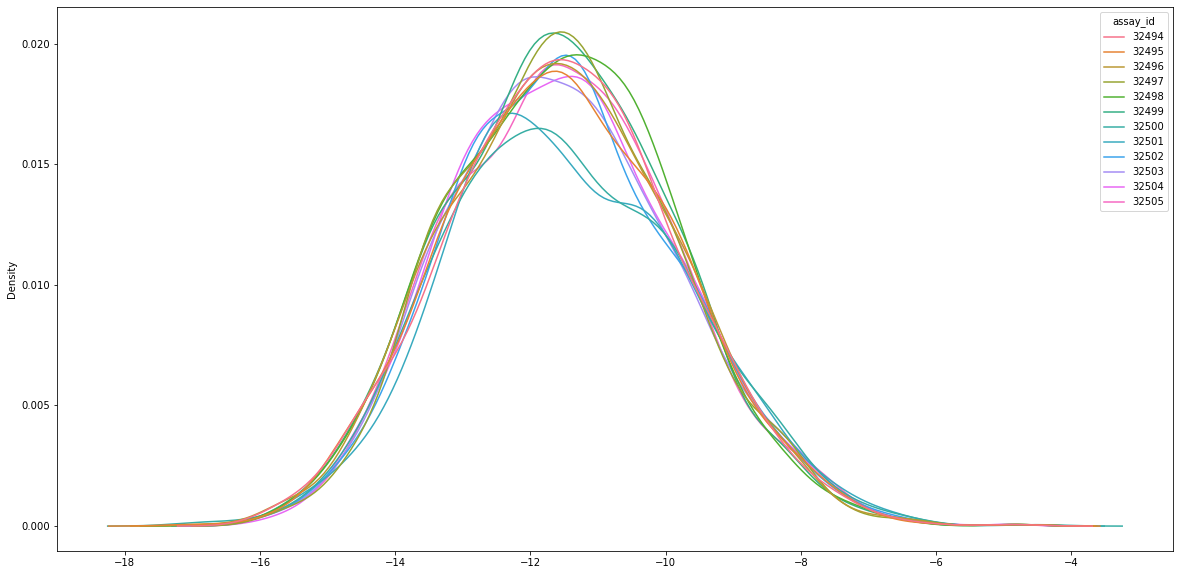

In [28]:
# Plotting the abundance values
plt.figure(figsize=(20,10))
sns.kdeplot(data=np.log2(filtered_hela_nsaf.loc[hela_meta[hela_meta.PXD_accession == "PXD006112"].index,:]).transpose())

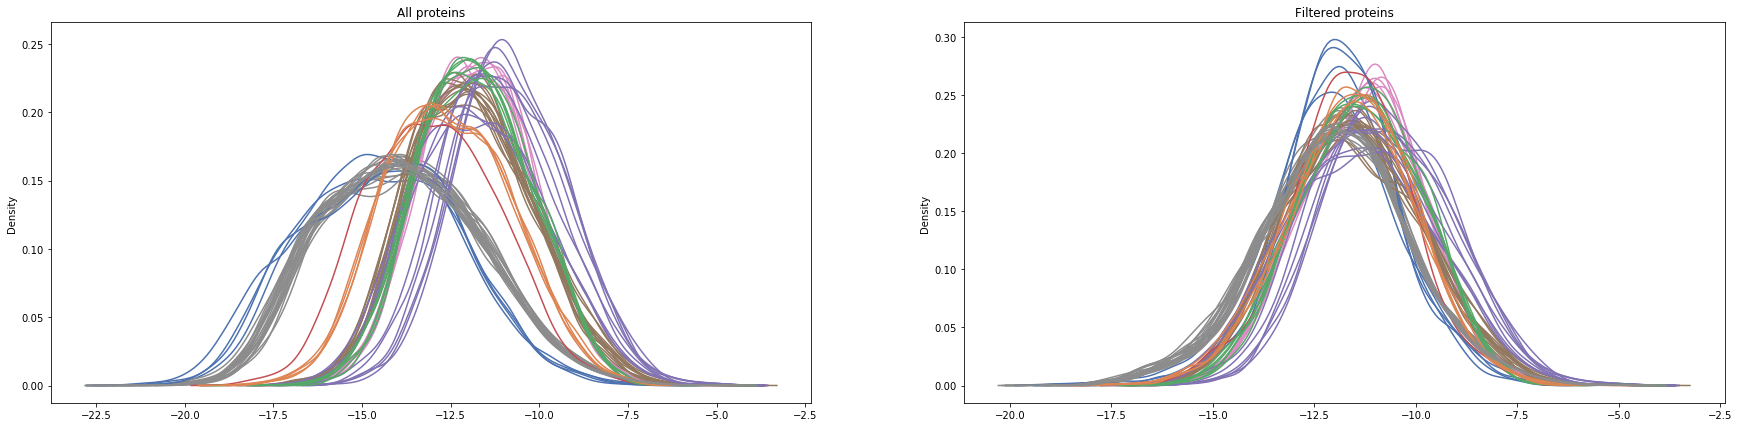

In [61]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=logged_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_log_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

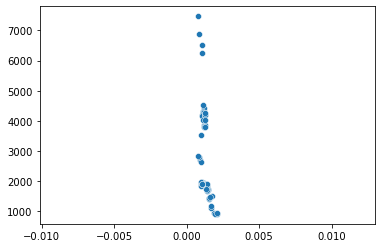

In [35]:
sns.scatterplot(x=filtered_hela_nsaf.iloc[:,:].transpose().std(), y=list(hela_nsaf.notna().sum(axis=1)))

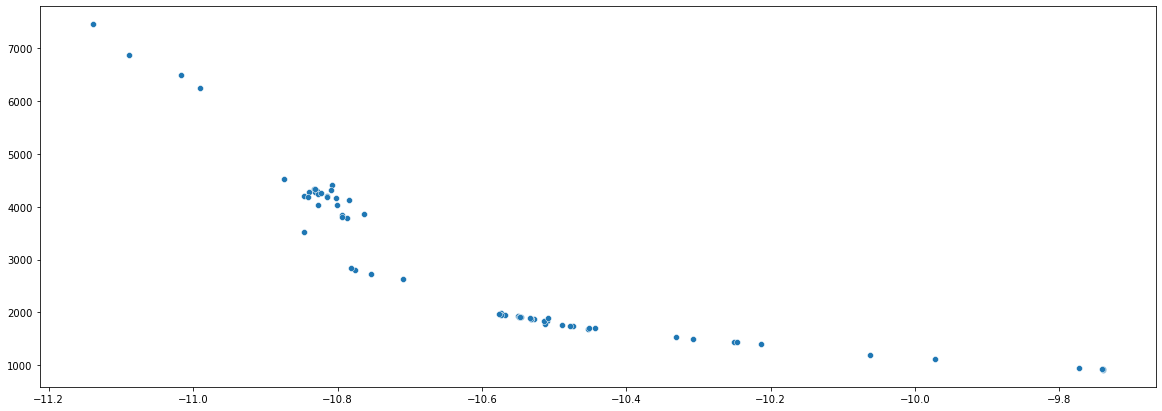

In [36]:
plt.figure(figsize=(20,7))
sns.scatterplot(x=np.log2(list(filtered_hela_nsaf.iloc[:,:].mean(axis=1))), y=list(hela_nsaf.notna().sum(axis=1)))

32546:	common prots: 3421	medianFC: 0.9947573842262845	stdFC: 0.09258506737624855
32616:	common prots: 3396	medianFC: 0.9886677387788998	stdFC: 0.0925152031900577
34748:	common prots: 3212	medianFC: 0.9769455138684033	stdFC: 0.1019345583196186
34786:	common prots: 3318	medianFC: 0.983183075776753	stdFC: 0.09234174999712932
32355:	common prots: 2344	medianFC: 1.0011975939976467	stdFC: 0.08379842512569095
32356:	common prots: 2285	medianFC: 1.0000560232005204	stdFC: 0.08345690904683034
32357:	common prots: 2409	medianFC: 1.0020224015761008	stdFC: 0.08418400232560255
32358:	common prots: 2420	medianFC: 1.0034437266198974	stdFC: 0.08073536336477197
32374:	common prots: 1770	medianFC: 1.022322422103698	stdFC: 0.09919159800860544
32375:	common prots: 1746	medianFC: 1.0220680734879148	stdFC: 0.09835044212307233
32376:	common prots: 1723	medianFC: 1.0258776970544894	stdFC: 0.09914619670732333
32377:	common prots: 1718	medianFC: 1.0236871255631952	stdFC: 0.0975379595148906
32378:	common prots: 

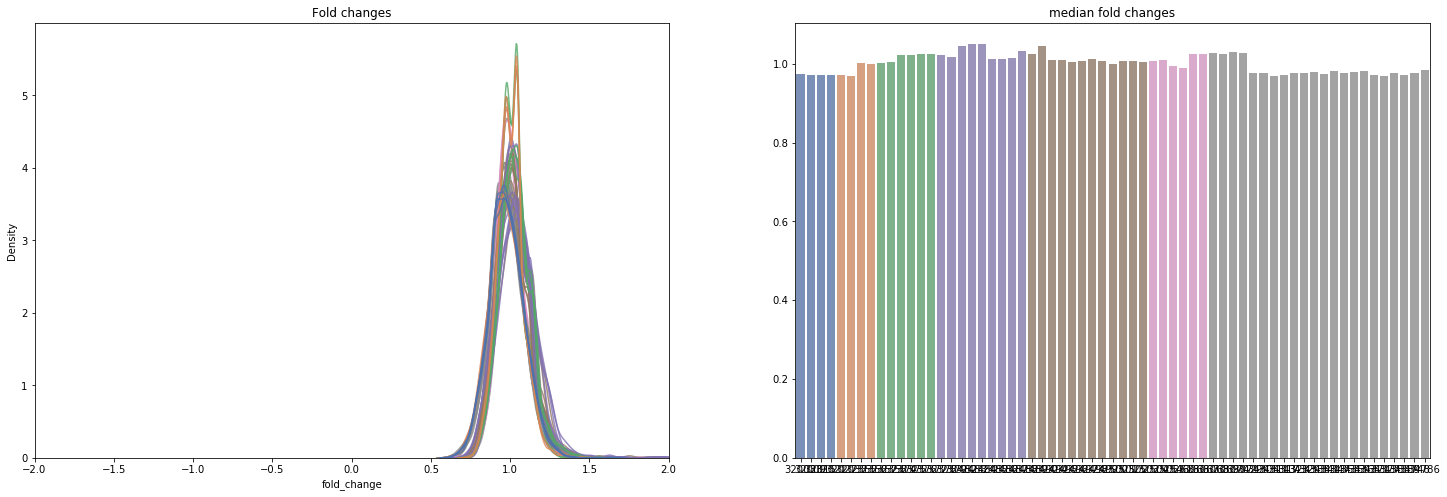

In [35]:
plot_fc(np.log2(hela_nsaf).fillna(0.0), ref = 32416, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([32416])]))

32546:	common prots: 1440	medianFC: 0.1812422808852232	stdFC: 0.6462659125912251
32616:	common prots: 1437	medianFC: 0.1943711173074251	stdFC: 0.6605388173412713
34748:	common prots: 1428	medianFC: 0.2561035523598183	stdFC: 0.827138708208917
34786:	common prots: 1435	medianFC: 0.19090651461343672	stdFC: 0.6996003712539893
32355:	common prots: 1383	medianFC: -0.009583368024380949	stdFC: 0.6757305971269729
32356:	common prots: 1381	medianFC: -0.0005096289737997437	stdFC: 0.6689411350413323
32357:	common prots: 1388	medianFC: -0.016997319235568544	stdFC: 0.6501987372914839
32358:	common prots: 1403	medianFC: -0.025866562325485846	stdFC: 0.6332293704480445
32374:	common prots: 1288	medianFC: -0.11089099506712621	stdFC: 0.75594561688425
32375:	common prots: 1291	medianFC: -0.16724532795047797	stdFC: 0.7557869492289984
32376:	common prots: 1279	medianFC: -0.14580202386695645	stdFC: 0.7584551937749556
32377:	common prots: 1299	medianFC: -0.09503971656004773	stdFC: 0.7692022211102065
32378:	co

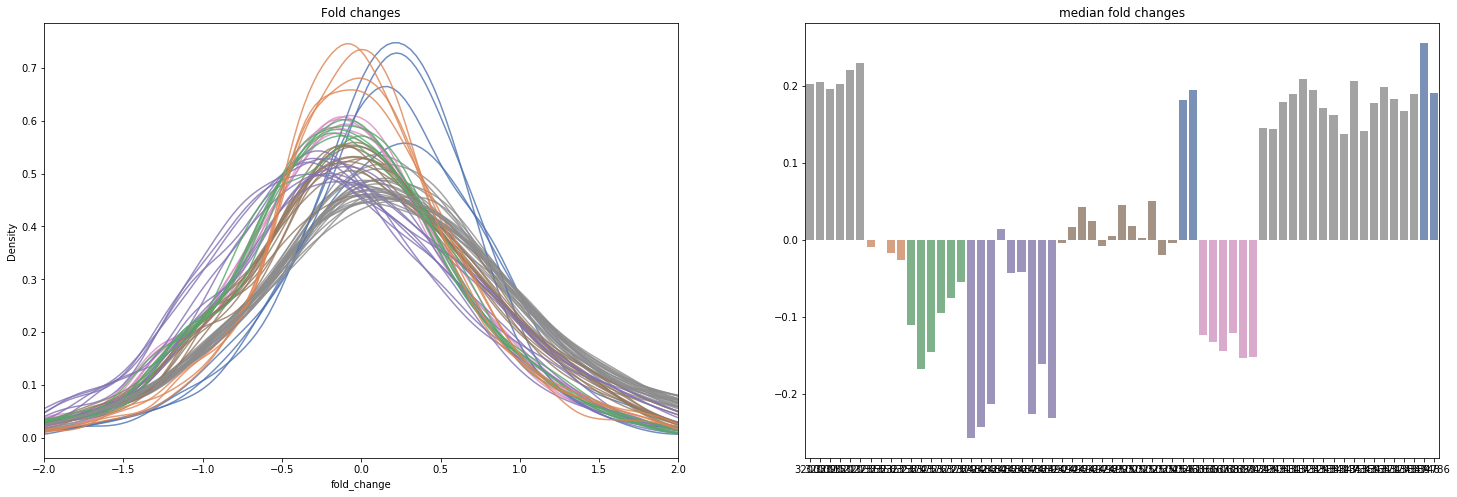

In [64]:
plot_fc(filtered_hela_nsaf.fillna(0.0), ref = 32416, plot_med_fc = True, color_scheme=list(cols_[~cols_.index.isin([32416])]))

2 aspects can be appreciated:
1. Systematic differences in the quantification levels are visible
2. Consequently, the median fold change between proteins of the HeLa samples are shifted

Possibly, this could be corrected by subtracting the median NSAF value to every protein in the sample and dividing by the standard deviation

In [37]:
med_std = pd.DataFrame()

def scale_sample(row):
    median, std = med_std.loc[row.name,:]
    return (row-median)/std

med_std['median'] = np.log2(filtered_hela_nsaf).apply(lambda x: np.nanmedian(x), axis =1)
med_std['std'] = np.log2(filtered_hela_nsaf).apply(lambda x: np.nanstd(x), axis =1)

In [27]:
np.log2(filtered_hela_nsaf).melt().dropna()

uniprot_id      value
0         A0AVT1 -11.667483
1         A0AVT1 -11.866996
2         A0AVT1 -11.983884
3         A0AVT1 -12.646660
4         A0AVT1 -13.470182
...          ...        ...
94075     Q9Y6Y8 -13.165158
94076     Q9Y6Y8 -12.508325
94077     Q9Y6Y8 -12.495852
94078     Q9Y6Y8 -12.668880
94079     Q9Y6Y8 -12.762310

[83950 rows x 2 columns]

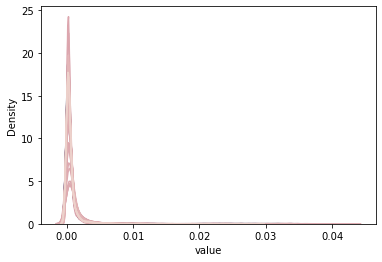

In [34]:
sns.kdeplot(data= filtered_hela_nsaf.T.melt().dropna(), x="value", hue="assay_id", legend=False)

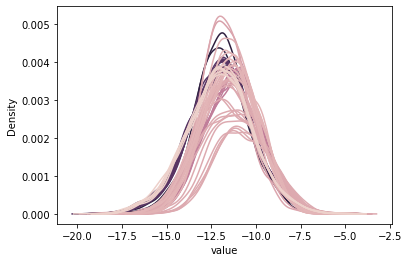

In [33]:
sns.kdeplot(data=np.log2(filtered_hela_nsaf).T.melt().dropna(), x="value", hue="assay_id", legend=False)

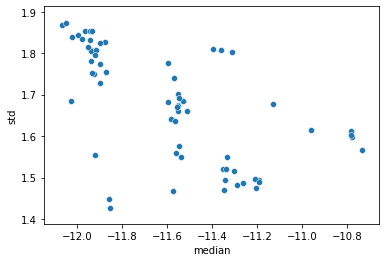

In [19]:
sns.scatterplot(data=med_std, x='median', y="std")

In [39]:
scaled_hela_nsaf = logged_hela_nsaf.apply(lambda x: scale_sample(x), axis = 1)

In [41]:
filtered_scaled_hela_nsaf = scaled_hela_nsaf.loc[:,reoccurring]

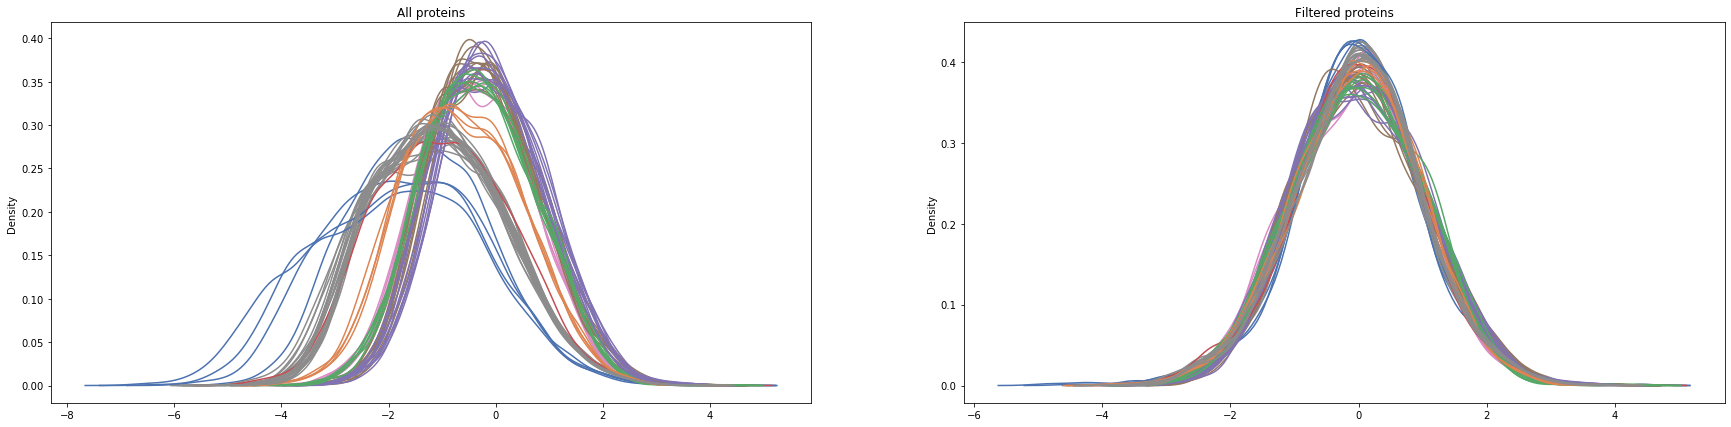

In [42]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_scaled_hela_nsaf.transpose(), palette = list(hela_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

32546:	common prots: 3421	medianFC: 0.9173687931284653	stdFC: 0.9100336537985763
32616:	common prots: 3396	medianFC: 0.9326210642847355	stdFC: 0.8605792504240596
34748:	common prots: 3212	medianFC: 0.8861236473977707	stdFC: 0.7843521918521831
34786:	common prots: 3318	medianFC: 0.9234093801666383	stdFC: 0.7788056437335206
32355:	common prots: 2344	medianFC: 0.9899978031974728	stdFC: 0.539289166154414
32356:	common prots: 2285	medianFC: 1.0043527122962037	stdFC: 0.537496375902429
32357:	common prots: 2409	medianFC: 0.9879869894426463	stdFC: 0.545315653425449
32358:	common prots: 2420	medianFC: 0.9830550368800908	stdFC: 0.5531770089170754
32374:	common prots: 1770	medianFC: 0.9885436964162712	stdFC: 0.6045038796413149
32375:	common prots: 1746	medianFC: 1.0126046666490636	stdFC: 0.6314778569766851
32376:	common prots: 1723	medianFC: 0.9552516357029046	stdFC: 0.5898303950456735
32377:	common prots: 1718	medianFC: 0.9958515946953244	stdFC: 0.6092508295554704
32378:	common prots: 1752	media

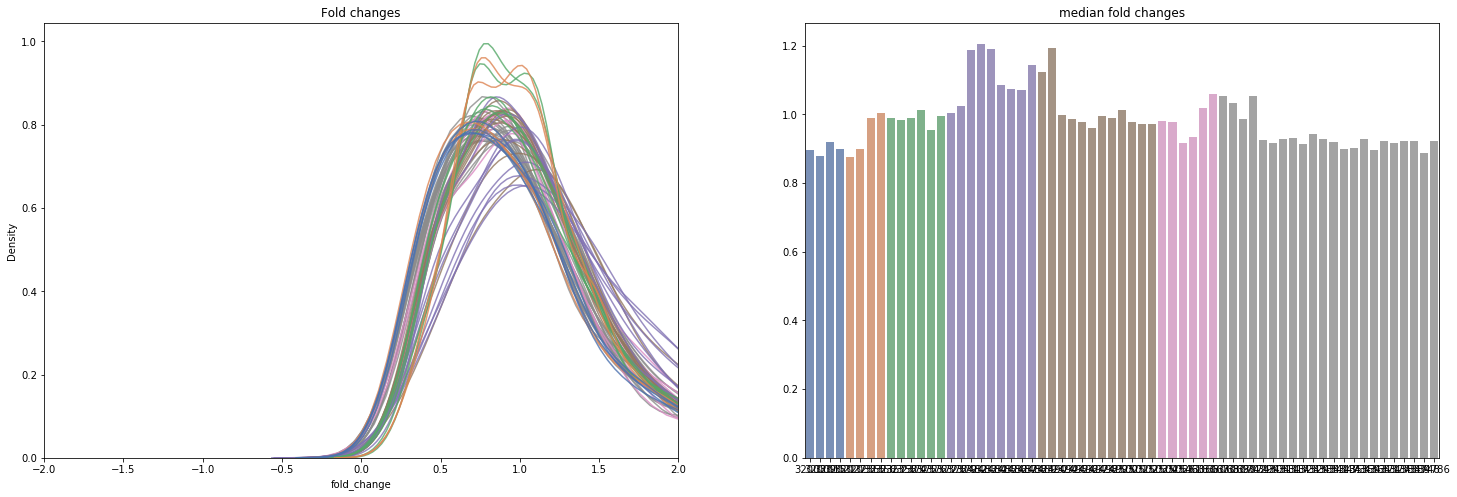

In [46]:
plot_fc(np.exp2(scaled_hela_nsaf).fillna(0.0), ref = 32416, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([32416])]))

32546:	common prots: 1440	medianFC: 0.9883459071686153	stdFC: 0.6588518211359765
32616:	common prots: 1437	medianFC: 0.993128265033986	stdFC: 0.5561808667302751
34748:	common prots: 1428	medianFC: 0.9794587840974756	stdFC: 0.7299809104543887
34786:	common prots: 1435	medianFC: 0.9819594153986533	stdFC: 0.5840907000703381
32355:	common prots: 1383	medianFC: 1.0207897703902662	stdFC: 0.5292795306149752
32356:	common prots: 1381	medianFC: 1.0230000326206834	stdFC: 0.5106069768963187
32357:	common prots: 1388	medianFC: 1.0162439105160024	stdFC: 0.5082496515702567
32358:	common prots: 1403	medianFC: 0.9959304708711629	stdFC: 0.513091010751463
32374:	common prots: 1288	medianFC: 1.0338865903120245	stdFC: 0.6096935231867214
32375:	common prots: 1291	medianFC: 1.0257327317519065	stdFC: 0.6498489415737849
32376:	common prots: 1279	medianFC: 1.0208693043407515	stdFC: 0.5998903917241201
32377:	common prots: 1299	medianFC: 1.0470833899412464	stdFC: 0.6261277122761408
32378:	common prots: 1310	medi

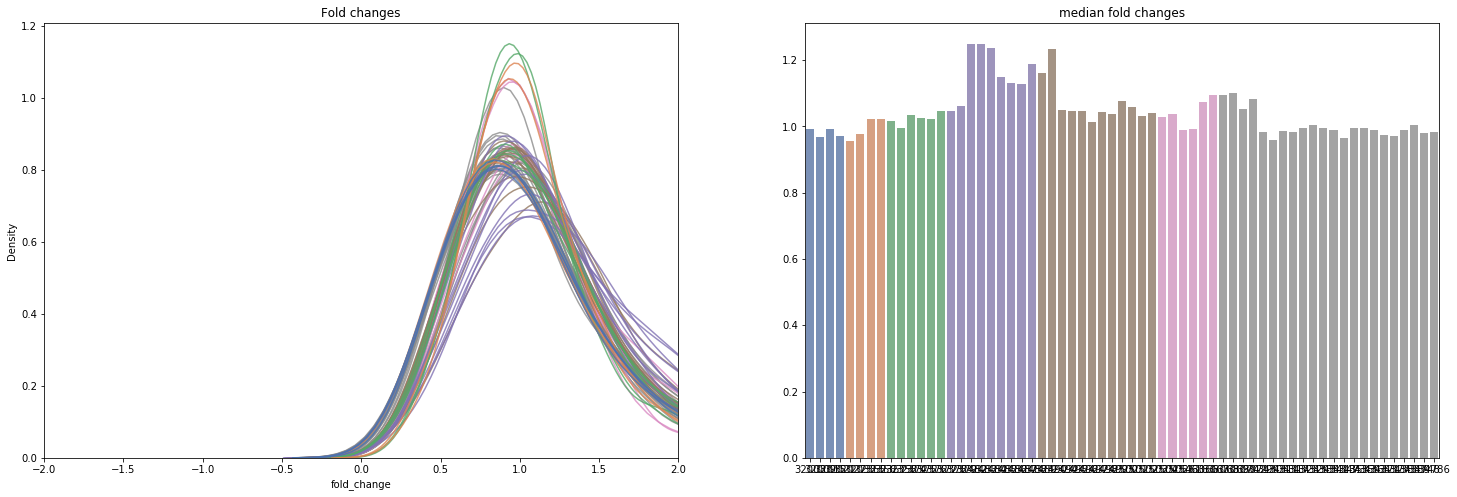

In [44]:
plot_fc(np.exp2(filtered_scaled_hela_nsaf).fillna(0.0), ref = 32416, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([32416])]))

PXD003530 still shows systematic differences where the median protein fold change difference is .2

In [131]:
hela_meta[hela_meta.PXD_accession == "PXD003530"]

project_id                          filename  cell_id cell_line  \
assay_id                                                                    
32482           1868                    20120227_MT_01      578      HeLa   
32487           1868   20120302_MT_DMSO_load_2uL_4h_G6      578      HeLa   
32490           1868       20120306_MT_DMSO_load_2h_G6      578      HeLa   
32483           1868                    20120227_MT_02      621      HeLa   
32484           1868                    20120227_MT_03      621      HeLa   
32485           1868  20120302_MT_AspD0_load_2uL_4h_G6      621      HeLa   
32486           1868  20120302_MT_AspD3_load_2uL_4h_G6      621      HeLa   
32488           1868      20120306_MT_AspD0_load_2h_G6      621      HeLa   
32489           1868      20120306_MT_AspD3_load_2h_G6      621      HeLa   

                 disease treatment tissue_type sub_cell  organ_id  \
assay_id                                                            
32482     adenocarcinoma         /      cervix        /       NaN   
32487     adenocarcinoma         /      cervix        /       NaN   
32490     adenocarcinoma         /      cervix        /       NaN   
32483     adenocarcinoma   aspirin      cervix        /       NaN   
32484     adenocarcinoma   aspirin      cervix        /       NaN   
32485     adenocarcinoma   aspirin      cervix        /       NaN   
32486     adenocarcinoma   aspirin      cervix        /       NaN   
32488     adenocarcinoma   aspirin      cervix        /       NaN   
32489     adenocarcinoma   aspirin      cervix        /       NaN   

         PXD_accession  all_PSM  sign_PSM  peptides  proteins experiment_type  \
assay_id                                                                        
32482        PXD003530    76080     14023      3950       956     in-solution   
32487        PXD003530   185179     30523      9026      1490     in-solution   
32490        PXD003530    89830     13911      4074       991     in-solution   
32483        PXD003530    75047     13831      3926       949     in-solution   
32484        PXD003530    77654     14427      4088       962     in-solution   
32485        PXD003530   179791     29606      8669      1468     in-solution   
32486        PXD003530   189333     31528      9170      1501     in-solution   
32488        PXD003530   106417     17108      5027      1168     in-solution   
32489        PXD003530   113610     18300      5371      1229     in-solution   

          instrument      pmid  pool_id ionbot_version  
assay_id                                                
32482     Q-exactive  27913581        0  IONBOT_v0.7.0  
32487     Q-exactive  27913581        0  IONBOT_v0.7.0  
32490     Q-exactive  27913581        0  IONBOT_v0.7.0  
32483     Q-exactive  27913581        0  IONBOT_v0.7.0  
32484     Q-exactive  27913581        0  IONBOT_v0.7.0  
32485     Q-exactive  27913581        0  IONBOT_v0.7.0  
32486     Q-exactive  27913581        0  IONBOT_v0.7.0  
32488     Q-exactive  27913581        0  IONBOT_v0.7.0  
32489     Q-exactive  27913581        0  IONBOT_v0.7.0

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


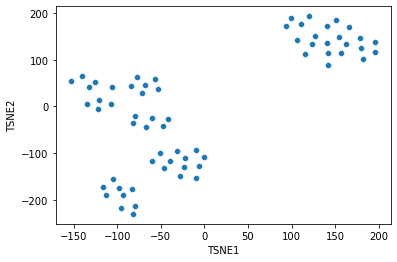

In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=15)
decomp = tsne.fit_transform(filtered_hela_nsaf.fillna(0))

sns.scatterplot(data=pd.DataFrame(data=decomp, columns=["TSNE1", "TSNE2"]), x="TSNE1", y = "TSNE2")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


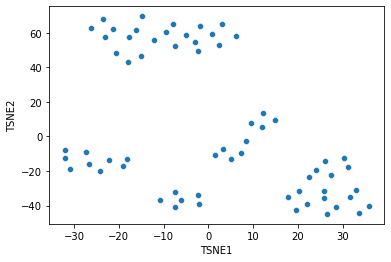

In [55]:
tsne = TSNE(perplexity=15)
decomp = tsne.fit_transform(np.exp2(filtered_scaled_hela_nsaf).fillna(0))

sns.scatterplot(data=pd.DataFrame(data=decomp, columns=["TSNE1", "TSNE2"]), x="TSNE1", y = "TSNE2")

# Apply this workflow to MCF7 subset

In [144]:
len(cols)

43

Plot the identified proteins per sample. Projects are colored

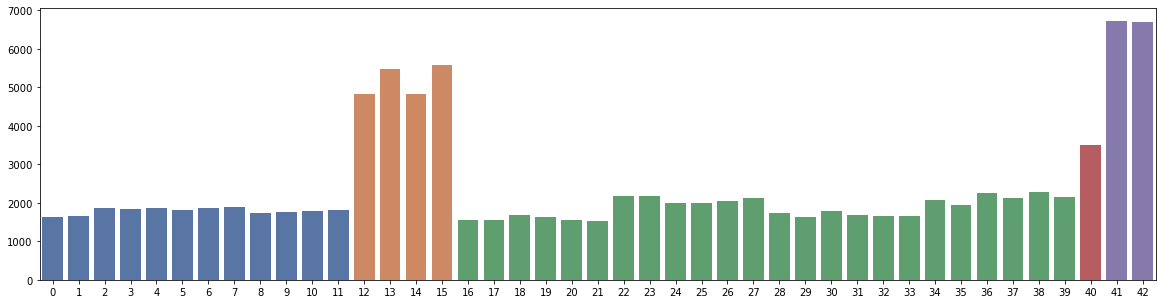

In [15]:
MCF7_assays = meta[meta.cell_line == "MCF7"].index

MCF7_nsaf = nsaf.loc[MCF7_assays,:]
MCF7_meta = meta[meta.index.isin(MCF7_assays)]

lut = {}
for x in MCF7_meta.PXD_accession.unique():
    lut[x] = sns.color_palette("deep")[len(lut)]

plt.figure(figsize=(20,5))

cols = MCF7_meta.PXD_accession.apply(lambda x: lut[x])

sns.barplot(x=list(range(len(MCF7_nsaf))), y=MCF7_nsaf.notna().sum(axis=1), palette=cols)

After filtering 50 % of the reoccuring proteins

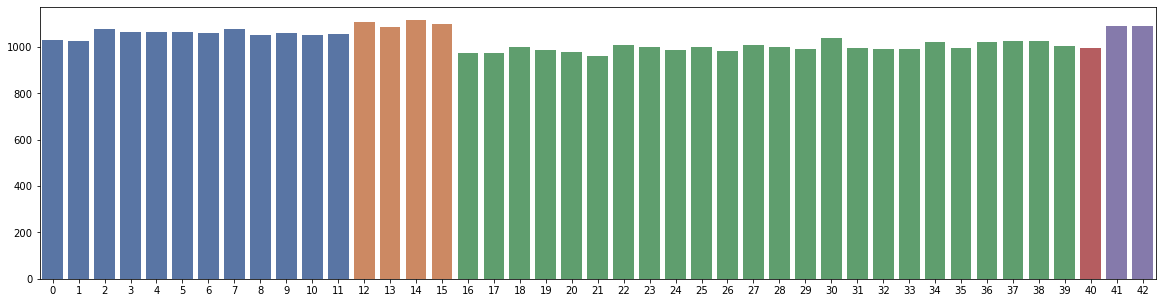

In [16]:
logged_MCF7_nsaf = np.log2(MCF7_nsaf)
reoccurring, deleted = uml._identify_global_reoccured_proteins(MCF7_nsaf.fillna(0), .7)

filtered_MCF7_nsaf = MCF7_nsaf.loc[:,reoccurring]
filtered_log_MCF7_nsaf = logged_MCF7_nsaf.loc[:,reoccurring]

plt.figure(figsize=(20,5))

sns.barplot(x=list(range(len(MCF7_nsaf))), y=filtered_MCF7_nsaf.notna().sum(axis=1), palette=cols)

Plot the abundance values of proteins, where each line is the distribution of protein expression values for a sample, colored by project. <br>
This is done for all proteins and for the filtered proteins only.

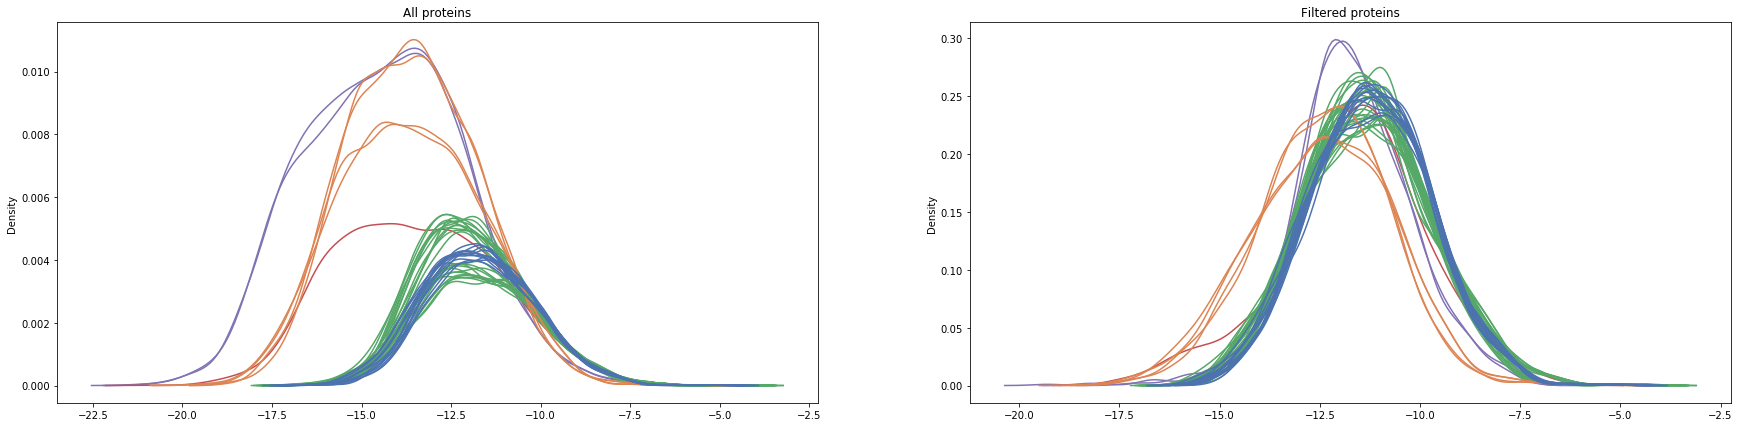

In [14]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=logged_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_log_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

Plot the distribution of fold changes of protein expression between a reference sample and all the other samples

31254:	common prots: 896	medianFC: 0.8825979845636287	stdFC: 1.3242510167889276
31255:	common prots: 889	medianFC: 0.8638220602863547	stdFC: 1.3716932461625295
31256:	common prots: 935	medianFC: 0.8438104682433192	stdFC: 1.3981938382821852
31257:	common prots: 925	medianFC: 0.874322019094786	stdFC: 1.3547189792267376
31258:	common prots: 925	medianFC: 0.8712200620056613	stdFC: 1.3925615616283404
31259:	common prots: 924	medianFC: 0.8777995488788966	stdFC: 1.3011291545996304
31260:	common prots: 920	medianFC: 0.9046954915667746	stdFC: 1.3994828550691147
31261:	common prots: 937	medianFC: 0.9185938717647396	stdFC: 1.5165061351888935
31262:	common prots: 915	medianFC: 0.8958836524631534	stdFC: 1.309548363416909
31263:	common prots: 922	medianFC: 0.9006927695653562	stdFC: 1.2879221049671439
31264:	common prots: 915	medianFC: 0.8500428464234784	stdFC: 1.2298844261693458
31265:	common prots: 917	medianFC: 0.8581397762633471	stdFC: 1.2815132890993972
31353:	common prots: 965	medianFC: 1.89096

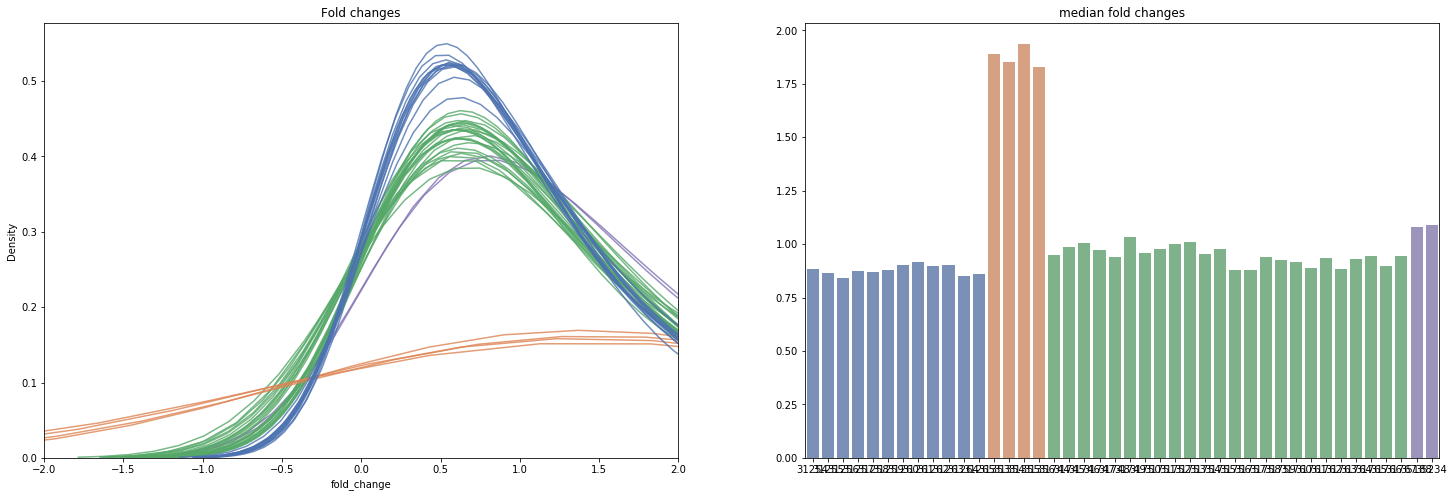

In [17]:
plot_fc(filtered_MCF7_nsaf.fillna(0.0), ref = 33989, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([33989])]))

You see systematic project bias

In [20]:
med_std = pd.DataFrame()

def calc_median(row):
    values = row[row!=0]
    return np.median(values)

med_std['median'] = np.log2(filtered_MCF7_nsaf).fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = np.log2(filtered_MCF7_nsaf).apply(lambda x: np.std(x), axis =1)

scaled_MCF7_nsaf = logged_MCF7_nsaf.apply(lambda x: scale_sample(x), axis = 1)
filtered_scaled_MCF7_nsaf = scaled_MCF7_nsaf.loc[:,reoccurring]

Plot the same stuff, after median centering with variance correction

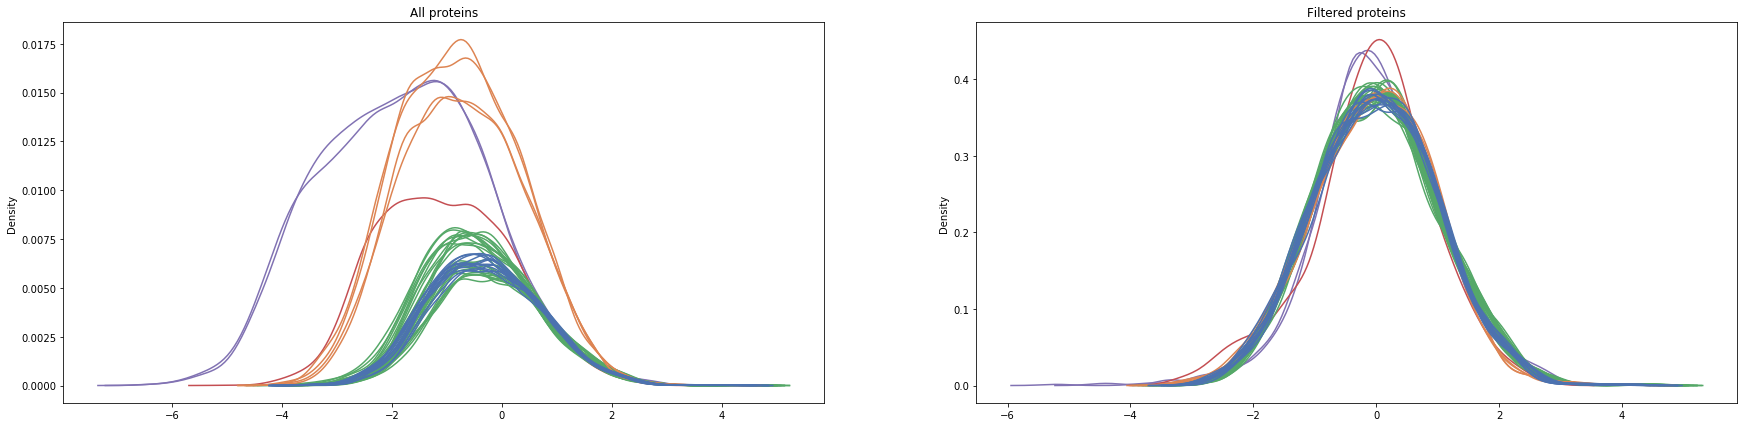

In [21]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=filtered_scaled_MCF7_nsaf.transpose(), palette = list(MCF7_meta.PXD_accession.apply(lambda x: lut[x]).sort_index()), legend = False, common_norm=False, ax =ax[1])

31254:	common prots: 896	medianFC: 1.0257822269085373	stdFC: 0.7014589083652263
31255:	common prots: 889	medianFC: 1.0109338924070532	stdFC: 0.7161094418771743
31256:	common prots: 935	medianFC: 1.0122846399983019	stdFC: 0.7404802155916062
31257:	common prots: 925	medianFC: 0.9996414653811644	stdFC: 0.7173908045947915
31258:	common prots: 925	medianFC: 1.0084593340487178	stdFC: 0.7004243946059282
31259:	common prots: 924	medianFC: 1.0146352710965507	stdFC: 0.6782193352124687
31260:	common prots: 920	medianFC: 1.0681950622583054	stdFC: 0.7144344688804459
31261:	common prots: 937	medianFC: 1.0523317050472327	stdFC: 0.7319745931339395
31262:	common prots: 915	medianFC: 1.042180733159682	stdFC: 0.7243005893247667
31263:	common prots: 922	medianFC: 1.0528358762674812	stdFC: 0.7280446035480962
31264:	common prots: 915	medianFC: 0.9928314261425468	stdFC: 0.6948025975382446
31265:	common prots: 917	medianFC: 0.9720592240453297	stdFC: 0.698637532027732
31353:	common prots: 965	medianFC: 1.02214

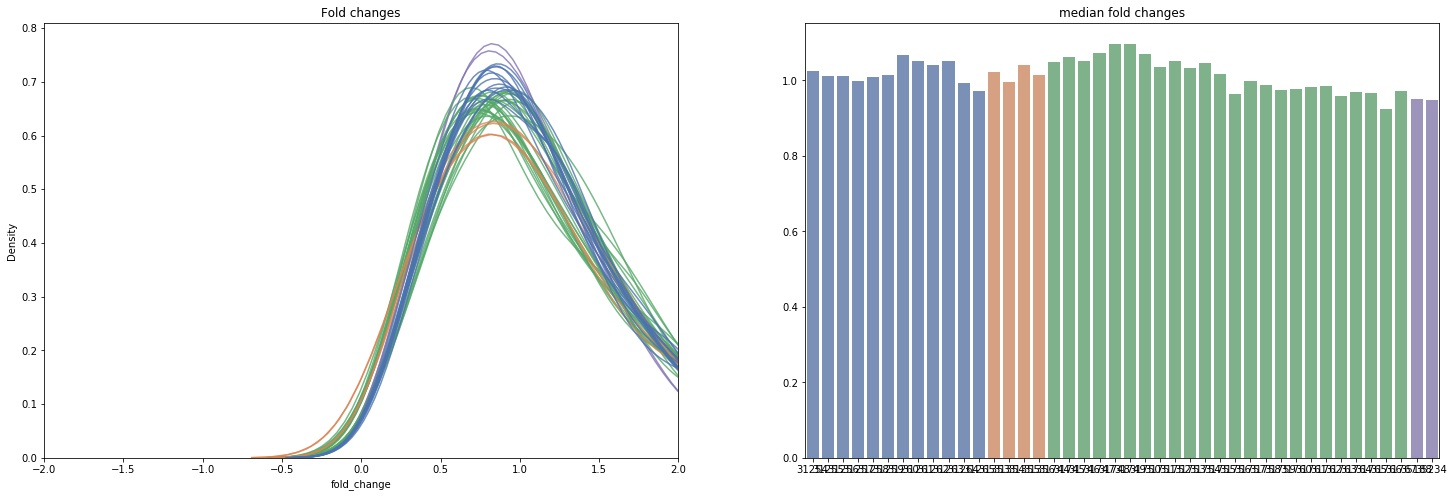

In [21]:
# non log fc
plot_fc(np.exp2(filtered_scaled_MCF7_nsaf).fillna(0.0), ref = 33989, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([33989])]))

31254:	common prots: 896	medianFC: 0.025455468480618068	stdFC: 0.6338265003072292
31255:	common prots: 889	medianFC: 0.010874549579013628	stdFC: 0.6350600779522321
31256:	common prots: 935	medianFC: 0.012209796138195964	stdFC: 0.6354769594712956
31257:	common prots: 925	medianFC: -0.000358598907739058	stdFC: 0.6336537102658923
31258:	common prots: 925	medianFC: 0.008423754395079362	stdFC: 0.6272167948921257
31259:	common prots: 924	medianFC: 0.014529206546349132	stdFC: 0.6221508784291514
31260:	common prots: 920	medianFC: 0.06597034634988871	stdFC: 0.6134096578104653
31261:	common prots: 937	medianFC: 0.05100837359634769	stdFC: 0.6225803686410982
31262:	common prots: 915	medianFC: 0.041315376620581885	stdFC: 0.639089457903402
31263:	common prots: 922	medianFC: 0.05148662029689543	stdFC: 0.6393392797187576
31264:	common prots: 915	medianFC: -0.007194391540999319	stdFC: 0.636438416082271
31265:	common prots: 917	medianFC: -0.02833854629007258	stdFC: 0.6430214022687626
31353:	common prots

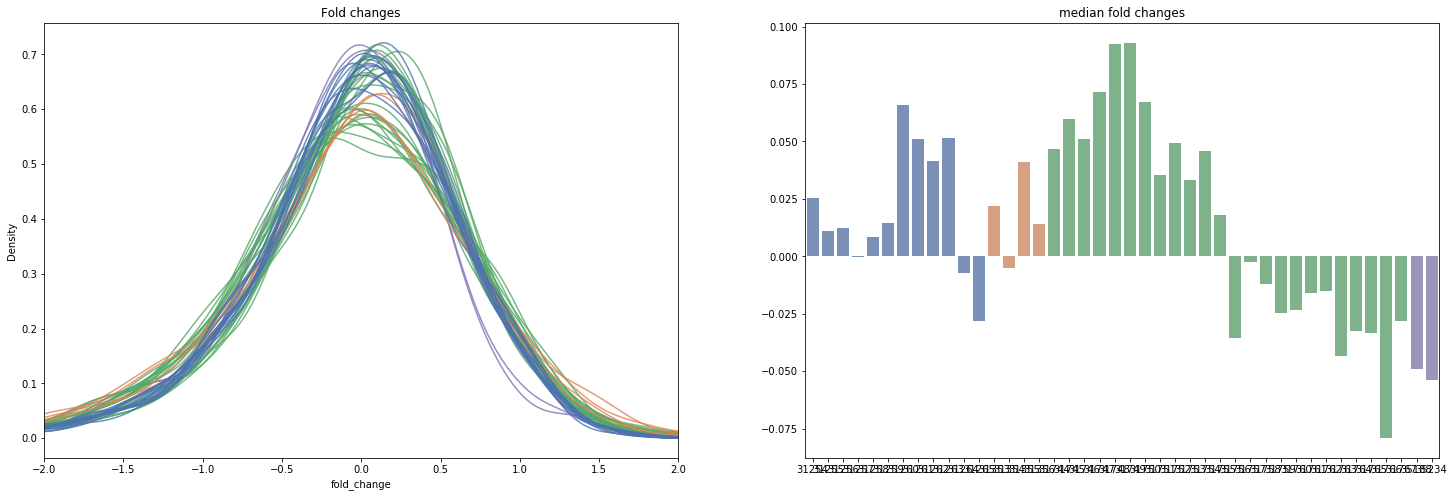

In [22]:
plot_fc(np.exp2(filtered_scaled_MCF7_nsaf).fillna(0.0), ref = 33989, plot_med_fc = True, color_scheme=list(cols[~cols.index.isin([33989])]))

In [23]:
plot_fc(np.exp2(pd.concat([scaled_MCF7_nsaf, scaled_hela_nsaf])).fillna(0.0), ref=33989 ,plot_med_fc = True)

NameError: name 'scaled_hela_nsaf' is not defined

The corrected NSAF values for MCF7 and HeLa are appended and visualized in the same manner.

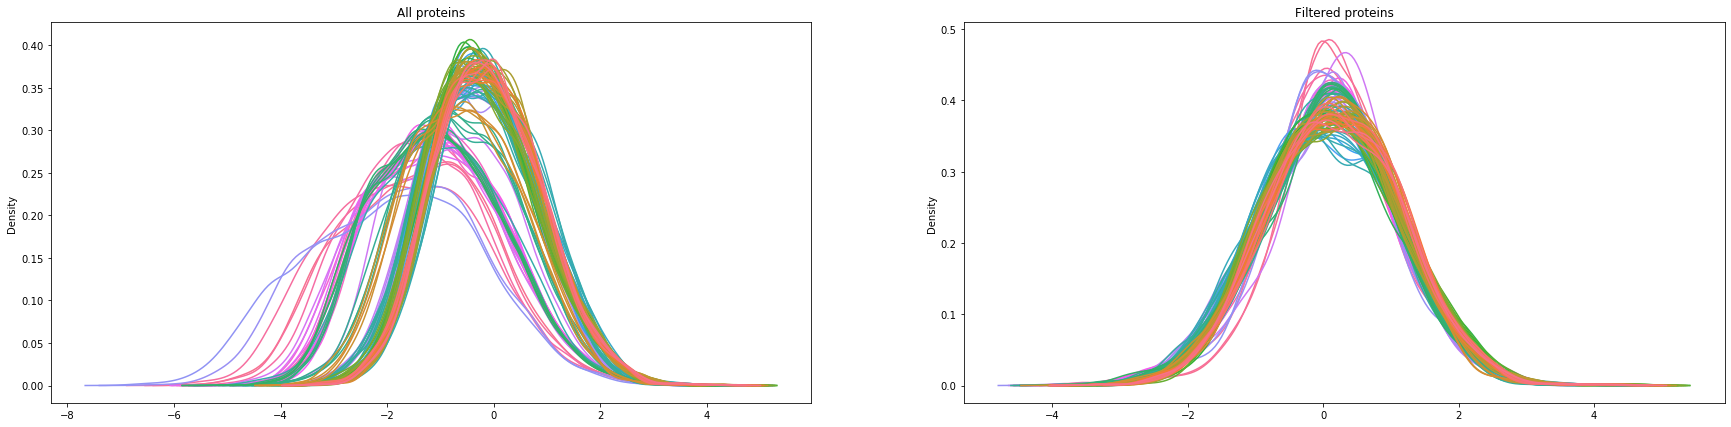

In [168]:
fig, ax = plt.subplots(1,2,figsize=(30,7))

mcf7_hela_set = pd.concat([scaled_MCF7_nsaf, scaled_hela_nsaf])


ax[0].set_title('All proteins')
sns.kdeplot(data=mcf7_hela_set.transpose(), legend = False, common_norm=False, ax =ax[0])


reoccurring, deleted = AAF._identify_global_reoccured_proteins(mcf7_hela_set.fillna(0), .7)

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=mcf7_hela_set.loc[:,reoccurring].transpose(), legend = False, common_norm=False, ax =ax[1])

Idea for future plots:

The reoccuring proteins should be the ones that are in the most abundant quantiles of protein expression. So, plot the quantile of the proteins that are selected, where the y-axis is the number of proteins originally quantified.

# Apply the correction to the complete dataset

## Define which assays to drop as outliers

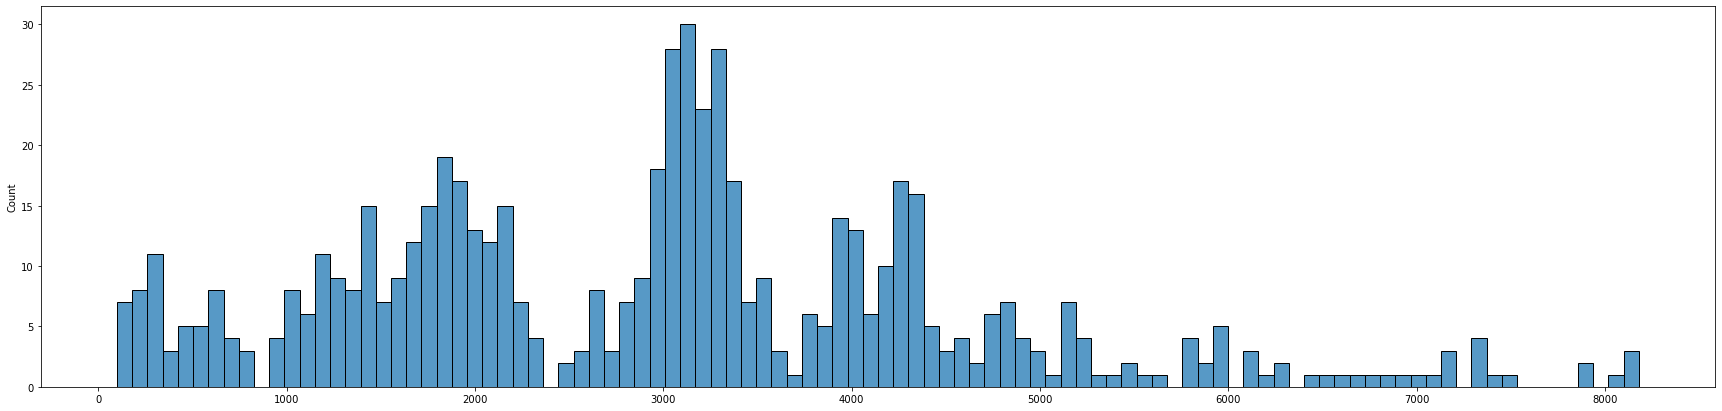

In [74]:
plt.figure(figsize=(30,7))
sns.histplot(nsaf.notna().sum(axis = 1), bins = 100)

Assays with <1000 protein identifications will not represent a large enough proteome proportion

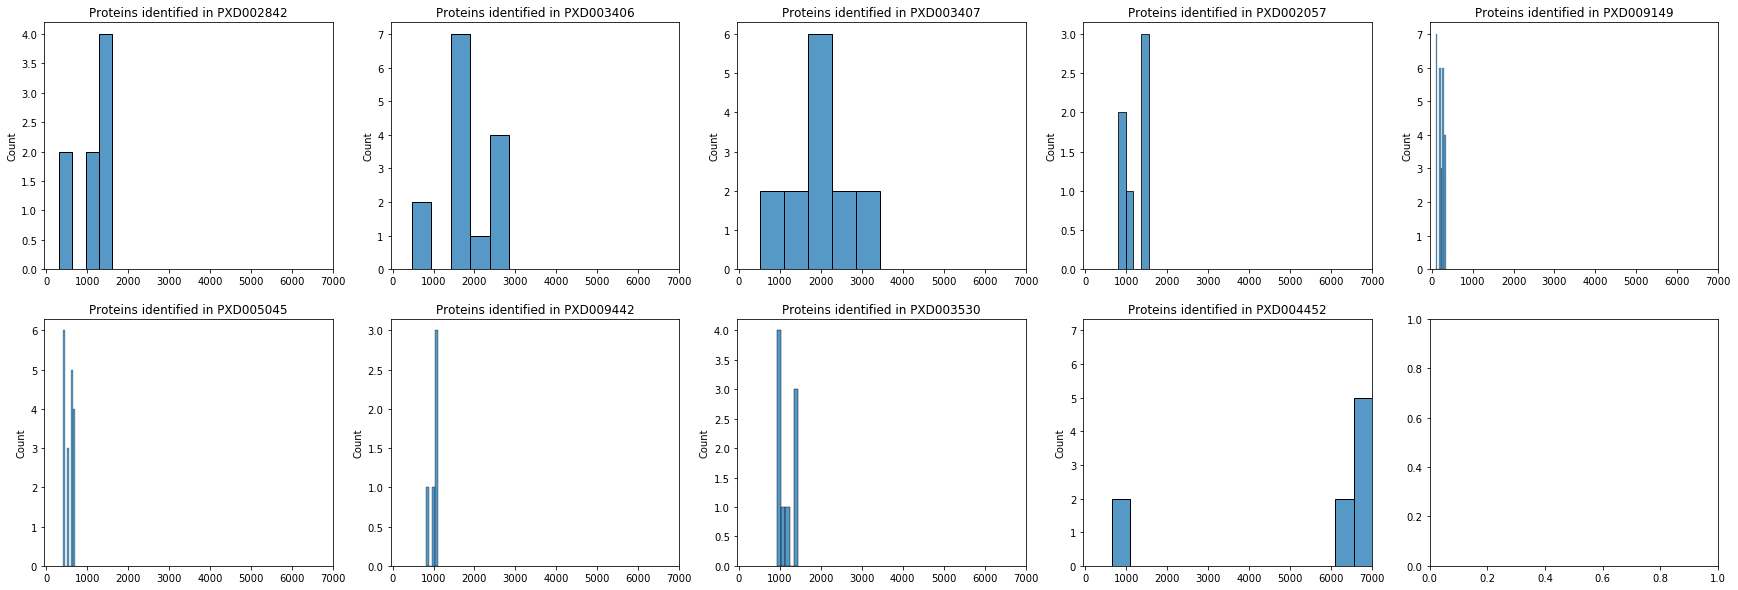

In [31]:
fig, ax = plt.subplots(2,5, figsize= (30,10))
for y, pxd in enumerate(meta.loc[nsaf.index[nsaf.notna().sum(axis=1) <1000], :].PXD_accession.unique()):
    
    if y < 5: 
        x=0
    else:
        y-=5
        x=1
    ax[x,y].set_title(f"Proteins identified in {pxd}")
    ax[x,y].set_xlim(left=-50, right=7000)
    sns.histplot(nsaf.loc[meta.PXD_accession == pxd].notna().sum(axis=1), ax=ax[x,y])

- **PXD002842**: Reported 3721 protein identifications. Here, only 312-1612 protein identifications were found with ionbot_v0.6.2 from 152,961 - 227,169 PSMs (sign_PSM: 31800). Drop the ones <1100
- **PXD003406, PXD003407**: Reported 8370 protein identifications. Here 4800 unique protein identifications were done. Assays reporting < 1100 proteins are dropped. Mean PSMs: 120,000 (sign_PSM: 21000). (ionbot_v0.6.2)
- **PXD002057**: Reported 800 protein identifications. Drop the AZD8931 resistant SKBR3 cells which all have <1100 protein identifications. sign_PSMs: 7500-9000. ionbot_version: v0.8.0
- **PXD009149**: Reported 3377 shared proteins (75% of total --> 4502 total proteins). ionbot_V0.6.0.2 never reaches more than 400 proteins with average sign_PSM: 843. Drop all of them
- **PXD005045**: Reported 1557 total protein identifications. We identify 1352 with ionbotv0.6.2. Average PSM (48398) with avg sign_PSM: 7897. No sample identified >700 proteins. Drop all of them.
- **PXD009442**: Reported +-2000 protein identifications per sample, however, only 1 proteotypic peptide was used to identify a protein. Here, >2 are needed and resulted in +- 1000 protein identifications per sample. Avg sign_PSM: 13311 (ionbotV0.6.2). Only keep the untreated cell. (assay_id 31702 with 1119 protein identifications)
- **PXD003530**: From 190,000-77,000 PSMs, (30,000-15,000 sign_PSM), only 950-1500 proteins were identified were >800 were identified in all samples. Keep only the ones with >1100 identifications.
- **PXD004452**: Only 2 assays identified <1100 proteins. For these, fractions are probably missing as most other identified >6000 proteins. Drop them.

In [4]:
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)

drop_assays = low_id_rate.index[low_id_rate < 1100]

In [5]:
nsaf_filtered = nsaf.loc[~nsaf.index.isin(drop_assays)]

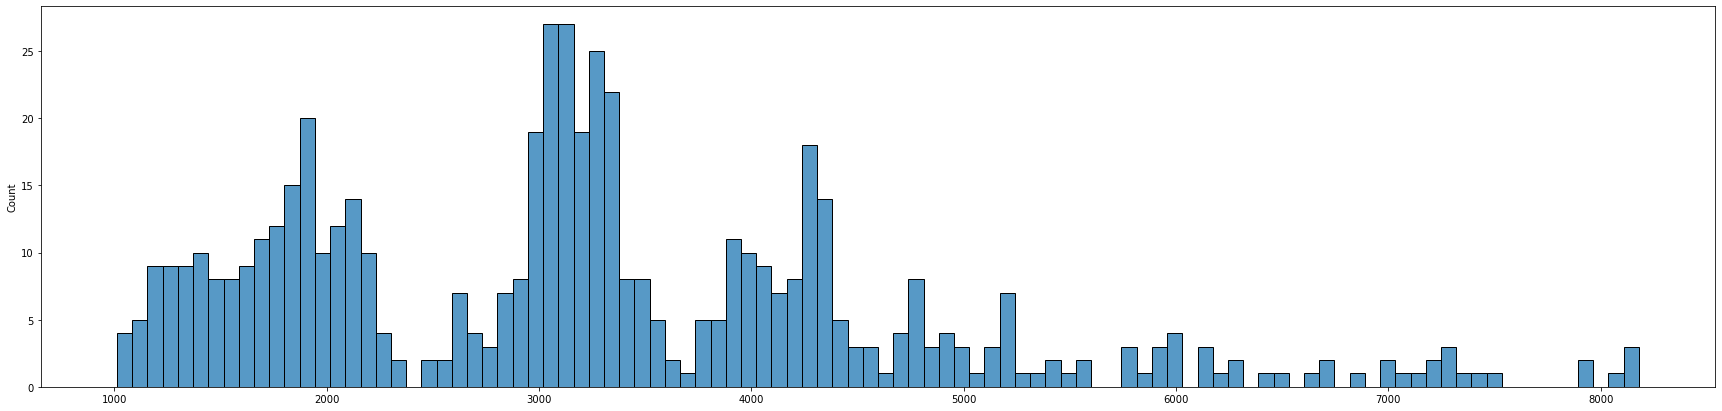

In [5]:
plt.figure(figsize=(30,7))
sns.histplot(nsaf_filtered.notna().sum(axis = 1), bins = 100)

## Show how sample amount per cell line

In [115]:
cell_tissue_map = {"cell_line":[], "tissue_type":[]}

for i, row in meta.loc[:,["cell_line", "tissue_type"]].iterrows():
    cell, tissue = row
    if cell not in cell_tissue_map["cell_line"]:
        cell_tissue_map["cell_line"].append(cell)
        cell_tissue_map["tissue_type"].append(tissue)
cell_tissue_map = pd.DataFrame(cell_tissue_map)

In [116]:
lut = {}
colors = sns.color_palette("deep") + sns.color_palette("bright")
for x in meta.tissue_type.unique():
    lut[x] = colors[len(lut)]

In [117]:
cols = [lut[cell_tissue_map[cell_tissue_map.cell_line==x].tissue_type.values[0]] for x in meta.cell_line.value_counts().index]

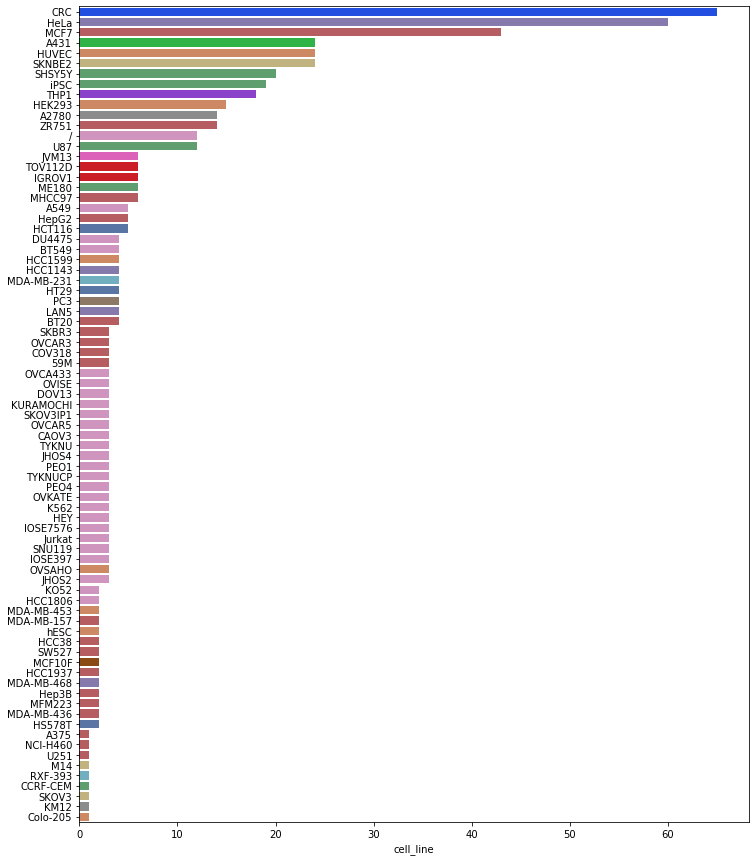

In [119]:
plt.figure(figsize=(12,15))
sns.barplot(x=meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts(), y = meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts().index, palette=cols)

## Apply median correction

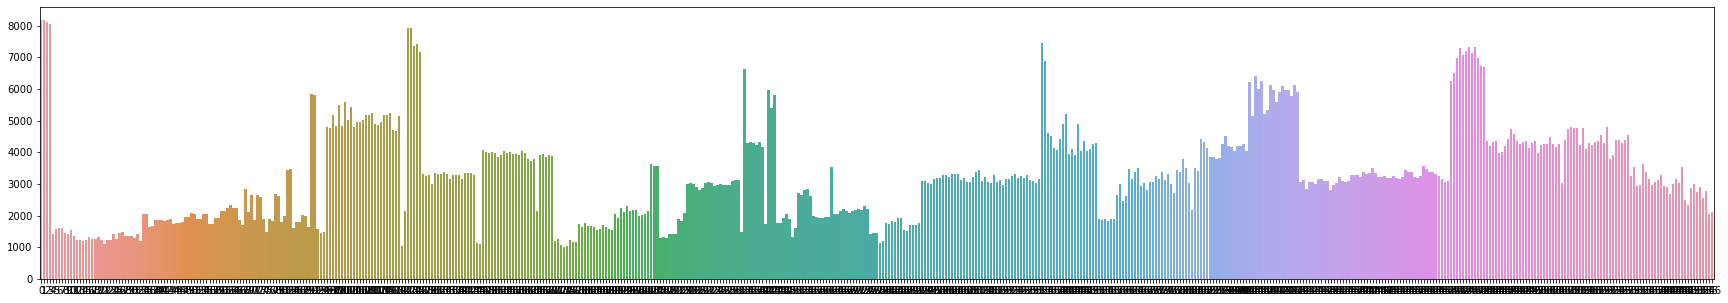

In [121]:
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_filtered))), y=nsaf_filtered.notna().sum(axis=1))

In [46]:
meta_filtered = meta[meta.index.isin(nsaf_filtered.index)]
print(meta_filtered.PXD_accession.nunique(), "projects and", meta_filtered.shape[0], "proteomes")
meta = meta_filtered.reset_index()
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")
meta.sort_index(inplace=True)

44 projects and 557 proteomes


In [25]:
filtered_90 = uml.FilterByOccurence(.9).fit_transform(nsaf_filtered)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


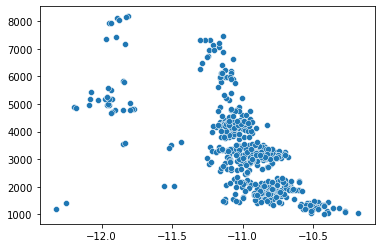

In [43]:
sns.scatterplot(np.log2(filtered_90).median(axis=1), nsaf_filtered.notna().sum(axis=1))

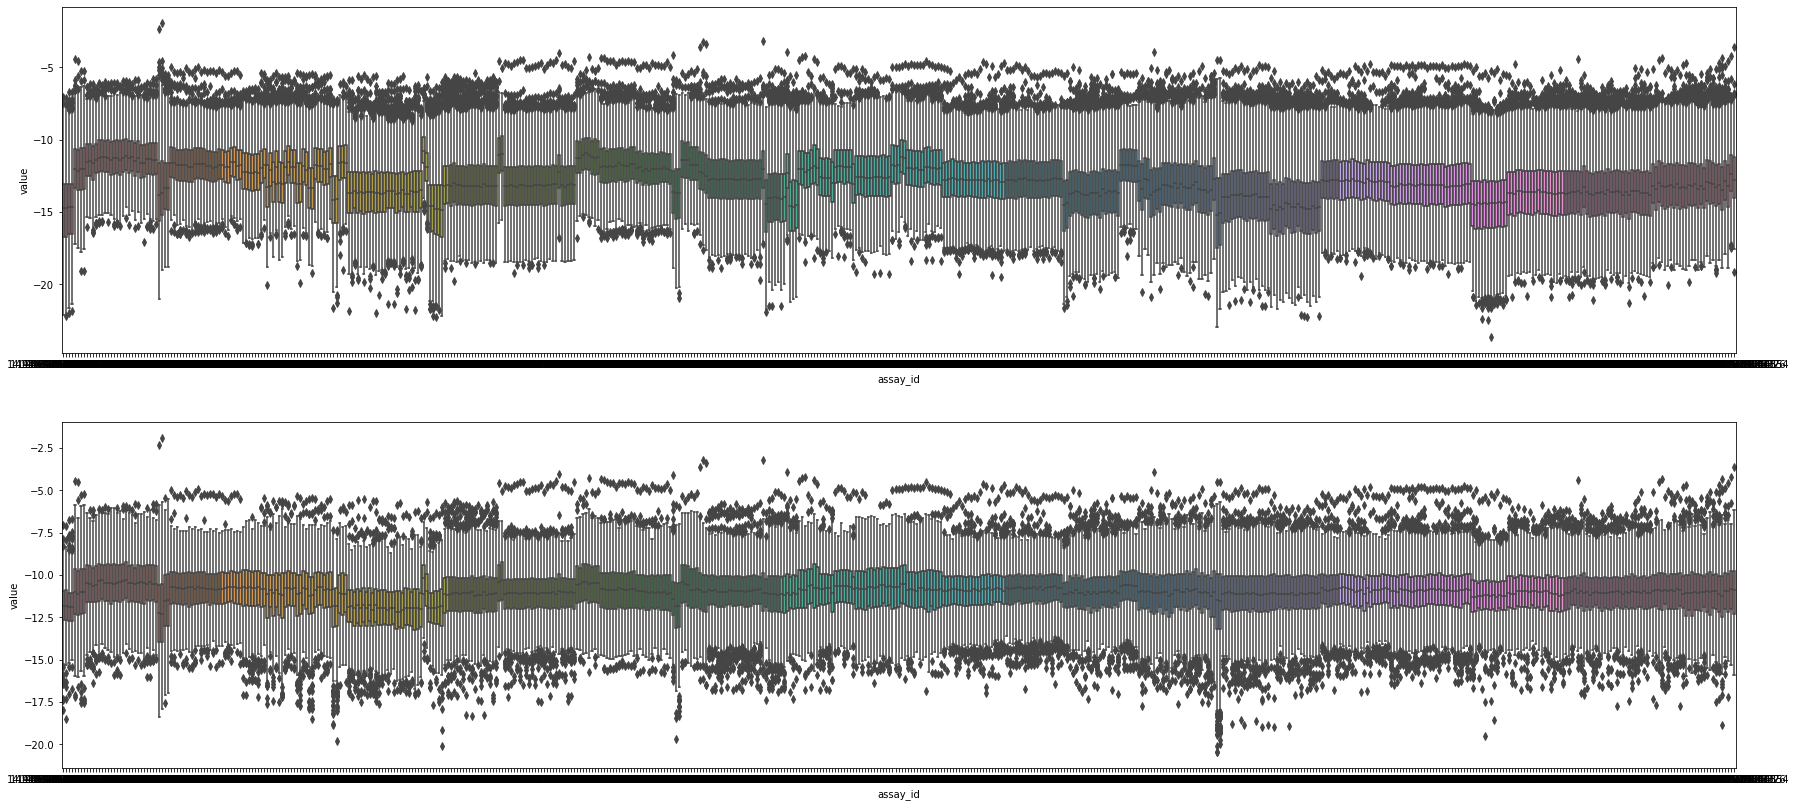

In [44]:
fig, ax = plt.subplots(2,1,figsize=(30,14))

sns.boxplot(data=np.log2(nsaf_filtered.T.melt().dropna()), y='value', x="assay_id", ax=ax[0])

sns.boxplot(data=np.log2(filtered_90.T.melt().dropna()), y='value', x="assay_id", ax=ax[1])

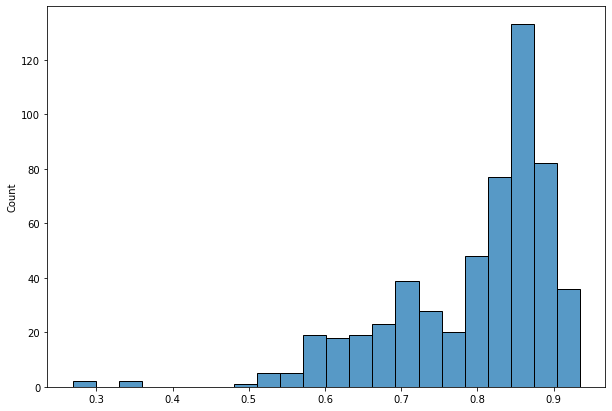

In [18]:
ranked_df = nsaf_filtered.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_filtered.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

# Most of the selected proteins are the most abundant ones in the sample
plt.figure(figsize=(10,7))
sns.histplot(ranked_df.loc[:,filtered_90.columns].median(axis=1))

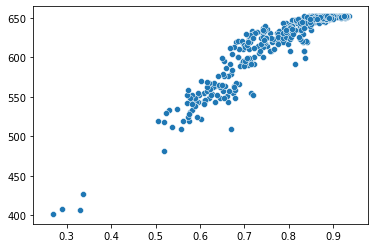

In [20]:
# Apart from some outliers, the most detected proteins are the most abundant ones
sns.scatterplot(x=ranked_df.loc[:,filtered_90.columns].median(axis=1), y=filtered_90.notna().sum(axis=1))

In [10]:
meta.loc[meta.index[ranked_df.loc[:,filtered_90.columns].mean(axis=1)<.5]]

project_id                               filename  cell_id  \
assay_id                                                               
31151           1819                       A431_1uM_DON_1_2      554   
31163           1820  161021_deSDS_Digested_cells_1SDS_01_B      556   
31345           1826                 130327_o2_02_hu_P1_2hr      562   
31347           1826                 130327_o2_04_hu_P2_2hr      562   
31349           1826                 130327_o2_06_hu_P3_2hr      562   
31376           1829              160116_K052_OffLRP_RP_f02      569   
31702           1836                  MDA-MB-231_CC_control      580   
31704           1836                      MDA-MB-231_CC_Dox      579   
31732           1838                     A2780-DR control-1      585   
31733           1838                     A2780-DR control-2      585   
31734           1838                       A2780-DR H19si-1      586   
32488           1868           20120306_MT_AspD0_load_2h_G6      621   

           cell_line                       disease       treatment  \
assay_id                                                             
31151           A431  Skin squamous cell carcinoma  deoxynivalenol   
31163         HEK293                       healthy               /   
31345          SKBR3                adenocarcinoma               /   
31347          SKBR3                adenocarcinoma               /   
31349          SKBR3                adenocarcinoma               /   
31376           KO52              myeloid leukemia               /   
31702     MDA-MB-231                adenocarcinoma               /   
31704     MDA-MB-231                adenocarcinoma               /   
31732          A2780                adenocarcinoma               /   
31733          A2780                adenocarcinoma               /   
31734          A2780                adenocarcinoma               /   
32488           HeLa                adenocarcinoma         aspirin   

           tissue_type        sub_cell  organ_id PXD_accession  all_PSM  \
assay_id                                                                  
31151             skin               /       NaN     PXD008996    75476   
31163     fetal kidney         HEK293F       NaN     PXD006035    33347   
31345           breast               /       NaN     PXD002057     9453   
31347           breast               /       NaN     PXD002057     8124   
31349           breast               /       NaN     PXD002057     8309   
31376            blood               /       NaN     PXD008381    23390   
31702           breast               /       NaN     PXD009442    78050   
31704           breast    MDA-MB-231-R       NaN     PXD009442    72654   
31732            ovary        A2780-DR       NaN     PXD003252    86566   
31733            ovary        A2780-DR       NaN     PXD003252    86496   
31734            ovary  A2780-DR H19KO       NaN     PXD003252    86215   
32488           cervix               /       NaN     PXD003530   106417   

          sign_PSM  peptides  proteins    experiment_type  \
assay_id                                                    
31151        13962      4642      1133             in-gel   
31163         5174      1385       282  in-solution, FASP   
31345         8718      7501      1593        in-solution   
31347         7517      6444      1464        in-solution   
31349         7697      6630      1502        in-solution   
31376          448       172       131        in-solution   
31702        14400      4872      1133               FASP   
31704        15434      5185      1119               FASP   
31732        13869      4591      1069        in-solution   
31733        13364      4379      1026        in-solution   
31734        13987      4698      1055        in-solution   
32488        17108      5027      1168        in-solution   

                   instrument      pmid  pool_id ionbot_version  \
assay_id                                       

In [12]:
ranked_df.loc[:,filtered_90.columns].mean(axis=1).sort_values()

assay_id
31347    0.351028
31349    0.358049
31376    0.380141
31345    0.382134
31163    0.459984
           ...   
34871    0.900906
34826    0.901116
35143    0.901190
34963    0.901822
32546    0.906626
Length: 557, dtype: float64

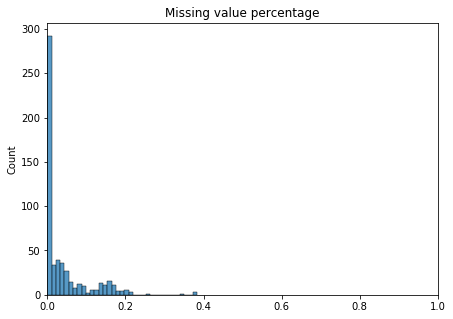

In [46]:
plt.figure(figsize=(7,5))
plt.title("Missing value percentage")
plt.xlim((0,1))
sns.histplot(filtered_90.isna().sum(axis=1)/ filtered_90.shape[1])

In [65]:
med_std = pd.DataFrame(index=nsaf_filtered.index)
med_std["med"] = np.log2(filtered_90).median(axis=1)
med_std["std_"] = np.log2(filtered_90).std(axis=1)
scaled_nsaf = {}
for i, row in np.log2(nsaf_filtered).iterrows():
    scaled_nsaf[i] = (np.array(row) - med_std.loc[i,"med"]) / med_std.loc[i,"std_"]

scaled_nsaf = pd.DataFrame(scaled_nsaf, index=nsaf_filtered.columns).T

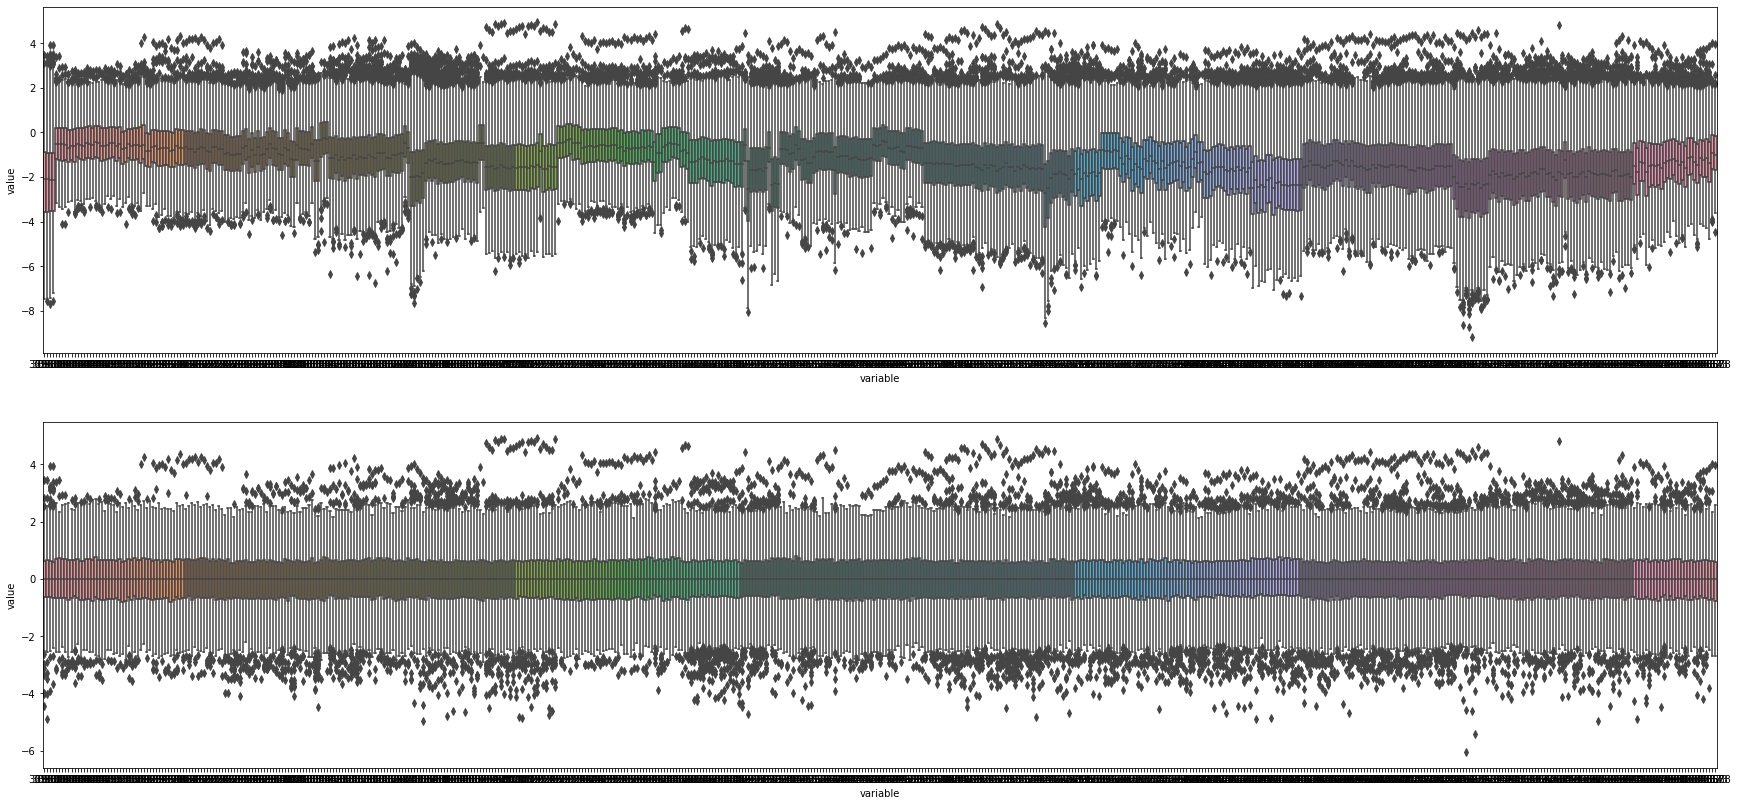

In [48]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=scaled_nsaf.T.melt().dropna(), y='value', x="variable", ax=ax[0])
sns.boxplot(data=scaled_nsaf.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="variable", ax=ax[1])

PXD008719 0.8721518708215001
PXD001327 0.9632579277250432
PXD002057 0.9002963867346643
PXD001352 0.7687275040223137
PXD009442 0.8726079728621382
PXD007543 0.7402200597680572
PXD008222 0.7642184091944199
PXD005940 nan
PXD004452 0.953368608792802
PXD008719 0.8721518708215001
PXD001327 0.9632579277250433
PXD002057 0.9002963867346643
PXD001352 0.7687275040223137
PXD009442 0.8726079728621382
PXD007543 0.7402200597680572
PXD008222 0.7642184091944199
PXD005940 nan
PXD004452 0.9533686087928018


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


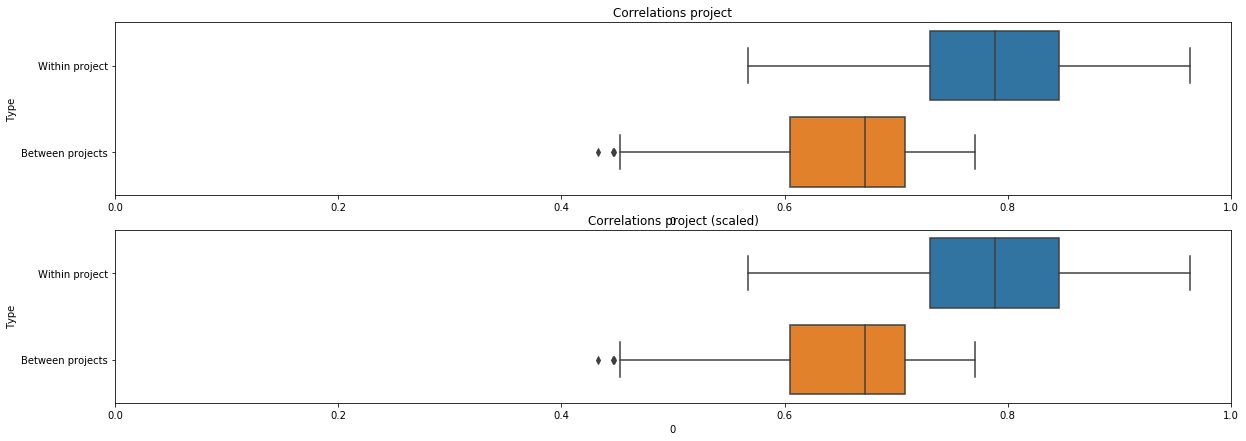

In [77]:
within_corr, between_corr = calculate_correlations(np.log2(nsaf_filtered), meta[meta.Group == "Ductal_breast"].index)
within_corr_sca, between_corr_sca = calculate_correlations(scaled_nsaf, meta[meta.Group == "Ductal_breast"].index)

all_within_corr = []
for px, x in within_corr.items():
    all_within_corr+=x
    print(px, np.mean(x))

all_between_corr = []
for x in between_corr.values():
    all_between_corr += x

all_within_corr_sca = []
for px, x in within_corr_sca.items():
    all_within_corr_sca+=x
    print(px, np.mean(x))

all_between_corr_sca = []
for x in between_corr_sca.values():
    all_between_corr_sca += x

fig, ax = plt.subplots(2,1, figsize=(20,7))

ax[0].set_title("Correlations project")
ax[0].set_xlim((0,1))
ax[1].set_title("Correlations project (scaled)")
ax[1].set_xlim((0,1))

all_within = pd.DataFrame(data=all_within_corr)
all_within["Type"] = "Within project"
all_between = pd.DataFrame(data=all_between_corr)
all_between["Type"] = "Between projects"
corr_df = pd.concat([all_within,all_between])

all_within_sca = pd.DataFrame(data=all_within_corr_sca)
all_within_sca["Type"] = "Within project"
all_between_sca = pd.DataFrame(data=all_between_corr_sca)
all_between_sca["Type"] = "Between projects"
corr_df_sca = pd.concat([all_within_sca,all_between_sca])

sns.boxplot(data=corr_df,x=0, y="Type", ax=ax[0])
sns.boxplot(data=corr_df_sca,x=0, y="Type", ax=ax[1])

In [17]:
nsaf_filtered_reoccuring = nsaf_filtered.loc[:,reoccurring]

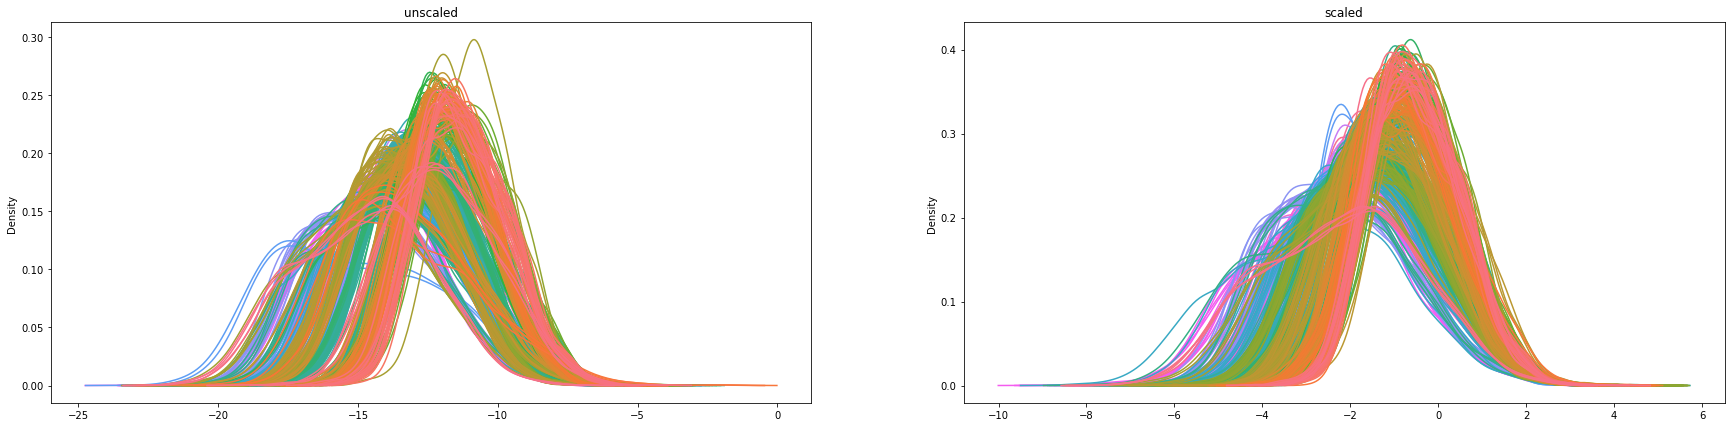

In [79]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('unscaled')
sns.kdeplot(data=np.log2(nsaf_filtered).transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("scaled")
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, common_norm=False, ax =ax[1])

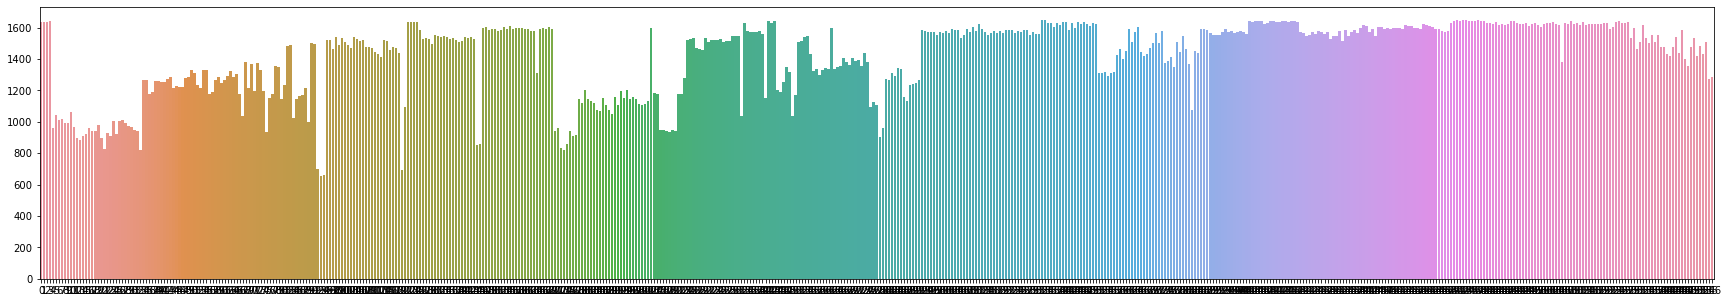

In [11]:
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_filtered_reoccuring))), y=nsaf_filtered_reoccuring.notna().sum(axis=1))

Median normalization is done as follows:
- log2 normalize expression data
- find reoccurring proteins for all samples (90%)
- define median and std for each sample based on the reoccurring proteins
- correct: (x-median)/std

In [18]:
# Log2 normalize
log_nsaf = np.log2(nsaf_filtered)

# Find reoccuring prots
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf_filtered.fillna(0), .7)
nsaf_reoccur = nsaf_filtered.loc[:, reoccurring]
log_nsaf_reoccur = log_nsaf.loc[:,reoccurring]

# Define median and std
med_std = pd.DataFrame()
med_std['median'] = log_nsaf_reoccur.fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = log_nsaf_reoccur.apply(lambda x: np.std(x), axis =1)

# Scale samples
def scale_sample(row):
    median, std = med_std.loc[row.name,:]
    return (row-median)/std

scaled_nsaf = log_nsaf.apply(lambda x: scale_sample(x), axis = 1)
scaled_nsaf_reoccur = scaled_nsaf.loc[:,reoccurring]

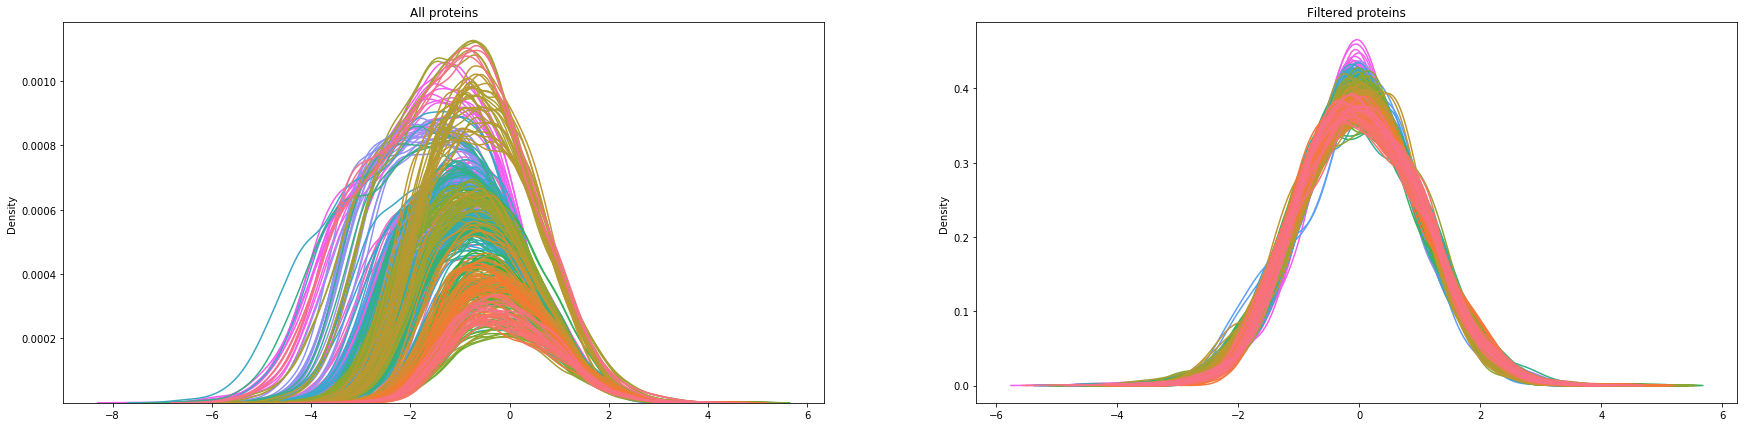

In [19]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=scaled_nsaf_reoccur.transpose(), legend = False, common_norm=False, ax =ax[1])

Save dataframe to csv for machine learning modelling

In [82]:
filtered_90.shape

(557, 652)

In [81]:
scaled_nsaf.to_csv("NSAF_data_90scale.csv")

In [20]:
scaled_nsaf.to_csv("norm_NSAF_data.csv")

In [33]:
np.exp2(scaled_nsaf)

uniprot_id  A0A024RBG1  A0A075B6X5  A0A075B767  A0A087WV62  A0A087X0K7  \
assay_id                                                                 
30960         0.197769         NaN         NaN         NaN         NaN   
30961              NaN         NaN         NaN         NaN         NaN   
31008         0.189281         NaN         NaN         NaN         NaN   
31009         0.187936         NaN         NaN    0.246789         NaN   
31102              NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
36558              NaN         NaN         NaN         NaN         NaN   
36563              NaN         NaN         NaN         NaN         NaN   
36568              NaN         NaN         NaN         NaN         NaN   
36573              NaN         NaN         NaN         NaN         NaN   
36578              NaN         NaN         NaN         NaN         NaN   

uniprot_id  A0A096LP01  A0A096LP49  A0A096LP55  A0A0A6YYK6  A0A0A6YYK7  ...  \
assay_id                                                                ...   
30960              NaN         NaN         NaN         NaN         NaN  ...   
30961              NaN         NaN         NaN         NaN         NaN  ...   
31008         0.539949         NaN         NaN         NaN         NaN  ...   
31009         0.636489         NaN         NaN         NaN         NaN  ...   
31102              NaN         NaN         NaN         NaN         NaN  ...   
...                ...         ...         ...         ...         ...  ...   
36558              NaN         NaN         NaN         NaN         NaN  ...   
36563              NaN         NaN         NaN         NaN         NaN  ...   
36568              NaN         NaN         NaN         NaN         NaN  ...   
36573              NaN         NaN         NaN         NaN         NaN  ...   
36578              NaN         NaN         NaN         NaN         NaN  ...   

uniprot_id    Q9Y6X5    Q9Y6X8    Q9Y6X9    Q9Y6Y0    Q9Y6Y1    Q9Y6Y8  \
assay_id                                                                 
30960       0.258719  0.357554  0.439738  0.562651       NaN  0.690589   
30961       0.260966  0.389411  0.451230  0.469237  0.056926  0.621789   
31008            NaN  0.145916  0.310703  0.450480       NaN  0.694543   
31009            NaN  0.113596  0.387258  0.370894       NaN  0.617179   
31102            NaN       NaN       NaN       NaN       NaN  0.298729   
...              ...       ...       ...       ...       ...       ...   
36558            NaN       NaN  0.491478  1.168066       NaN  0.317706   
36563       0.352954       NaN  0.590305  0.293286       NaN  1.137719   
36568       0.337789       NaN  0.221910  0.402700       NaN  0.651617   
36573       0.390503       NaN  0.363041  0.594303       NaN  0.250634   
36578            NaN       NaN  0.461529       NaN       NaN       NaN   

uniprot_id    Q9Y6Y9  Q9Y6Z5    Q9Y6Z7  W5XKT8  
assay_id                                        
30960            NaN     NaN       NaN     NaN  
30961            NaN     NaN       NaN     NaN  
31008       0.309264     NaN       NaN     NaN  
31009       0.306897     NaN       NaN     NaN  
31102            NaN     NaN       NaN     NaN  
...              ...     ...       ...     ...  
36558            NaN     NaN       NaN     NaN  
36563            NaN     NaN       NaN     NaN  
36568            NaN     NaN       NaN     NaN  
36573            NaN     NaN  0.514341     NaN  
36578            NaN     NaN       NaN     NaN  

[557 rows x 14507 columns]

In [50]:
scaled_nsaf.std().sort_values()

uniprot_id
Q96N22    0.015581
P56817    0.032592
Q6UXN7    0.046892
Q5T890    0.049258
B4DJY2    0.051560
            ...   
Q6ZQT7         NaN
Q86WV1         NaN
Q96F15         NaN
Q9H8W2         NaN
Q9UIV8         NaN
Length: 14507, dtype: float64

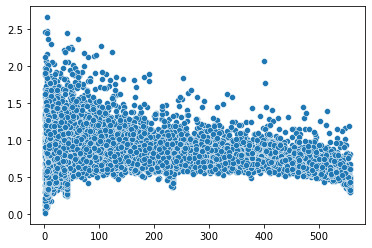

In [23]:
sns.scatterplot(x=scaled_nsaf.notna().sum(), y=scaled_nsaf.std())

In [24]:
abundant_prot = scaled_nsaf.columns[scaled_nsaf.notna().sum() > 500]

In [25]:
scaled_nsaf.loc[:,abundant_prot].std().sort_values()

uniprot_id
Q7KZF4    0.286997
P50991    0.287920
P54136    0.289919
P13010    0.307102
P42704    0.308196
            ...   
O43707    1.152663
P62805    1.181621
O75369    1.203166
Q9NZM1    1.247989
P35580    1.383034
Length: 660, dtype: float64

Q7KZF4 has Tau specificity score of 0.11 in THPA <br>
P50991 0.05 <br>
Q99497 0.04

In [26]:
# DJ-1, yet only present in 41 of 557 samples
scaled_nsaf.loc[:,"Q99497"].std()

0.384688033504235

---
---

# Quantile normalization

In [3]:
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")
meta = meta[meta.index.isin(nsaf.index)]

nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)
drop_assays = low_id_rate.index[low_id_rate < 1100]
nsaf_filtered = nsaf.loc[~nsaf.index.isin(drop_assays)]

# See at the end of document (filtered raw files identifying < 1100 proteins)
meta = meta[meta.index.isin(nsaf_filtered.index)]

nsaf_filtered.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [4]:
ranked_df = nsaf_filtered.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_filtered.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

In [39]:
filtered_90 = uml.FilterByOccurence(.9).fit_transform(nsaf_filtered)

In [5]:
import numpy as np

In [6]:
sorted_arrays = []
for i, row in np.log2(nsaf_filtered).iterrows():
    
    # Sorts the row from smallest to biggest and putting the nans at the back
    row = np.sort(np.array(row))
    sorted_arrays.append(row)
sorted_df = pd.DataFrame(sorted_arrays)

In [7]:
rank_mean = sorted_df.mean().sort_values()
rank_median = sorted_df.median().sort_values()

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


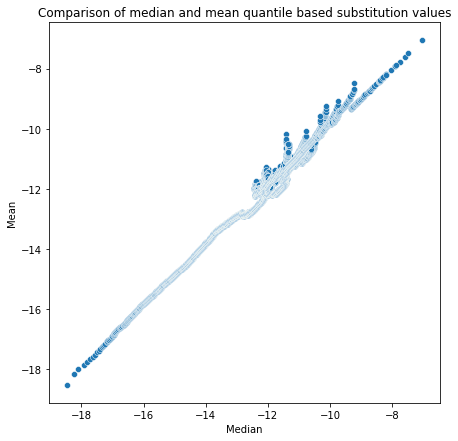

In [8]:
plt.figure(figsize=(7,7))
plt.xlabel("Median")
plt.ylabel("Mean")
#plt.ylim((-.001,.01))
#plt.xlim((-.001, 0.01))
plt.title("Comparison of median and mean quantile based substitution values")
sns.scatterplot(x=rank_median.dropna(),
                y=rank_mean.dropna())
#plt.plot([0,.01], [0,.01], color='r')

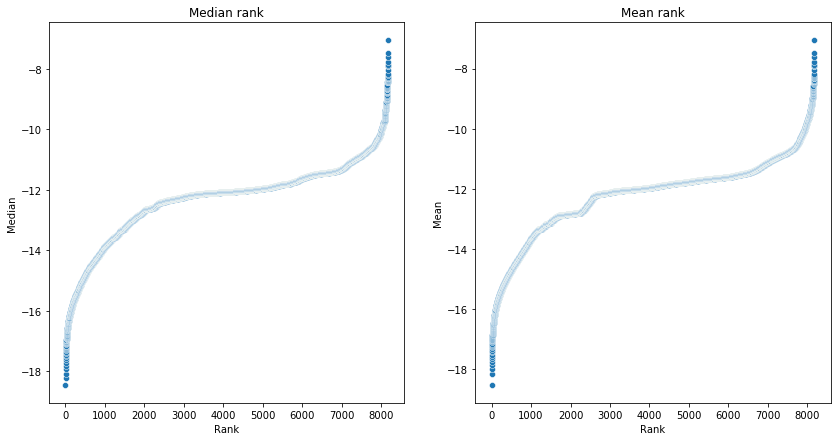

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
#ax[0].set_ylim((-.001, 0.01))
#ax[1].set_ylim((-.001, 0.01))
ax[0].set_title("Median rank")
ax[1].set_title("Mean rank")

ax[0].set_ylabel("Median")
ax[1].set_ylabel("Mean")

ax[0].set_xlabel("Rank")
ax[1].set_xlabel("Rank")

sns.scatterplot(x=list(range(len(rank_median.dropna()))), y=rank_median.dropna(), ax=ax[0])
sns.scatterplot(x=list(range(len(rank_mean.dropna()))), y=rank_mean.dropna(), ax=ax[1])

In [19]:
list(range(len(rank_median), 0,-1))

[8180,
 8179,
 8178,
 8177,
 8176,
 8175,
 8174,
 8173,
 8172,
 8171,
 8170,
 8169,
 8168,
 8167,
 8166,
 8165,
 8164,
 8163,
 8162,
 8161,
 8160,
 8159,
 8158,
 8157,
 8156,
 8155,
 8154,
 8153,
 8152,
 8151,
 8150,
 8149,
 8148,
 8147,
 8146,
 8145,
 8144,
 8143,
 8142,
 8141,
 8140,
 8139,
 8138,
 8137,
 8136,
 8135,
 8134,
 8133,
 8132,
 8131,
 8130,
 8129,
 8128,
 8127,
 8126,
 8125,
 8124,
 8123,
 8122,
 8121,
 8120,
 8119,
 8118,
 8117,
 8116,
 8115,
 8114,
 8113,
 8112,
 8111,
 8110,
 8109,
 8108,
 8107,
 8106,
 8105,
 8104,
 8103,
 8102,
 8101,
 8100,
 8099,
 8098,
 8097,
 8096,
 8095,
 8094,
 8093,
 8092,
 8091,
 8090,
 8089,
 8088,
 8087,
 8086,
 8085,
 8084,
 8083,
 8082,
 8081,
 8080,
 8079,
 8078,
 8077,
 8076,
 8075,
 8074,
 8073,
 8072,
 8071,
 8070,
 8069,
 8068,
 8067,
 8066,
 8065,
 8064,
 8063,
 8062,
 8061,
 8060,
 8059,
 8058,
 8057,
 8056,
 8055,
 8054,
 8053,
 8052,
 8051,
 8050,
 8049,
 8048,
 8047,
 8046,
 8045,
 8044,
 8043,
 8042,
 8041,
 8040,
 8039,
 8038,

In [20]:
rank_median = pd.DataFrame(rank_median.dropna(), columns=["Rank_substitution"])
rank_median["index"] = list(range(len(rank_median), 0,-1))
rank_median = rank_median.set_index("index")
rank_mapper = {float(x):rank_median.loc[x].values[0] for x in range(1,len(rank_median)+1)}
rank_median

Rank_substitution
index                   
8180          -18.454651
8179          -18.231485
8178          -18.096205
8177          -17.922464
8176          -17.808465
...                  ...
5              -7.885748
4              -7.765541
3              -7.599415
2              -7.493680
1              -7.044736

[8180 rows x 1 columns]

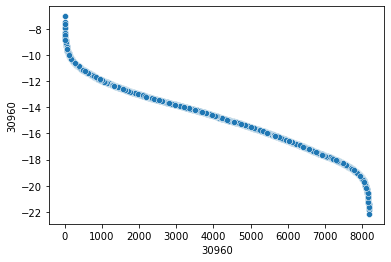

In [33]:
sns.scatterplot(x=nsaf_filtered.rank(axis=1, method="average", na_option="keep", ascending=False).iloc[0,:], y=np.log2(nsaf_filtered.iloc[0,:]))

In [34]:
ranked_df = nsaf_filtered.rank(axis=1, method="average", na_option="keep", ascending=False)

In [35]:
import math
def replace_values(x):
    if np.isnan(x):
        return np.nan
    elif x not in rank_mapper.keys():
        return np.mean([rank_mapper[math.ceil(x)], rank_mapper[math.ceil(x)-1]])
    else:
        return rank_mapper[x]

In [36]:
quantile_normalized_df = ranked_df.applymap(lambda x: replace_values(x))

In [37]:
quantile_normalized_df.max(axis=1)

assay_id
30960   -7.044736
30961   -7.044736
31008   -7.044736
31009   -7.044736
31102   -7.044736
           ...   
36558   -7.044736
36563   -7.044736
36568   -7.044736
36573   -7.044736
36578   -7.044736
Length: 557, dtype: float64

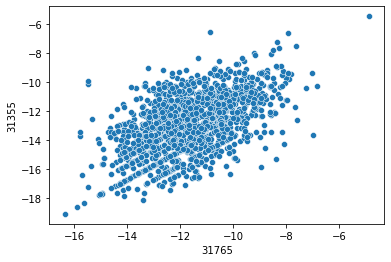

In [58]:
sns.scatterplot(x=np.log2(nsaf_filtered.iloc[200,:]), y= np.log2(nsaf_filtered.iloc[100,:]))

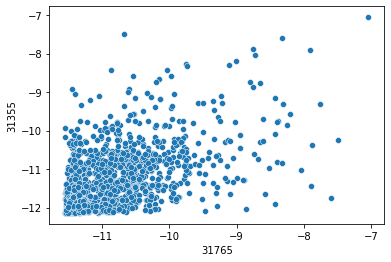

In [57]:
sns.scatterplot(x=quantile_normalized_df.iloc[200,:], y= quantile_normalized_df.iloc[100,:])

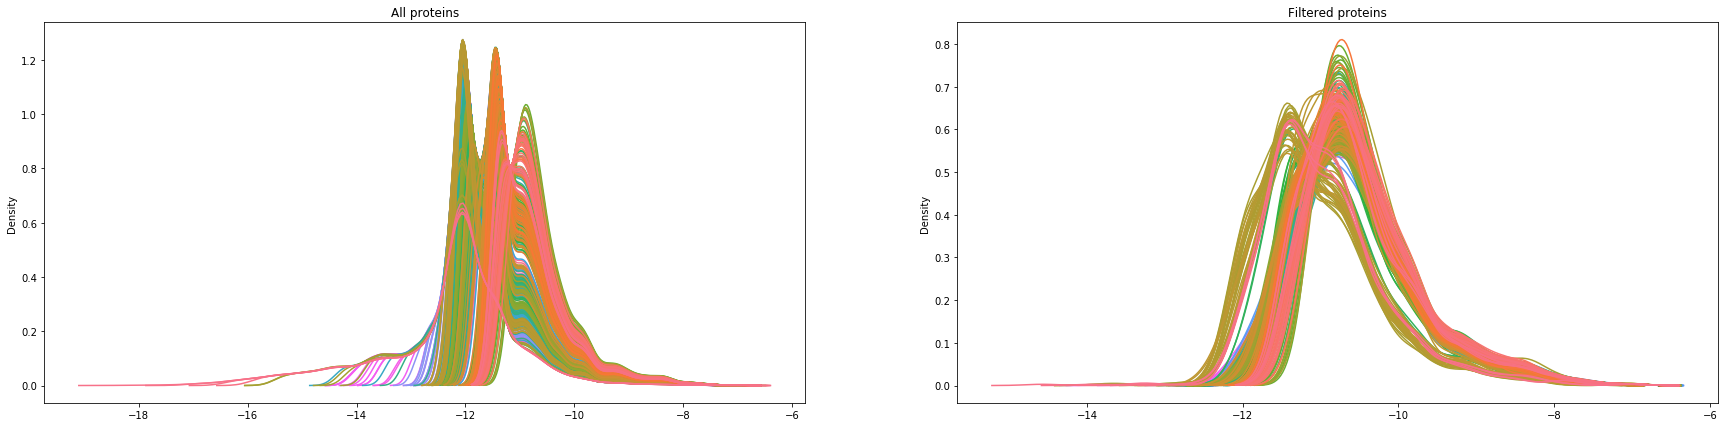

In [40]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=quantile_normalized_df.transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=quantile_normalized_df.loc[:, filtered_90.columns].transpose(), legend = False, common_norm=False, ax =ax[1])

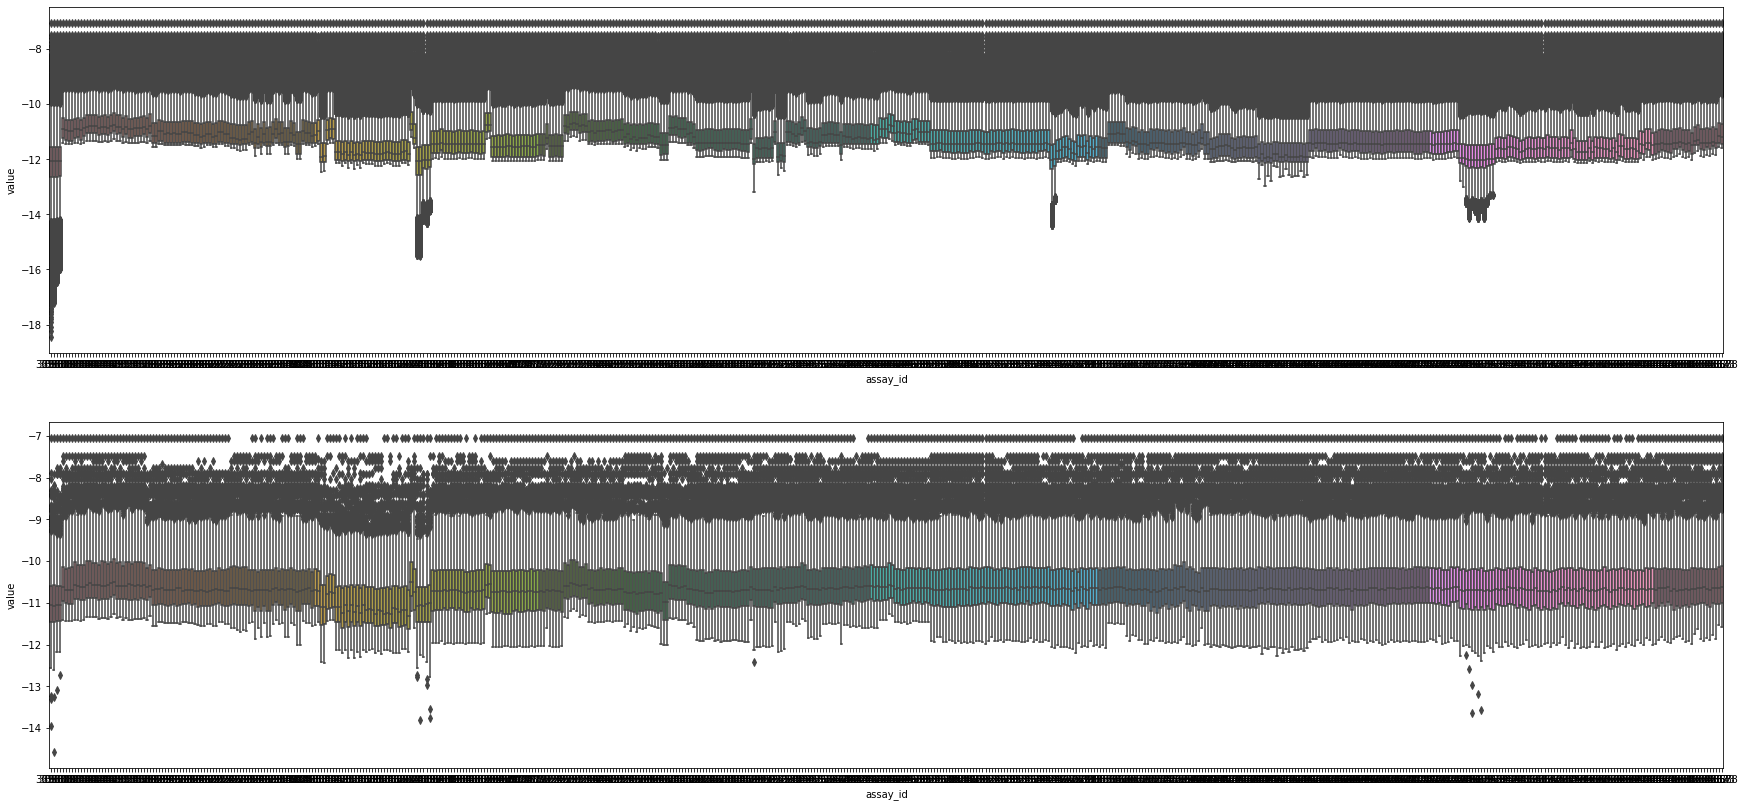

In [41]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=quantile_normalized_df.T.melt().dropna(), y='value', x="assay_id", ax=ax[0])
sns.boxplot(data=quantile_normalized_df.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="assay_id", ax=ax[1])

In [99]:
quantile_normalized_df.to_csv("quantile_norm_NSAF.csv")

In [49]:
from itertools import combinations

In [61]:
def calculate_correlations_bygroup(group):

    within_corr, between_corr = calculate_correlations(np.log2(nsaf_filtered), meta[meta.Group == group].index)
    within_corr_sca, between_corr_sca = calculate_correlations(quantile_normalized_df, meta[meta.Group == group].index)

    all_within_corr = []
    for px, x in within_corr.items():
        all_within_corr+=x
        print(px, np.mean(x))

    all_between_corr = []
    for x in between_corr.values():
        all_between_corr += x

    all_within_corr_sca = []
    for px, x in within_corr_sca.items():
        all_within_corr_sca+=x
        print(px, np.mean(x))

    all_between_corr_sca = []
    for x in between_corr_sca.values():
        all_between_corr_sca += x

    fig, ax = plt.subplots(2,1, figsize=(20,7))

    ax[0].set_title("Correlations project")
    ax[0].set_xlim((0,1))
    ax[1].set_title("Correlations project (scaled)")
    ax[1].set_xlim((0,1))

    all_within = pd.DataFrame(data=all_within_corr)
    all_within["Type"] = "Within project"
    all_between = pd.DataFrame(data=all_between_corr)
    all_between["Type"] = "Between projects"
    corr_df = pd.concat([all_within,all_between])

    all_within_sca = pd.DataFrame(data=all_within_corr_sca)
    all_within_sca["Type"] = "Within project"
    all_between_sca = pd.DataFrame(data=all_between_corr_sca)
    all_between_sca["Type"] = "Between projects"
    corr_df_sca = pd.concat([all_within_sca,all_between_sca])

    sns.boxplot(data=corr_df,x=0, y="Type", ax=ax[0])
    sns.boxplot(data=corr_df_sca,x=0, y="Type", ax=ax[1])

PXD002842 0.8914968511558112
PXD010538 0.9158926394429627
PXD009560 0.896552038666169
PXD004452 0.9542672037536056
PXD002842 0.9285759451732228
PXD010538 0.9393488679914256
PXD009560 0.9304458788441967
PXD004452 0.9450034549184113


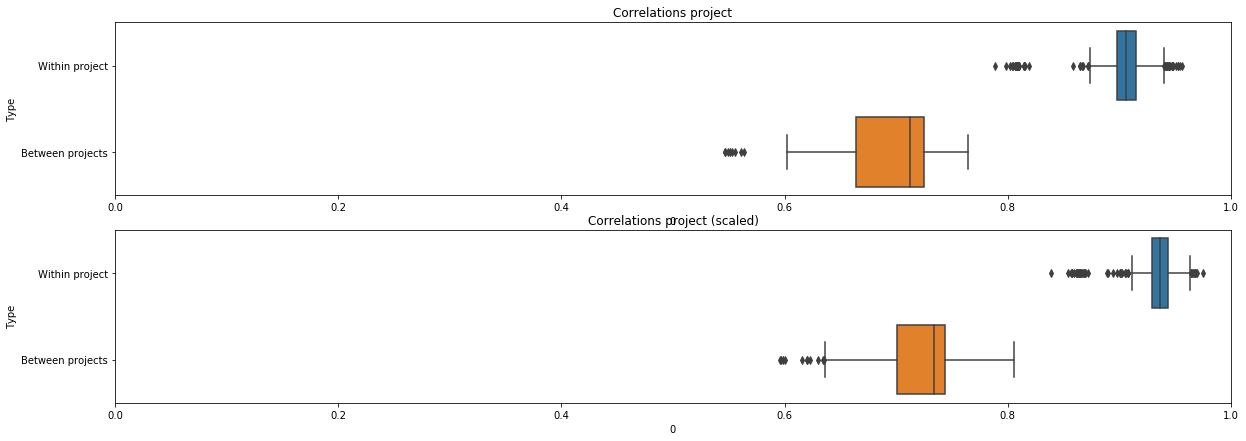

In [62]:
calculate_correlations_bygroup("Neuroblastoma")

PXD000612 0.9166484773691737
PXD004182 0.8994014156457263
PXD004940 0.8778812822930502
PXD001441 nan
PXD003530 0.9095021268520742
PXD006112 0.8869805737654365
PXD004452 0.881928856265125
PXD004900 0.9106111584429193
PXD000612 0.9451346321102645
PXD004182 0.9322579416627362
PXD004940 0.8891117917757725
PXD001441 nan
PXD003530 0.9384082453936445
PXD006112 0.9167826490157662
PXD004452 0.8838637290214745
PXD004900 0.9282501949081632


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


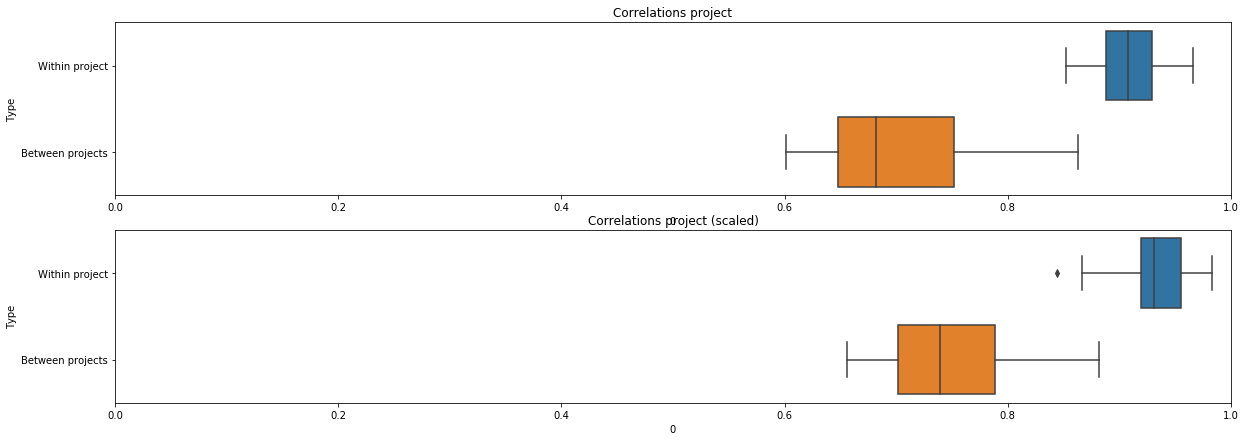

In [63]:
calculate_correlations_bygroup("HeLa")

PXD008719 0.8721518708215001
PXD001327 0.9632579277250432
PXD002057 0.9002963867346643
PXD001352 0.7687275040223137
PXD009442 0.8726079728621382
PXD007543 0.7402200597680572
PXD008222 0.7642184091944199
PXD005940 nan
PXD004452 0.953368608792802
PXD008719 0.8849512167620205
PXD001327 0.9827654481026514
PXD002057 0.9215759892468635
PXD001352 0.7714235196831823
PXD009442 0.8804627280835743
PXD007543 0.750529565512994
PXD008222 0.8012578356380996
PXD005940 nan
PXD004452 0.9638566237439405


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


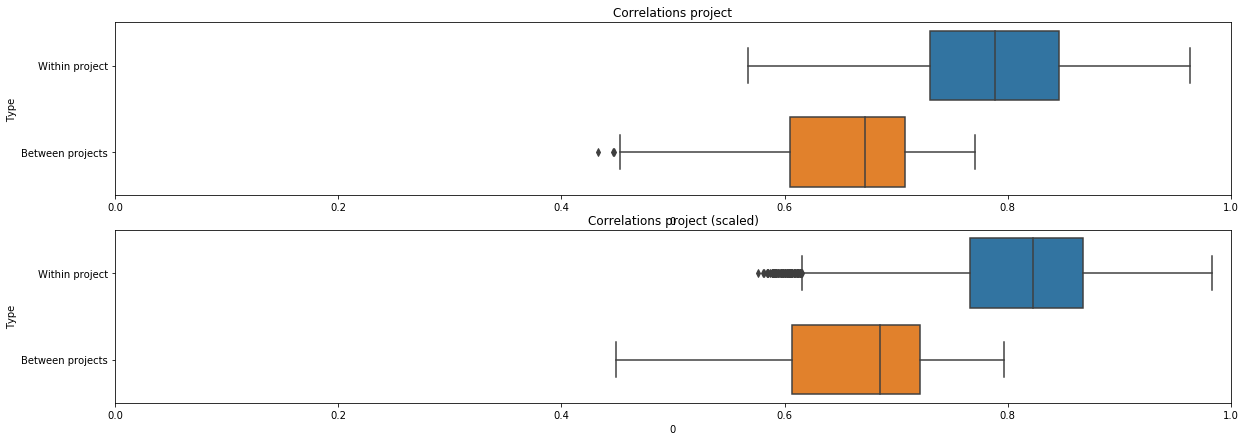

In [64]:
calculate_correlations_bygroup("Ductal_breast")

In [71]:
colors = sns.color_palette("pastel") + sns.color_palette("tab20")
colors = colors[:28]
print(len(colors))

28


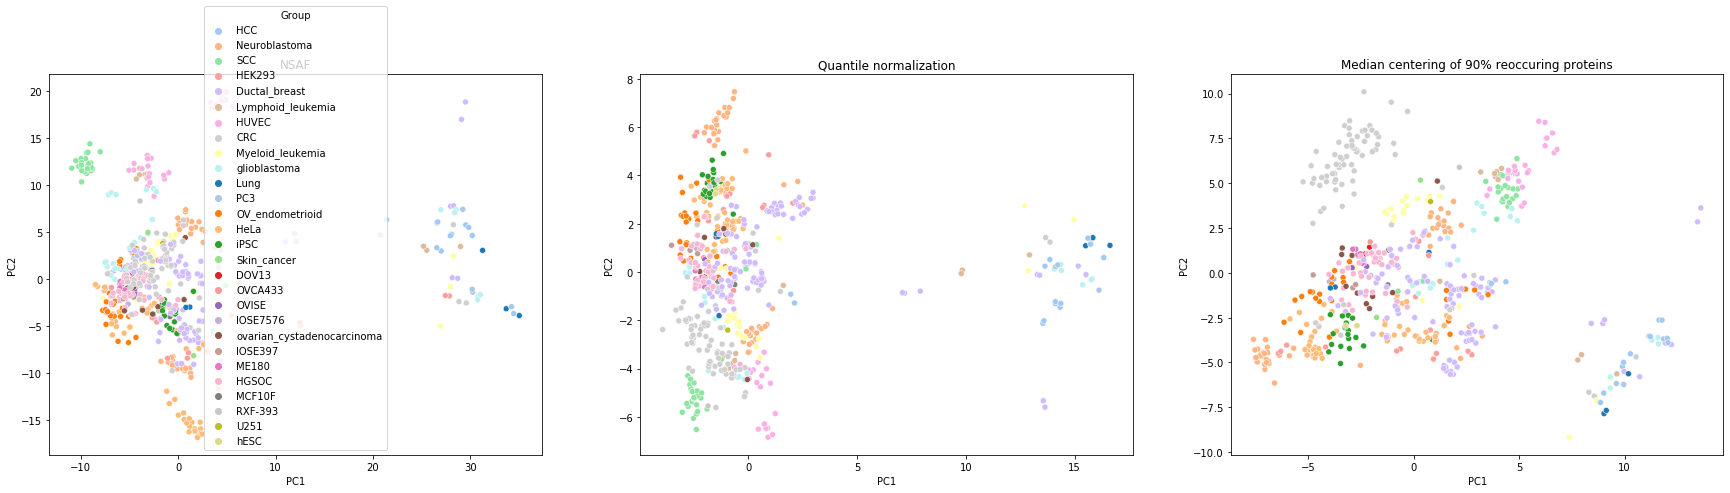

In [77]:
from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer1.fit(np.log2(nsaf_filtered.loc[:,filtered_90.columns]))
X1 = imputer1.transform(np.log2(nsaf_filtered.loc[:,filtered_90.columns]))

imputer2 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer2.fit(quantile_normalized_df.loc[:,filtered_90.columns])
X2 = imputer2.transform(quantile_normalized_df.loc[:,filtered_90.columns])

imputer3 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer3.fit(scaled_nsaf.loc[:,filtered_90.columns])
X3 = imputer3.transform(scaled_nsaf.loc[:,filtered_90.columns])

fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = PCA(n_components=2).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, ax=ax[0])

embedding = PCA(n_components=2).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[1])

embedding = PCA(n_components=2).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[2])

In [83]:
from sklearn.decomposition import KernelPCA

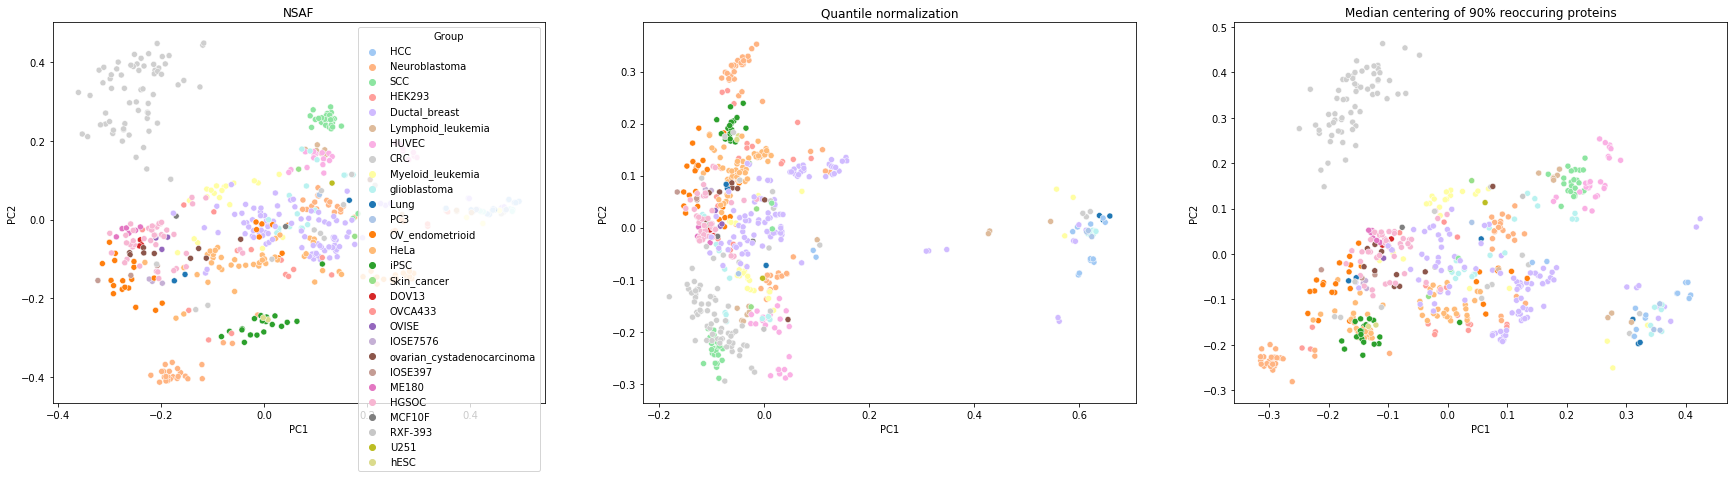

In [85]:
fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = KernelPCA(n_components=2, kernel = "rbf").fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, ax=ax[0])

embedding = KernelPCA(n_components=2, kernel = "rbf").fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[1])

embedding = KernelPCA(n_components=2, kernel = "rbf").fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[2])

In [91]:
meta.PXD_accession.nunique()

44

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

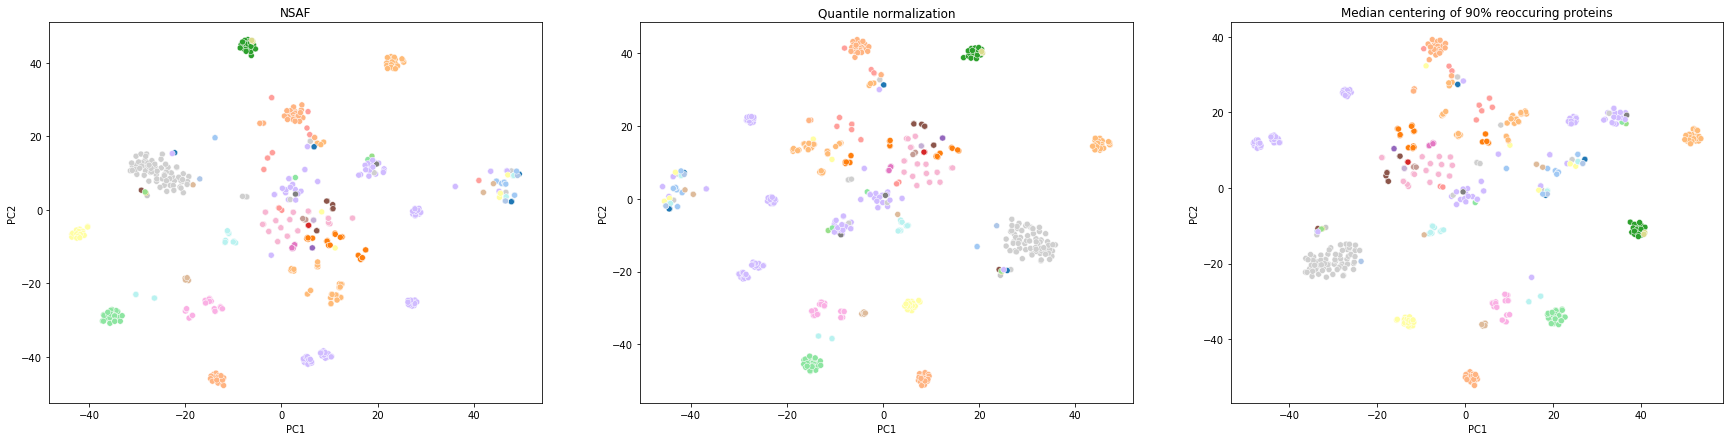

In [73]:
fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = TSNE(perplexity=20).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[0])

embedding = TSNE(perplexity=20).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[1])

embedding = TSNE(perplexity=20).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors, legend=False, ax=ax[2])

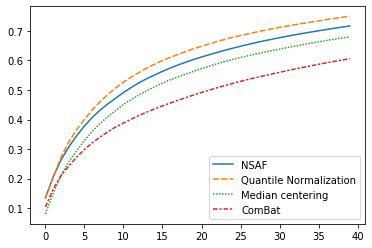

In [114]:
pc1 = PCA(n_components = 40)
pc2 = PCA(n_components = 40)
pc3 = PCA(n_components = 40)
pc4 = PCA(n_components = 40)

embedding = pc1.fit_transform(X1)
embedding = pc2.fit_transform(X2)
embedding = pc3.fit_transform(X3)
embedding = pc4.fit_transform(combat_df)

sns.lineplot(data=pd.DataFrame({"NSAF": np.cumsum(pc1.explained_variance_ratio_),
            "Quantile Normalization": np.cumsum(pc2.explained_variance_ratio_),
            "Median centering": np.cumsum(pc3.explained_variance_ratio_),
            "ComBat": np.cumsum(pc4.explained_variance_ratio_)}))

# PyCombat batch correction

In [93]:
from combat.pycombat import pycombat

In [96]:
combat_df = pycombat(pd.DataFrame(X1).T, meta.Group.tolist())

Found 28 batches.

One batch has only one sample, try setting mean_only=True.

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return (2*s2+m*m)/s2
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return (m*s2+m*m*m)/s2
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in true_divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:158: RuntimeWarning: invalid value encountered in true_divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


In [98]:
combat_df = combat_df.T

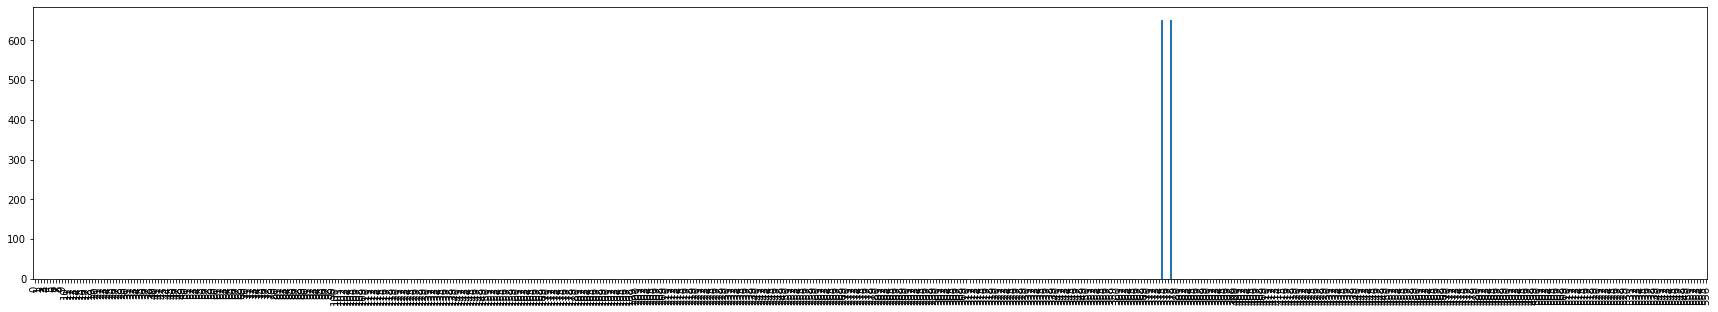

In [101]:
combat_df.isna().sum(axis=1).plot(kind="bar", figsize=(30,5))

In [105]:
combat_df = combat_df.set_index(nsaf_filtered.index)
combat_df = combat_df.dropna()

In [108]:
meta.loc[combat_df.index, "Group"].nunique()

26

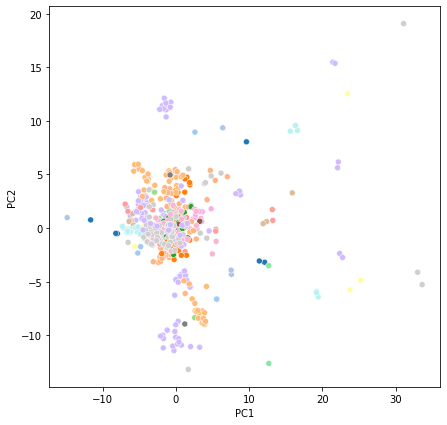

In [109]:
embedding = PCA(n_components=2).fit_transform(combat_df)

plt.figure(figsize=(7,7))
sns.scatterplot(data=pd.DataFrame(embedding, index= combat_df.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.loc[combat_df.index, "Group"], palette=colors[:26], legend=False)

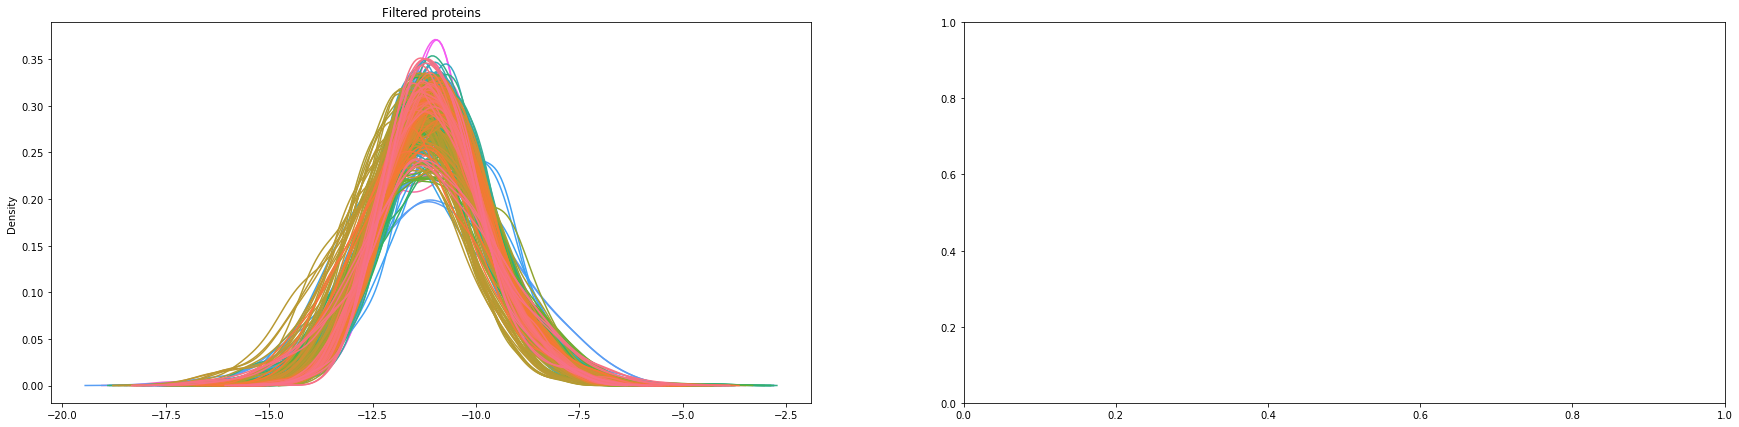

In [113]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('Filtered proteins')
sns.kdeplot(data=combat_df.transpose(), legend = False, common_norm=False, ax =ax[0])

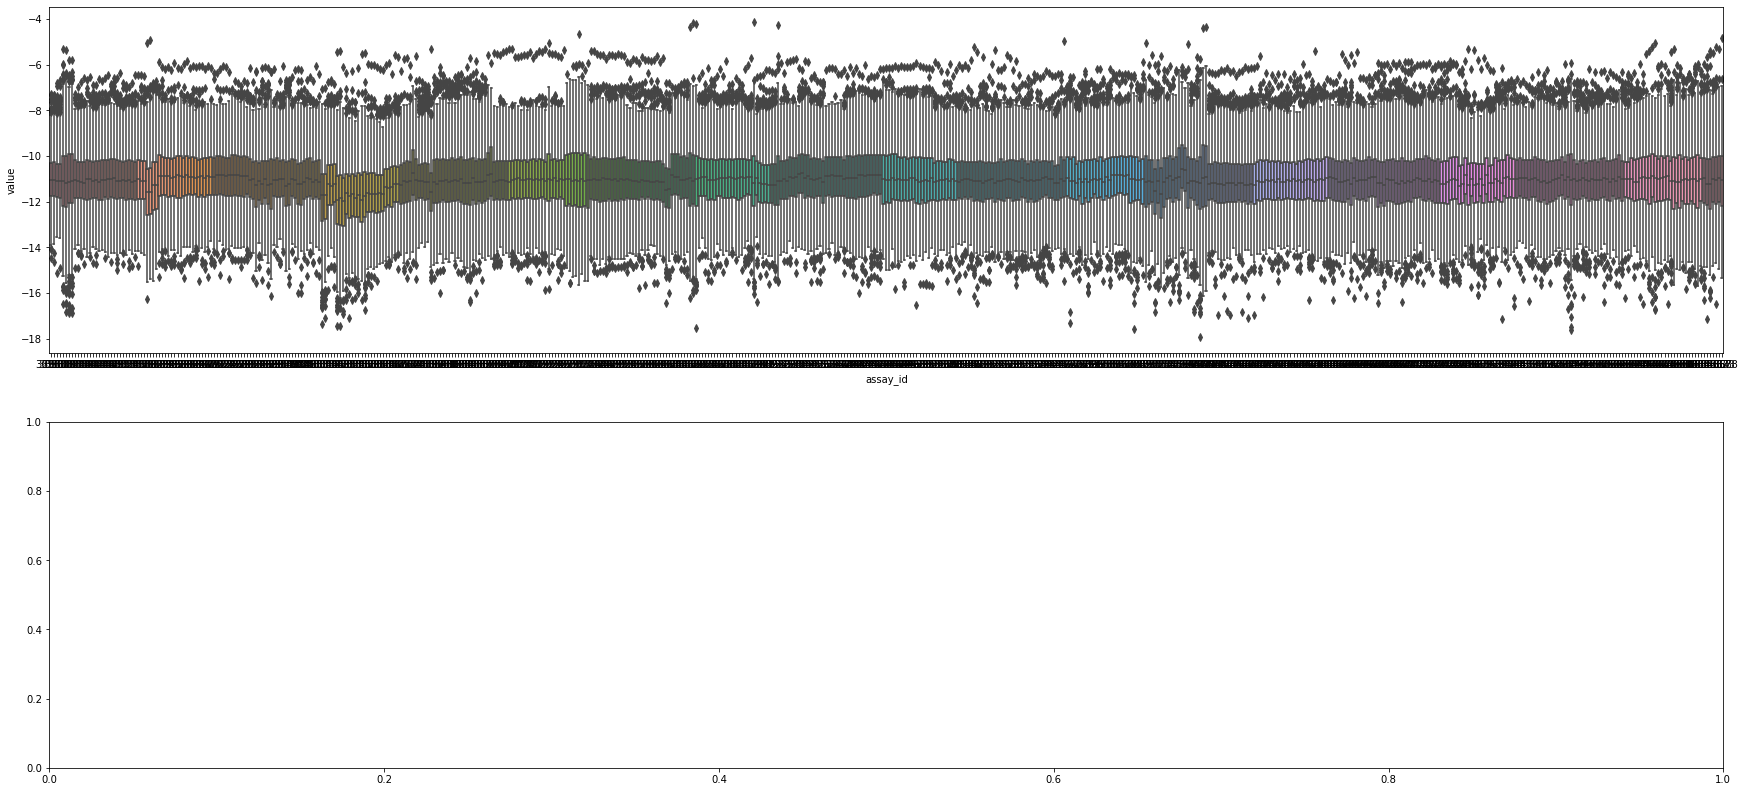

In [112]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=combat_df.T.melt().dropna(), y='value', x="assay_id", ax=ax[0])